In [1]:
import sys
#sys.path.append('/exports/csce/datastore/geos/users/s2110831/JUPYTER_old/GRADIOMETRY_Synthetic/Codebase(ii)-REWRITE-04-2021/Functions')
sys.path.append('/scratch/s2110831/JUPYTER/GRADIOMETRY_Synthetic/Codebase_iii_2021/Functions')
sys.path.append('/scratch/s2110831/JUPYTER/GRADIOMETRY_Synthetic/Codebase_iv_2022/Functions_2022')
sys.path.append('/scratch/s2110831/JUPYTER/GRADIOMETRY_Synthetic/Codebase_iii_2021//ViscoELASTIC_2D')
sys.path.append('/exports/csce/datastore/geos/users/s2110831/JUPYTER_old/GRADIOMETRY_Synthetic/Codebase(ii)-REWRITE-04-2021/Functions')
sys.path.append('/exports/csce/datastore/geos/groups/salvus_graddata')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
import pathlib
import xarray as xr
import pandas as pd
import json

import salvus.namespace as sn
import salvus.mesh.simple_mesh.basic_mesh as mbm
import salvus.flow.simple_config as sc
from salvus.mesh.simple_mesh import rho_from_gardeners, vs_from_poisson

from pyasdf import ASDFDataSet
import h5py

# Run simulations on this site.
SALVUS_FLOW_SITE_NAME = os.environ.get("SITE_NAME", "local")

/tmp/ipykernel_823798/2984098659.py:10: MovedIn20Warning: Deprecated API features detected! These feature(s) are not compatible with SQLAlchemy 2.0. To prevent incompatible upgrades prior to updating applications, ensure requirements files are pinned to "sqlalchemy<2.0". Set environment variable SQLALCHEMY_WARN_20=1 to show all deprecation warnings.  Set environment variable SQLALCHEMY_SILENCE_UBER_WARNING=1 to silence this message. (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  import salvus.namespace as sn


--> Server: 'https://l.mondaic.com/licensing_server', User: 'marthe.faber', Group: 'UniversityOfEdinburgh'.
--> Negotiating 1 license instance(s) for 'SalvusMesh' [license version 1.0.0] for 1 seconds ...
--> Success! [Total duration: 0.41 seconds]


In [4]:
# Import own functions
from vel_rho_Q_models import *
from FCT_plotting import *
from FCT_BP_filter_loop import BP_filter
from FCT_3D_gradients import dttv, _1st_DER, _2nd_DER
from FCT_3D_gradients_FS import *
from FCT_laplacian import *
from FCT_WaveEquations import WE_3D_ELASTIC, WE_2D_ELASTIC_OPTiii_no_dz
from FCT_WaveEquations_at_FS import *
from FCT_Normal_Solution import NORM_SOL_3D_ELASTIC, NORM_SOL_2D_ELASTIC_OPTiii_no_dz
from FCT_Normal_Solution_at_FS import *
from FCT_objective import *

## Load Project




In [5]:
output = '/exports/csce/datastore/geos/users/s2110831/'

# Load an existing project.
#'project3D_step_testIII'#
#'3Delastic_deep'#'project3D_step_testIII'#
project_name ='3DELASTIC_HET600x300_HET_abs2_4el_test2_hetZ_AMBIENTii_LARGER-'#_sameDIR'#'3DELASTIC_HET600x300_HET_abs2_4el_test2_hetZ_AMBIENTii_LARGER-' #'3Delastic_deep'#'3DELASTIC_HET600x300_HET_abs2_4el_test2_hetZ_AMBIENTii_LARGER-' #'!HET600x300_HET_nonVISCO_4el_pendantTO_3DACOUSTIC_HET600x300_HET_abs2_8elTEST_DEEP'#'3DELASTIC_HET600x300_HET_abs2_4el_test2_hetZ_ACTIVEii_LARGER-'#'drop_test' #'3DELASTIC_HET600x300_HET_abs2_4el_test2_hetZ_AMBIENTii_LARGER-'#'3DELASTIC_HET600x300_HET_abs2_4el_test2_hetZ_AMBIENTii_LARGER-'#"project3D600x300_step_test_src_DEEP"#"project3D_gradient+++"#"project3D600x300_step_2src"#"project3D600x300_step_test_srcSURF" #"project3D_step_ambientSURF"

if pathlib.Path(str(output)+"out/"+str(project_name)).exists():
    print("Opening existing project.")
    p = sn.Project(path=str(output)+"out/"+str(project_name))
    
else:
    print("No run with name " + str(project_name)+' available')

event_name = "src_loc_c_isotropic_FS_src_SURF"#DEEP"


Opening existing project.


Accordion(children=(HTML(value='\n                <head>\n                <style>\n                td {\n     …

In [6]:
# output = '/exports/csce/datastore/geos/groups/salvus_graddata/'
# project_name ="project3D600x300_step_test_src_DEEP"
# event_name = "src_loc_c_isotropic_FS_src_DEEP"

# if pathlib.Path(str(output)+str(project_name)).exists():
#     print("Opening existing project.")
#     p = sn.Project(path=str(output)+str(project_name))
    
# else:
#     print("No run with name " + str(project_name)+' available')

### Load Setup, Parameters & Models

In [7]:
# Read data from file:
path_ev = str(output)+"out/"+str(project_name)+"/EVENTS/"+str(event_name)
#path_ev = str(output)+str(project_name)+"/EVENTS/"+str(event_name)

fig_ = str(path_ev)+'/FIGURES'
para_ = str(path_ev)+'/PARAMETERS'
input_ = str(path_ev)+'/INPUT_MODELS'
output_ = str(path_ev)+'/OUTPUT_FIELDS'

mod_ = str(fig_)+'/MODELS'
fields = fig_+str('/FIELDS')
vel_ = fields+ str('/vel')
#os.mkdir(vel_)
#disp_ = fields+ str('/disp')
#os.mkdir(disp_)
_res =  str(fig_)+'/RESULTS'
#os.mkdir(_res)

In [8]:
# Simulation Parameters
PARA = json.load( open( para_+"/_ALL.json" ) )

# Models
#ds_with_q = xr.open_dataset(str(input_)+"/ds_with_q.nc")
ds_without_q = xr.open_dataset(str(input_)+"/ds_without_q.nc")
#el_pos = xr.open_dataset(str(input_)+"/el_pos.nc")

model_true = xr.open_dataset(str(input_)+"/model_true.nc")

In [9]:
nx  = PARA['x_domain']
ny  = PARA['y_domain']
nz  = PARA['z_domain']
rx0 = PARA['rec_grid_pos'][0]
ry0 = PARA['rec_grid_pos'][1]
rx1 = PARA['rec_grid_pos'][2]
ry1 = PARA['rec_grid_pos'][3]
sx  = PARA['src_loc'][0]
sy  = PARA['src_loc'][1]
sz  = abs(PARA['src_loc'][2]-nz)

In [10]:
# Receiver names & positions
receiver_field = xr.open_dataset(str(input_)+"/recs.nc")
rec_list = pd.DataFrame(np.array(receiver_field.location), receiver_field.st_name)
pd.set_option("display.max_rows", None, "display.max_columns", None)
rec_list
#plt.scatter(rec_list[0], rec_list[1])
grid = np.array([rec_list[0], rec_list[1]])

### Load in Data Sets


In [11]:
OUT =  xr.open_dataset(output_+"/output.nc")
#OUT =  xr.open_dataset(output_+"/tmp.nc_compress/output.nc")
#OUT_ATT =  xr.open_dataset(output_+"/output_ATT.nc")

In [12]:
nr = int(np.sqrt(PARA['recs_surf']))
nrz = PARA['recs_depth']
dist_r = PARA['dist_X']

dx = PARA['dist_X']
dy = PARA['dist_Y']
dz = PARA['dist_Z']
nrx = nr
nry = nr
nrz = nrz

# Chose FIELD to look at 
# (1) displacement
# (2) velocity
# (3) attenuation
# (4) gradient_of_displacement
#PARA['nt']=5955
#PARA['nt_att']=6062
VEL_X     = np.reshape(OUT.displacement_x.data, (nrx,nry,nrz,PARA['nt']))
#VEL_X_att = np.reshape(OUT_ATT.velocity_x.data, (nrx,nry,nrz,PARA['nt_att'],1))

VEL_Y     = np.reshape(OUT.displacement_y.data, (nrx,nry,nrz,PARA['nt']))
#VEL_Y_att = np.reshape(OUT_ATT.velocity_y.data, (nrx,nry,nrz,PARA['nt_att'],1))

VEL_Z     = np.reshape(OUT.displacement_z.data, (nrx,nry,nrz,PARA['nt']))
#VEL_Z_att = np.reshape(OUT_ATT.velocity_z.data, (nrx,nry,nrz,PARA['nt_att'],1))


## Position for Plots

In [13]:
# Surface Receiver position
posX = 4
posY = 2

# Depth level 
posZ = 1 # 101 at surface, 0 deepest rec

(0.0, 30.0)

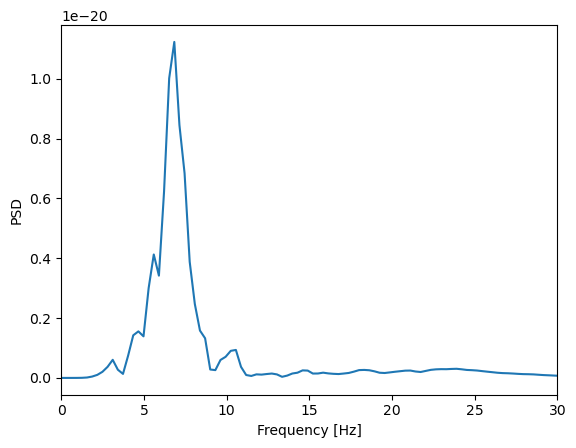

In [14]:
from scipy import signal
fff, Pxx = signal.periodogram(VEL_X[posX,posY,0,:],fs=1/PARA['dt'])
plt.plot(fff,Pxx)
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD')
plt.xlim(0,30)

## Filtering

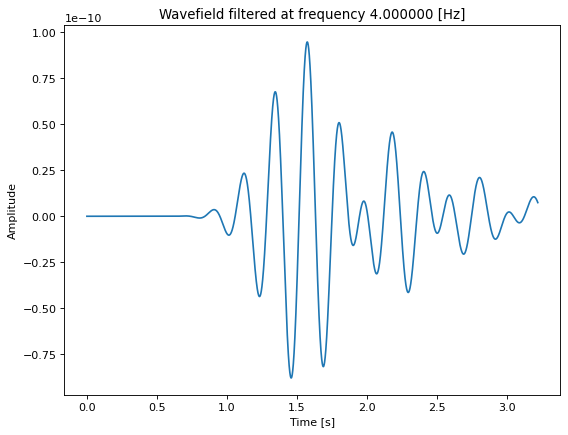

In [15]:
filtered = 'yes'

if filtered =='yes':
    # Bandbass Filter
    t = np.linspace(0,PARA['nt']*PARA['dt'], PARA['nt'])
    #t_att = np.linspace(0,PARA['nt_att']*PARA['dt_at'], PARA['nt_att'])

    #nn = np.arange(7.5,15.5,1)
    #mm = np.arange(8.5,16.5,1)
#     nn = np.array([0.01]) #0.01
#     mm = np.array([70]) #70
    nn = np.array([3]) #0.01
    mm = np.array([5]) #70
    f_BAND = np.array([nn,mm])
    # Include filter width feature to include on saved figures

    #depth_level = 100 #100:top, 0, bottom
    #depth = np.arange(0,nrz,PARA['dist_Z'])
    #depth = depth[::-1]

    U_filt_X = np.zeros((VEL_X.shape[0],VEL_X.shape[1], nrz, VEL_X.shape[3],len(f_BAND[0,:])))
    #U_filt_X_att = np.zeros((VEL_X.shape[0],VEL_X.shape[1], nrz, VEL_X_att.shape[3],len(f_BAND[0,:])))

    U_filt_Y = np.zeros((VEL_X.shape[0],VEL_X.shape[1], nrz, VEL_X.shape[3],len(f_BAND[0,:])))
    #U_filt_Y_att = np.zeros((VEL_X.shape[0],VEL_X.shape[1], nrz, VEL_X_att.shape[3],len(f_BAND[0,:])))

    U_filt_Z = np.zeros((VEL_X.shape[0],VEL_X.shape[1], nrz, VEL_X.shape[3],len(f_BAND[0,:])))
    #U_filt_Z_att = np.zeros((VEL_X.shape[0],VEL_X.shape[1], nrz, VEL_X_att.shape[3],len(f_BAND[0,:])))

    for dd in range(nrz):
        U_filterX, f_filt_cent = BP_filter(VEL_X[:,:,dd,:], f_BAND, PARA['dt'], posX, posY, t)
        #U_filterX_att, f_filt_cent = BP_filter(VEL_X_att[:,:,dd,:], f_BAND,PARA['dt_at'], posX, posY, t_att)
        U_filt_X[:,:,dd,:,:] = np.reshape(U_filterX, (U_filt_X[:,:,dd,:,:].shape))
        #U_filt_X_att[:,:,dd,:,:] = U_filterX_att

        U_filterY, f_filt_cent = BP_filter(VEL_Y[:,:,dd,:], f_BAND, PARA['dt'], posX, posY, t)
        #U_filterY_att, f_filt_cent = BP_filter(VEL_Y_att[:,:,dd,:], f_BAND,PARA['dt_at'], posX, posY, t_att)
        U_filt_Y[:,:,dd,:,:] = np.reshape(U_filterY, (U_filt_X[:,:,dd,:,:].shape))
        #U_filt_Y_att[:,:,dd,:,:] = U_filterY_att


        U_filterZ, f_filt_cent = BP_filter(VEL_Z[:,:,dd,:], f_BAND, PARA['dt'], posX, posY, t)
        #U_filterZ_att, f_filt_cent = BP_filter(VEL_Z_att[:,:,dd,:], f_BAND,PARA['dt_at'], posX, posY, t_att)
        U_filt_Z[:,:,dd,:,:] = np.reshape(U_filterZ, (U_filt_X[:,:,dd,:,:].shape))
        #U_filt_Z_att[:,:,dd,:,:] = U_filterZ_att

    nf = 0
    plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(t, U_filt_Z[posX,posY,posZ,:,nf])
    plt.title('Wavefield filtered at frequency %f [Hz]' %np.round(f_filt_cent[nf],2))
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')
    plt.show() 
    
    ll = len(f_filt_cent)
    
else:
    #for default so that plotting functions work
    nf = 0
    f_filt_cent = np.array([1])
    ll = len(f_filt_cent)

## Subsampling

In [16]:
# Spatial Subsampling of true model
# Get velocity, density and attenuation fields at receiver points

rxx=nr
ryy=nr
rzz = nrz
# rho_grad   = np.ones((rxx,ryy,rzz,ds_without_q.rho.values.shape[2])) 
# vs_sub     = np.ones((rxx,ryy,rzz,ds_without_q.vs.values.shape[2]))
# #qkappa_sub = np.ones((rxx,ryy,rzz,ds_with_q.qkappa.values.shape[2]))
# #qmu_sub    = np.ones((rxx,ryy,rzz,ds_with_q.qmu.values.shape[2]))
# vp_sub     = np.ones((rxx,ryy,rzz,ds_without_q.vp.values.shape[2]))

Rx = (np.linspace(PARA['rec_grid_pos'][0], PARA['rec_grid_pos'][2], nr).astype(int) -1 ).tolist()
Ry = (np.linspace(PARA['rec_grid_pos'][1], PARA['rec_grid_pos'][3], nr).astype(int) -1 ).tolist()
Rz = (np.linspace(PARA['rec_grid_pos'][4], PARA['rec_grid_pos'][5], nrz).astype(int) -1 ).tolist()
# Rx = np.linspace(PARA['rec_grid_pos'][0], PARA['rec_grid_pos'][2], nr).astype(int)  -1
# Ry = np.linspace(PARA['rec_grid_pos'][1], PARA['rec_grid_pos'][3], nr).astype(int)  -1
# Rz = np.linspace(PARA['rec_grid_pos'][4], PARA['rec_grid_pos'][5], nrz).astype(int) -1

vs_sub     = model_true.VS[:,:,Rz] #ds_without_q.vs.values[:,:,Rz] #model_true.VS[:,:,Rz] #ds_without_q.vs.values[:,:,Rz]
vs_sub     = vs_sub[Rx,:,:]
vs_sub     = np.asarray(vs_sub[:,Ry,:])
#vs_sub = vs_sub[:,:,::-1]
vp_sub     = model_true.VP[:,:,Rz] # ds_without_q.vp.values[:,:,Rz]  #model_true.VP[:,:,Rz] #ds_without_q.vp.values[:,:,Rz] 
vp_sub     = vp_sub[Rx,:,:]
vp_sub     = np.asarray(vp_sub[:,Ry,:])
#vp_sub = vp_sub[:,:,::-1]
rho_grad   = model_true.RHO[:,:,Rz] #ds_without_q.rho[:,:,Rz] #model_true.RHO[:,:,Rz] #ds_without_q.rho[:,:,Rz]
rho_grad   = rho_grad[Rx,:,:]
rho_grad   = rho_grad[:,Ry,:]
#rho_grad   = np.array(rho_grad[:,:,::-1])
mu = vs_sub**2 * rho_grad
lam = (vp_sub**2 * rho_grad) - (2*mu)

# vs_sub     = ds_without_q.vs.values[Rx[0]:Rx[-1]+1,Ry[0]:Ry[-1]+1,Rz[-1]:Rz[0]+1]
# vs_sub = vs_sub[:,:,::-1]
# vp_sub     = ds_without_q.vp.values[Rx[0]:Rx[-1]+1,Ry[0]:Ry[-1]+1,Rz[-1]:Rz[0]+1]
# vp_sub = vp_sub[:,:,::-1]
# rho_grad   = ds_without_q.rho.values[Rx[0]:Rx[-1]+1,Ry[0]:Ry[-1]+1,Rz[-1]:Rz[0]+1]
# rho_grad = rho_grad[:,:,::-1]
#qkappa_sub = ds_with_q.qkappa.values[Rx[0]:Rx[-1]+1,Ry[0]:Ry[-1]+1,Rz[-1]:Rz[0]+1]
#qkappa_sub = qkappa_sub[:,:,::-1]
#qmu_sub    = ds_with_q.qmu.values[Rx[0]:Rx[-1]+1,Ry[0]:Ry[-1]+1,Rz[-1]:Rz[0]+1]
#qmu_sub = qmu_sub[:,:,::-1]
c_sub      = 0.9*vs_sub
            
#Qp = 1/(((1-(vs_sub**2)/(vp_sub**2))*(1/qkappa_sub)) + ((vs_sub**2)/(vp_sub**2)*(1/qmu_sub)))
#Qs = qmu_sub   

In [17]:
# Potential temporal subsampling
sub = 5         
nt_sub  = np.ceil(PARA['nt']/sub).astype(int) 
dt_sub  = sub* PARA['dt']

In [18]:
sub_spXY = 1
dx = dx*sub_spXY
dy = dy*sub_spXY
sub_spZ  = 1
dz = dz*sub_spZ
dist_r=dist_r*sub_spXY
nr  = int(nr/sub_spXY)
rxx = int(rxx/sub_spXY)
ryy = int(ryy/sub_spXY)
nrz = int(nrz/sub_spZ)
rzz = int(rzz/sub_spZ)
nrx=rxx
nry=ryy


vp_sub = vp_sub[::sub_spXY,::sub_spXY,::sub_spZ]
vs_sub = vs_sub[::sub_spXY,::sub_spXY,::sub_spZ]
rho_grad = rho_grad[::sub_spXY,::sub_spXY,::sub_spZ]
mu = mu[::sub_spXY,::sub_spXY,::sub_spZ]
lam = lam[::sub_spXY,::sub_spXY,::sub_spZ]

c_sub = 0.9 * vs_sub

In [19]:
filtered

'yes'

In [20]:
if filtered == 'yes':

    u_field_X = np.zeros((rxx,ryy, rzz, nt_sub, ll))
    u_field_Y = np.zeros((rxx,ryy, rzz, nt_sub, ll))
    u_field_Z = np.zeros((rxx,ryy, rzz, nt_sub, ll))

    u_field_X =   U_filt_X[::sub_spXY,::sub_spXY,::sub_spZ,::sub,:]
    u_field_Y =   U_filt_Y[::sub_spXY,::sub_spXY,::sub_spZ,::sub,:]
    u_field_Z =   U_filt_Z[::sub_spXY,::sub_spXY,::sub_spZ,::sub,:]

    #nt_sub_att  = np.ceil(PARA['nt_att']/sub).astype(int) 
    #dt_sub_att  = sub* PARA['dt_at']
    #t_sub_att   = np.linspace(0,nt_sub_att*dt_sub_att, nt_sub_att)
    
    #u_field_X_att = np.zeros((rxx,ryy, rzz, nt_sub, ll))
    #u_field_Y_att = np.zeros((rxx,ryy, rzz, nt_sub, ll))
    #u_field_Z_att = np.zeros((rxx,ryy, rzz, nt_sub, ll))

    #u_field_X_att =   U_filt_X_att[:,:,:,::sub,:]
    #u_field_Y_att =   U_filt_Y_att[:,:,:,::sub,:]
    #u_field_Z_att =   U_filt_Z_att[:,:,:,::sub,:]

else:
    VEL_X     = np.reshape(OUT.velocity_x.data, (nrx,nry,nrz,PARA['nt'],1))
    #VEL_X_att = np.reshape(OUT_ATT.velocity_x.data, (nrx,nry,nrz,PARA['nt_att'],1))

    VEL_Y     = np.reshape(OUT.velocity_y.data, (nrx,nry,nrz,PARA['nt'],1))
    #VEL_Y_att = np.reshape(OUT_ATT.velocity_y.data, (nrx,nry,nrz,PARA['nt_att'],1))

    VEL_Z     = np.reshape(OUT.velocity_z.data, (nrx,nry,nrz,PARA['nt'],1))
    #VEL_Z_att = np.reshape(OUT_ATT.velocity_z.data, (nrx,nry,nrz,PARA['nt_att'],1))
    
    u_field_X = np.zeros((rxx,ryy, rzz, nt_sub,1))
    u_field_Y = np.zeros((rxx,ryy, rzz, nt_sub,1))
    u_field_Z = np.zeros((rxx,ryy, rzz, nt_sub,1))

    u_field_X =   VEL_X[:,:,:,::sub,:]
    u_field_Y =   VEL_Y[:,:,:,::sub,:]
    u_field_Z =   VEL_Z[:,:,:,::sub,:]

    #nt_sub_att  = np.ceil(PARA['nt_att']/sub).astype(int) 
    #dt_sub_att  = sub* PARA['dt_at']

    #u_field_X_att = np.zeros((rxx,ryy, rzz, nt_sub,1))
    #u_field_Y_att = np.zeros((rxx,ryy, rzz, nt_sub,1))
    #u_field_Z_att = np.zeros((rxx,ryy, rzz, nt_sub,1))

    #u_field_X_att =   VEL_X_att[:,:,:,::sub,:]
    #u_field_Y_att =   VEL_Y_att[:,:,:,::sub,:]
    #u_field_Z_att =   VEL_Z_att[:,:,:,::sub,:]

1628.9145976720276


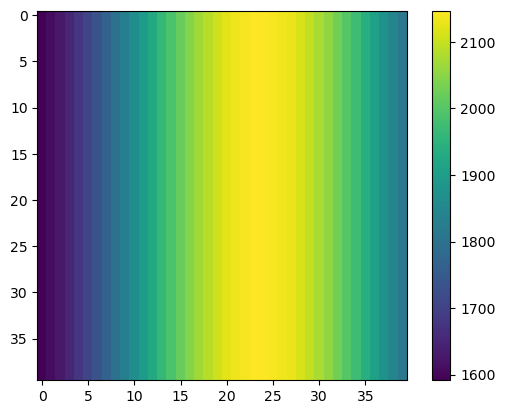

In [21]:
plt.imshow(vp_sub[:,:,0])
plt.colorbar()
print(vp_sub[posX,posY,0])

In [22]:
dt_sub

0.000787006378965997

# Gradient Calc (velocity field)


## FD spatial & temporal derivatives for internal nodes

In [23]:
N = PARA['recs_depth'] * nr**2#PARA['recs_surf']

VEL_X = np.reshape(u_field_X[:,:,:,:,:], (N,nt_sub,u_field_X[:,:,:,:,:].shape[4]))
VEL_Y = np.reshape(u_field_Y[:,:,:,:,:], (N,nt_sub,u_field_Y[:,:,:,:,:].shape[4]))
VEL_Z = np.reshape(u_field_Z[:,:,:,:,:], (N,nt_sub,u_field_Z[:,:,:,:,:].shape[4]))

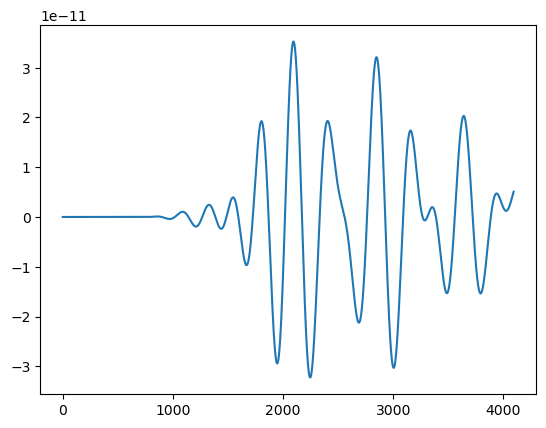

In [24]:
plt.plot(VEL_Z[100,:])

In [25]:
# Temporal derivatives, order options: 2, 4, 8

order = 2 
    
# dttv1, dttv2, dttv3 = dttv(VEL_X, VEL_Y, VEL_Z, PARA['dt'], PARA['nt'], order)
dttv1, dttv2, dttv3 = dttv(VEL_X, VEL_Y, VEL_Z, dt_sub, nt_sub, order)

In [26]:
nr

40

In [27]:
dttv1 = np.reshape(dttv1, (nrx,nry,nrz,nt_sub, u_field_X.shape[4]))
dttv2 = np.reshape(dttv2, (nrx,nry,nrz,nt_sub, u_field_Y.shape[4]))
dttv3 = np.reshape(dttv3, (nrx,nry,nrz,nt_sub, u_field_Z.shape[4]))

In [28]:
VEL_X = np.reshape(VEL_X, (nrx,nry,nrz,nt_sub, u_field_X.shape[4]))
VEL_Y = np.reshape(VEL_Y, (nrx,nry,nrz,nt_sub, u_field_Y.shape[4]))
VEL_Z = np.reshape(VEL_Z, (nrx,nry,nrz,nt_sub, u_field_Z.shape[4]))

## Calculate Spatial Derivatives via Classical FD stencil 
- ### cross-shaped, regular grid

#### First derivatives

In [29]:
order=2
VEL_X_gradX, VEL_Y_gradX, VEL_Z_gradX, VEL_X_gradY, VEL_Y_gradY, VEL_Z_gradY, VEL_X_gradZ, VEL_Y_gradZ, VEL_Z_gradZ \
= _1st_DER(VEL_X, VEL_Y, VEL_Z, dx, dy, dz, nrx, nry, nrz,order)

##### 2nd derivatives

In [30]:
VEL_X_gradXX, VEL_Y_gradXX, VEL_Z_gradXX, VEL_X_gradYY, VEL_Y_gradYY, VEL_Z_gradYY, VEL_X_gradZZ,\
VEL_Y_gradZZ, VEL_Z_gradZZ, VEL_X_gradXY, VEL_Y_gradXY, VEL_Z_gradXY, VEL_X_gradYX, VEL_Y_gradYX,\
VEL_Z_gradYX, VEL_X_gradYZ, VEL_Y_gradYZ, VEL_Z_gradYZ, VEL_X_gradXZ, VEL_Y_gradXZ, VEL_Z_gradXZ \
= _2nd_DER(VEL_X, VEL_Y, VEL_Z, dx, dy, dz, nrx, nry, nrz,order)

In [31]:
# To be added:
#- ### GFD, regular or irregular grid
#- ### 2002 formulas, regular grid 

- #### Get estimate at the Free Surface

In [32]:
# plt.plot(VEL_Z_gradZZ_FDnotFS[2,2])
# #plt.plot(-VEL_Z_gradZZ_fwdFD[2,2])
# plt.plot(-VEL_Z_gradZZ[2,2,1])
# # # #plt.plot(VEL_Z_gradZZ[2,2,2])

In [33]:
# plt.plot(VEL_Z_gradYZ_FDnotFS[2,2])
# plt.plot(VEL_Z_gradYZ[2,2,1])
# #plt.plot(VEL_X_gradYZ[2,2,2])

In [34]:
VEL_X_gradZ_FreeSurf, VEL_Y_gradZ_FreeSurf, VEL_Z_gradZ_FreeSurf = \
FS_VERT_1stder_atFS(vp_sub[:,:,0], vs_sub[:,:,0], VEL_X_gradX[:,:,0,:,nf], VEL_Y_gradY[:,:,0,:,nf], VEL_Z_gradY[:,:,0,:,nf], \
                    VEL_Z_gradX[:,:,0,:,nf])

VEL_X_gradZ_FDnotFS, VEL_Y_gradZ_FDnotFS, VEL_Z_gradZ_FDnotFS =\
FD_VERT_1stder_notFS(VEL_X[:,:,1,:,nf], VEL_Y[:,:,1,:,nf], VEL_Z[:,:,1,:,nf], VEL_X[:,:,0,:,nf], VEL_Y[:,:,0,:,nf],\
                     VEL_Z[:,:,0,:,nf], dz)

VEL_X_gradZZ_FDnotFS, VEL_Y_gradZZ_FDnotFS, VEL_Z_gradZZ_FDnotFS =\
FD_VERT_2ndder_notFS(VEL_X_gradZ_FDnotFS, VEL_Y_gradZ_FDnotFS, VEL_Z_gradZ_FDnotFS,\
                   VEL_X_gradZ_FreeSurf, VEL_Y_gradZ_FreeSurf, VEL_Y_gradZ_FreeSurf, dz)

VEL_X_gradZZ_FreeSurf, VEL_Y_gradZZ_FreeSurf, VEL_Z_gradZZ_FreeSurf = \
FS_VERT_2ndder_atFS(dttv1[:,:,0,:,nf], dttv2[:,:,0,:,nf], dttv3[:,:,0,:,nf], vp_sub[:,:,0], vs_sub[:,:,0], VEL_Z_gradXX[:,:,0,:,nf], \
                    VEL_Z_gradYY[:,:,0,:,nf], VEL_Y_gradXX[:,:,0,:,nf], VEL_X_gradXX[:,:,0,:,nf], VEL_Y_gradXY[:,:,0,:,nf],\
                    VEL_X_gradYX[:,:,0,:,nf], VEL_Y_gradYY[:,:,0,:,nf], VEL_X_gradYY[:,:,0,:,nf])

L11, L12, L13 = LAX(dz, VEL_X_gradZZ_FreeSurf, VEL_Y_gradZZ_FreeSurf, VEL_Z_gradZZ_FreeSurf)

VEL_X_gradZ_LAX, VEL_Y_gradZ_LAX, VEL_Z_gradZ_LAX =\
FD_VERT_1stder_LAX(-L11, -L12, -L13, VEL_X_gradZ_FDnotFS, VEL_Y_gradZ_FDnotFS, VEL_Z_gradZ_FDnotFS)

# VEL_X_gradZZ_fwdFD,VEL_Y_gradZZ_fwdFD,VEL_Z_gradZZ_fwdFD,\
# VEL_X_gradYZ_FDnotFS, VEL_Y_gradYZ_FDnotFS, VEL_Z_gradYZ_FDnotFS, VEL_X_gradXZ_FDnotFS, VEL_Y_gradXZ_FDnotFS, VEL_Z_gradXZ_FDnotFS =\
# mixed_FD_VERT_2nd_notFS(VEL_X[:,:,1,:,nf], VEL_Y[:,:,1,:,nf], VEL_Z[:,:,1,:,nf],\
#                         VEL_X[:,:,2,:,nf], VEL_Y[:,:,2,:,nf], VEL_Z[:,:,2,:,nf],\
#                         VEL_X[:,:,3,:,nf], VEL_Y[:,:,3,:,nf], VEL_Z[:,:,3,:,nf],\
#                         VEL_X[:,:,0,:,nf], VEL_Y[:,:,0,:,nf],\
#                      VEL_Z[:,:,0,:,nf], dz,dy,dx, nry,nrx)

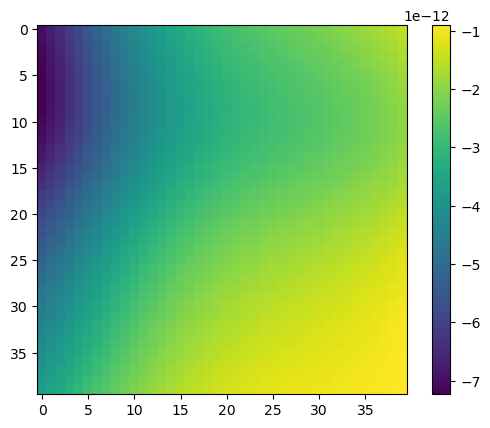

In [35]:
plt.imshow(VEL_Z_gradZ_FDnotFS[:,:,:].sum(2))
plt.colorbar()

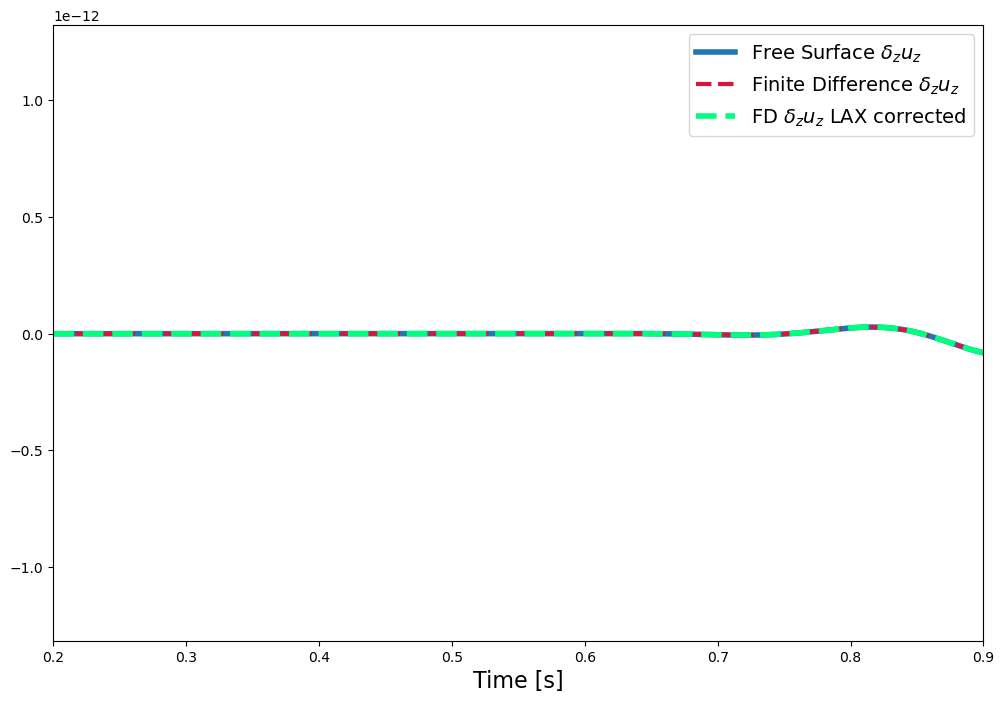

In [36]:
#select time_range
a = 0#100#700#700#1000
b = nt_sub#400#3000#nt_sub#2000#nt_sub
t_sub = np.linspace(a*dt_sub,b*dt_sub,b-a)

plt.figure(figsize=(12,8))
plt.plot(t_sub,VEL_Z_gradZ_FreeSurf[posX, posY,a:b], label=r'Free Surface $\delta_{z}u_{z}$',linewidth=4,color='tab:blue')
plt.plot(t_sub,VEL_Z_gradZ_FDnotFS[posX, posY, a:b], label=r'Finite Difference $\delta_{z}u_{z}$ ',linewidth=3,color='crimson', linestyle='--')
plt.plot(t_sub,VEL_Z_gradZ_LAX[posX, posY,a:b], label=r'FD $\delta_{z}u_{z}$ LAX corrected',linewidth=4, linestyle='--',color='springgreen')
plt.xlabel('Time [s]', fontsize=16)
plt.xlim([0.2,0.9])
#plt.xlim([1,1.9])
#plt.xlim([0.0,0.4])
#plt.ylim([-5.5*10e-12,9.5*10e-12])
mpl.rcParams['xtick.labelsize']=16
mpl.rcParams['ytick.labelsize']=16 
plt.legend(fontsize=14)

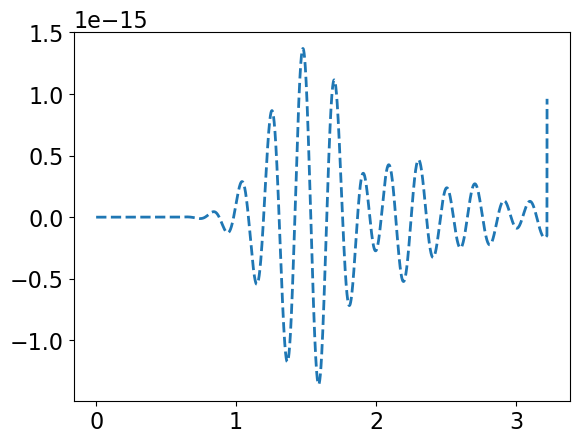

In [37]:
plt.plot(t_sub,VEL_Z_gradZ_LAX[posX, posY,a:b]-VEL_Z_gradZ_FreeSurf[posX, posY,a:b], label=r'FD $\delta_{z}v_{z}$ LAX corrected',linewidth=2, linestyle='--')

In [38]:
#break

## Substitute gradients in Wave Equations
- ### 3D Elastic Wave Equation

In [39]:
posZ=0
print('x-position:', posX)
print('y-position:', posY)
print('z-position:', posZ)

x-position: 4
y-position: 2
z-position: 0


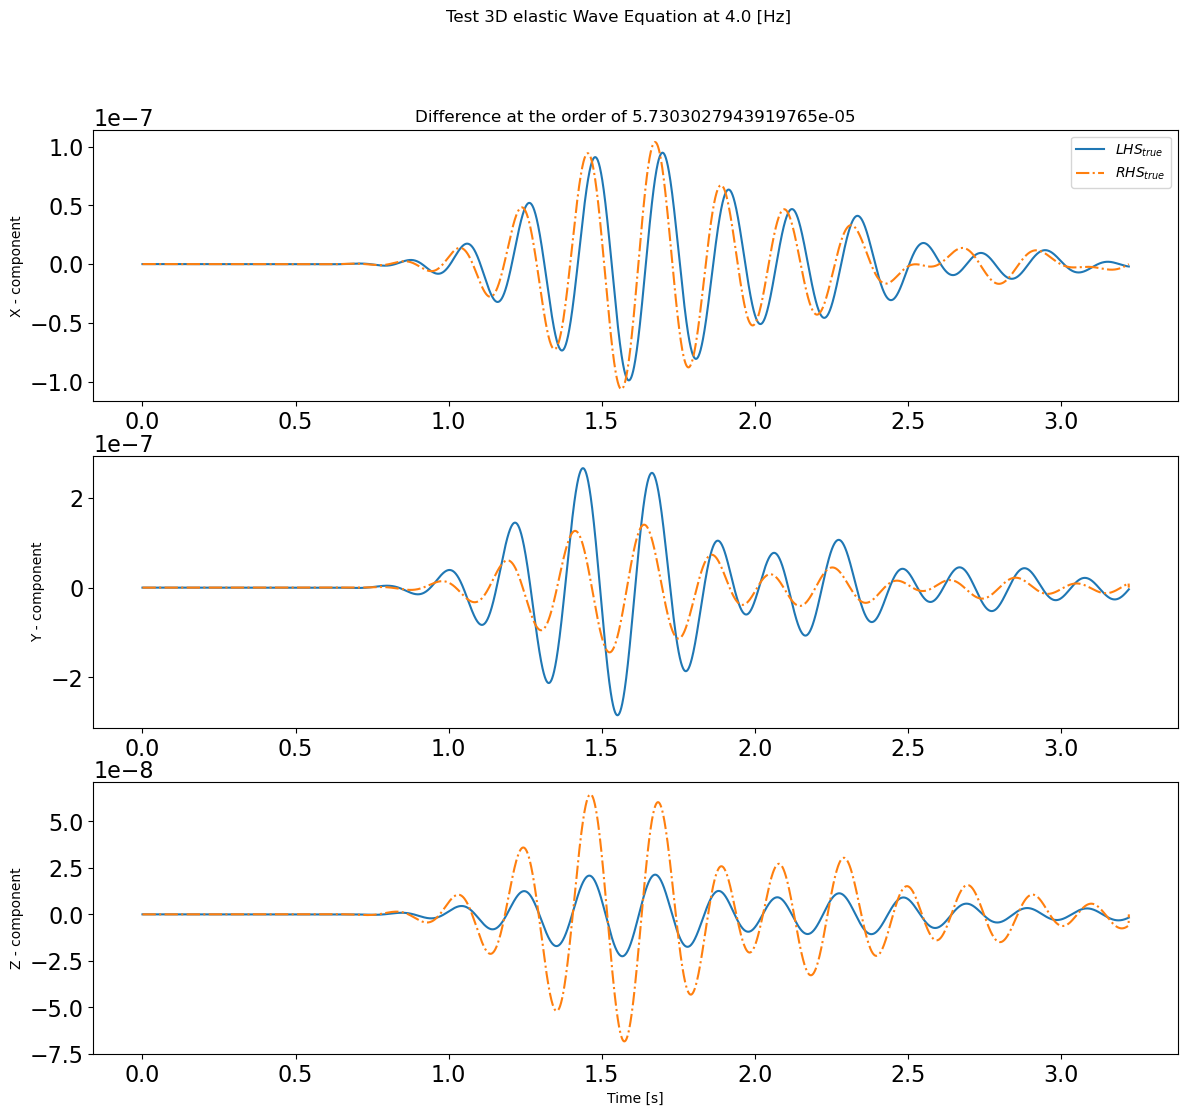

In [40]:
#nt_sub
nt_range = b-a
t_range  = np.linspace(a*dt_sub,nt_range*dt_sub, nt_range)

rotROT1, rotROT2, rotROT3, gradDIV1, gradDIV2, gradDIV3 = \
WE_3D_ELASTIC(VEL_X_gradXX, VEL_Y_gradXX, VEL_Z_gradXX, VEL_X_gradYY, VEL_Y_gradYY, VEL_Z_gradYY, VEL_X_gradZZ,\
VEL_Y_gradZZ, VEL_Z_gradZZ, VEL_X_gradXY, VEL_Y_gradXY, VEL_Z_gradXY, VEL_X_gradYX, VEL_Y_gradYX,\
VEL_Z_gradYX, VEL_X_gradYZ, VEL_Y_gradYZ, VEL_Z_gradYZ, VEL_X_gradXZ, VEL_Y_gradXZ, VEL_Z_gradXZ, vp_sub, vs_sub,\
dttv1, dttv2, dttv3, posX,posY, posZ, nf, f_filt_cent, filtered,t_range)

- #### at the Free Surface (corrected)


In [41]:
#select time_range
a = 0
b = nt_sub
nt_range = b-a
t_range  = np.linspace(a*dt_sub,nt_range*dt_sub, nt_range)

A1, B1, A2, B2, A3, B3 = LINeq_VAR(-dz, VEL_X_gradX[:,:,0,a:b,nf], VEL_Y_gradY[:,:,0,a:b,nf], VEL_Z_gradZ_FDnotFS[:,:,a:b], VEL_Z_gradXX[:,:,0,a:b,nf], \
                                   VEL_Z_gradYY[:,:,0,a:b,nf], VEL_Z_gradY[:,:,0,a:b,nf], VEL_Y_gradZ_FDnotFS[:,:,a:b], VEL_Y_gradXX[:,:,0,a:b,nf], \
                                   VEL_Y_gradYY[:,:,0,a:b,nf], VEL_X_gradYX[:,:,0,a:b,nf], VEL_Z_gradX[:,:,0,a:b,nf], VEL_X_gradZ_FDnotFS[:,:,a:b], \
                                   VEL_X_gradXX[:,:,0,a:b,nf], VEL_X_gradYY[:,:,0,a:b,nf], VEL_Y_gradXY[:,:,0,a:b,nf])

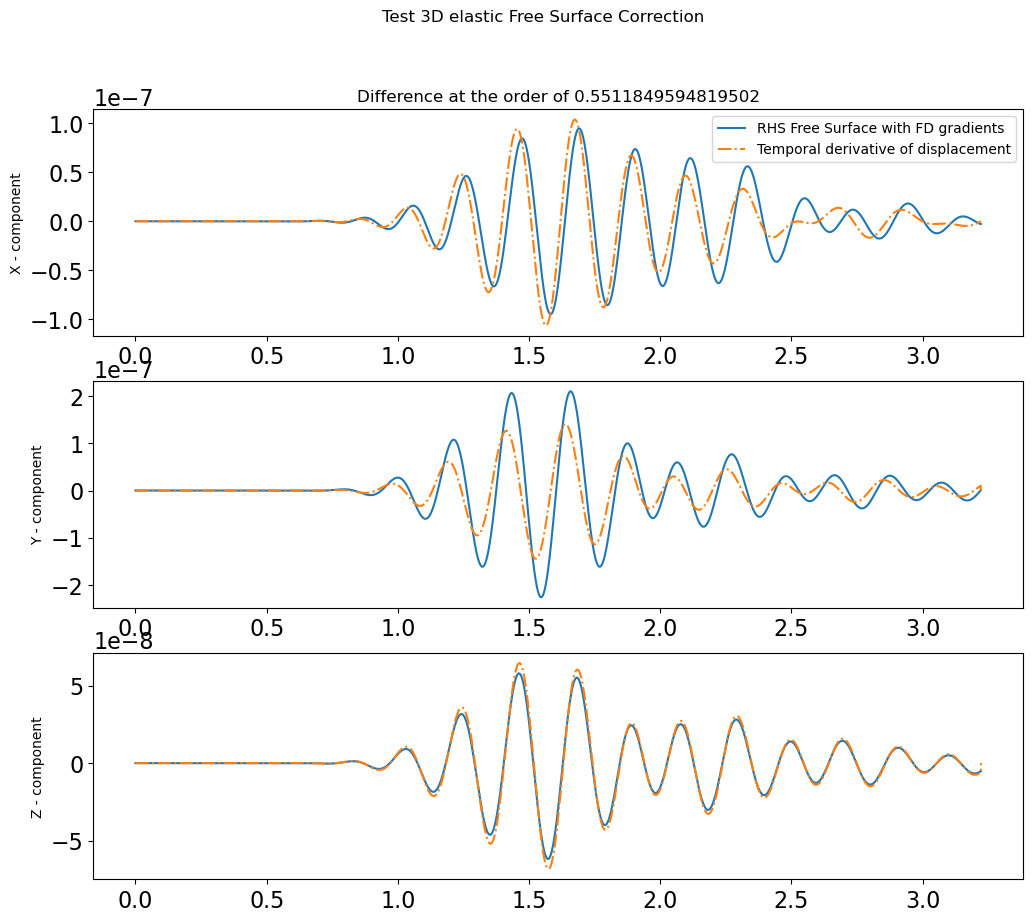

In [42]:
rhs_eq3FS, rhs_eq2FS, rhs_eq1FS = WE_3D_ELASTIC_FreeSurf(A1, A2, A3, B1, B2, B3, vp_sub[:,:,0], vs_sub[:,:,0], dttv1[:,:,0,a:b], dttv2[:,:,0,a:b], dttv3[:,:,0,a:b],\
                       posX,posY,t_range)

In [43]:
A3_test = (2/-dz  * (VEL_X_gradX[:,:,0,:,0] + VEL_Y_gradY[:,:,0,:,0] + VEL_Z_gradZ_FDnotFS) )   -  (VEL_Z_gradXX[:,:,0,:,0] + VEL_Z_gradYY[:,:,0,:,0])
B3_test = (4/-dz  * (VEL_X_gradX[:,:,0,:,0] + VEL_Y_gradY[:,:,0,:,0]))  -  2*(VEL_Z_gradXX[:,:,0,:,0] + VEL_Z_gradYY[:,:,0,:,0])
RHS_test = ((vp_sub[:,:,0,np.newaxis]**2) *A3_test) - ((vs_sub[:,:,0,np.newaxis]**2) *B3_test)

(200.0, 2000.0)

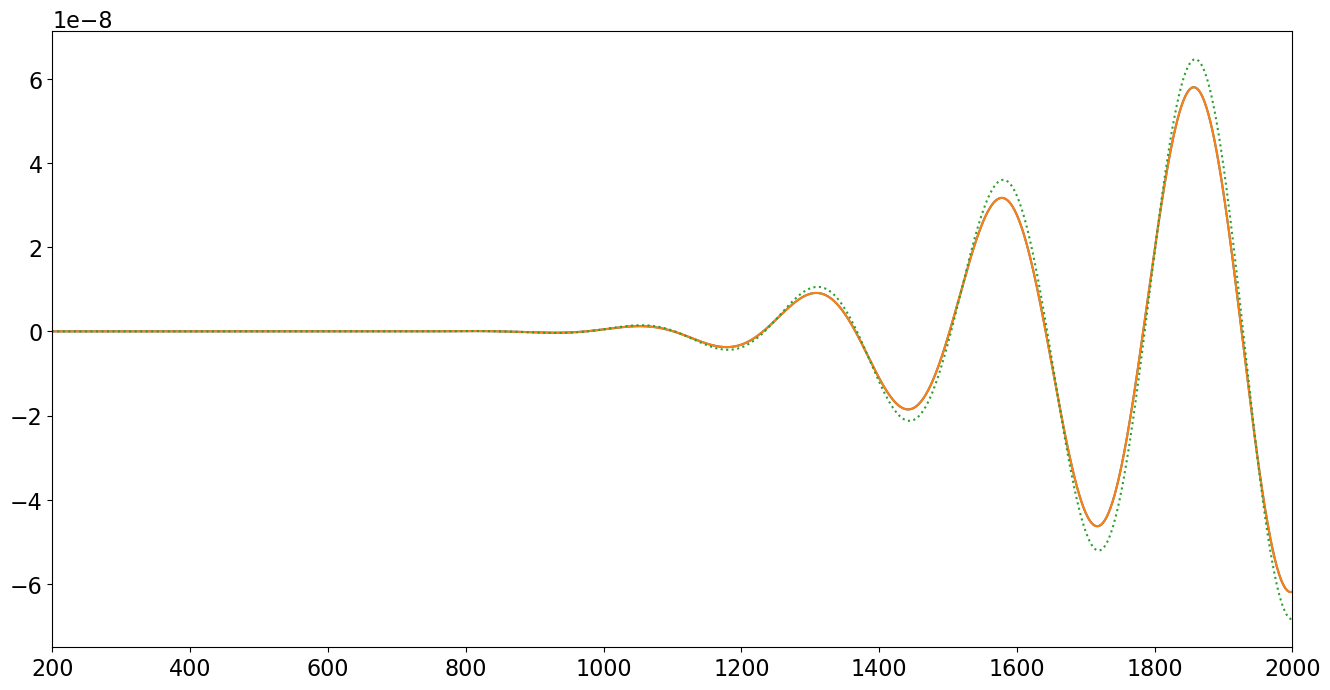

In [44]:
plt.figure(figsize=(16,8))
plt.plot(RHS_test[posX,posY])
plt.plot(rhs_eq3FS[posX,posY])
plt.plot(dttv3[posX,posY,0], linestyle=':')
plt.xlim([200,2000])

(0.0, 0.4)

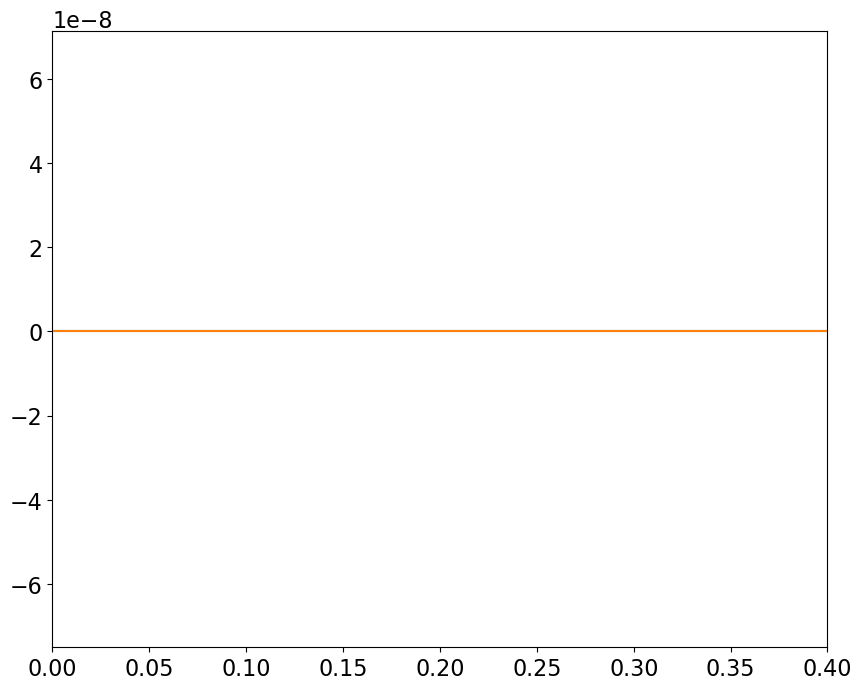

In [45]:
time_vec = np.linspace(dt_sub,3-dt_sub,nt_sub-2)

fig,ax1=plt.subplots(figsize=(10,8))
ax1.plot(time_vec,rhs_eq3FS[posX,posY,1:-1])
ax1.plot(time_vec,dttv3[posX,posY,0,1:-1,0])

ax1.set_xlim([0.3,1.8])
ax1.set_xlim([0.0,0.4])
#ax1.set_ylim([-0.002,0.003])

In [46]:
#break

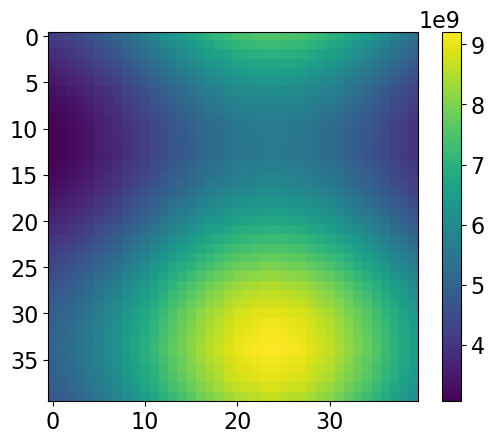

In [47]:
frac = (4*(vs_sub**2)) / (3*(vp_sub**2))
Ke = 2 * rho_grad * vs_sub**2 * (1 - frac)
Ka = rho_grad * vp_sub**2
Ke = Ke.values
Ka = Ka.values
plt.imshow(Ka[:,:,0])
plt.colorbar()

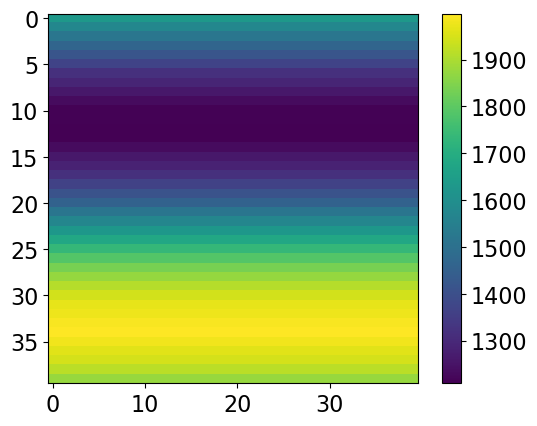

In [48]:
plt.imshow(rho_grad[:,:,0])
plt.colorbar()

(0.0, 3000.0)

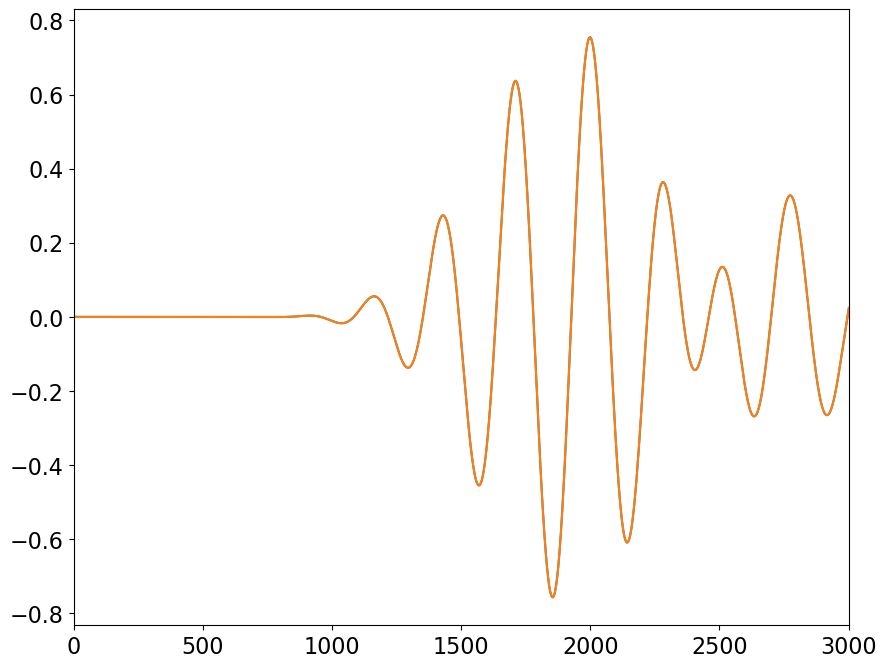

In [49]:
Pe = Ke[:,:,0, np.newaxis] *(VEL_X_gradX[:,:,0,:,0] + VEL_Y_gradY[:,:,0,:,0])
Pa = Ka[:,:,0, np.newaxis] *(VEL_X_gradX[:,:,0,:,0] + VEL_Y_gradY[:,:,0,:,0])

plt.figure(figsize=(10,8))
plt.plot(Pe[2,2,:]/np.max(Pe))
plt.plot(Pa[2,2,:]/np.max(Pa))
plt.xlim([0,3000])

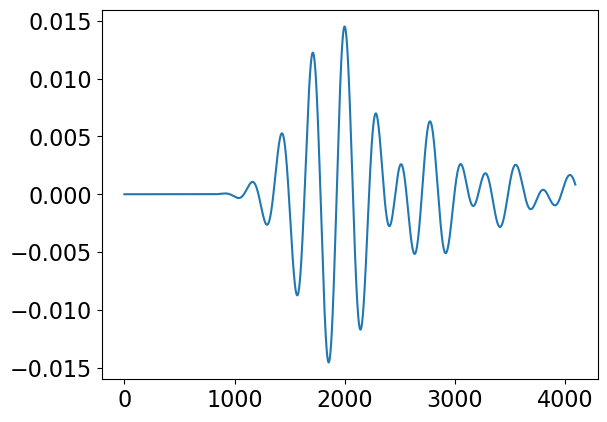

In [50]:
plt.plot(Pa[2,2])

In [51]:
rho_gradd=rho_grad.values

RHS_acc = (1/-dz) * Pa * (2- ((4*vs_sub[:,:,0,np.newaxis]**2)/(vp_sub[:,:,0,np.newaxis]**2))) * (1/rho_gradd[:,:,0,np.newaxis]) 
RHS_acc_without = (1/-dz) * Pa * (2- ((4*vs_sub[:,:,0,np.newaxis]**2)/vp_sub[:,:,0,np.newaxis]**2)) #* (1/rho_gradd[:,:,0,np.newaxis]) 

(0.0, 1000.0)

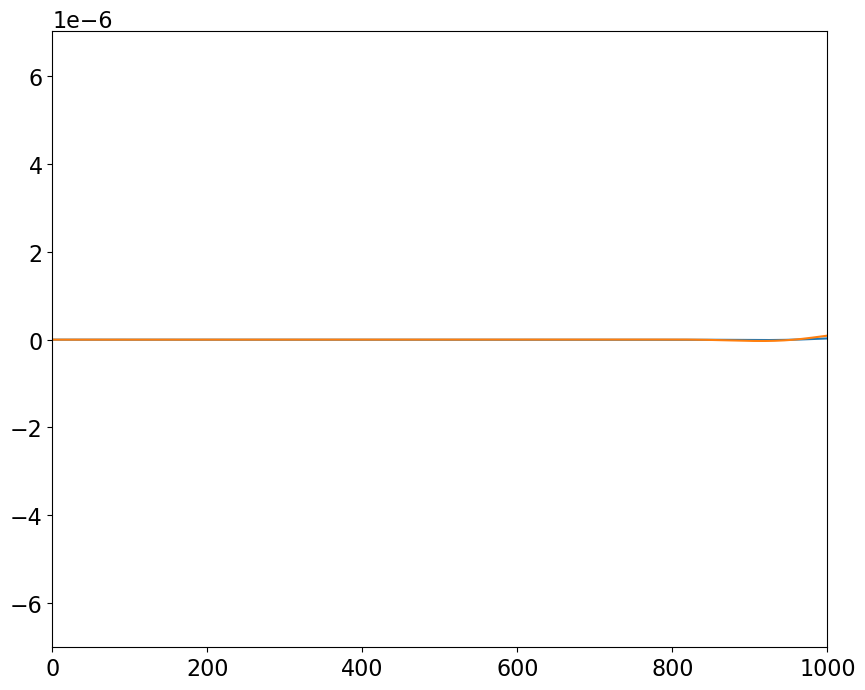

In [52]:
ratio1 = (vp_sub**2) / (vs_sub**2)
ratio2 = (8* vs_sub**2) / (3* vp_sub**2)

RHS_without =  (1/-dz) * Pe * (ratio1[:,:,0,np.newaxis]+ratio2[:,:,0,np.newaxis]-(10/3)) #* (1/rho_gradd[:,:,0,np.newaxis]) 
RHS =  (1/-dz) * Pe * (ratio1[:,:,0,np.newaxis]+ratio2[:,:,0,np.newaxis]-(10/3)) * (1/rho_gradd[:,:,0,np.newaxis]) 
#RHS_without =  (1/dz) * (1/0.37)*Pe * (ratio1[:,:,0,np.newaxis]+ratio2[:,:,0,np.newaxis]-(10/3)) #* (1/rho_gradd[:,:,0,np.newaxis]) 
#RHS =  (1/dz) * (1/0.37)*Pe * (ratio1[:,:,0,np.newaxis]+ratio2[:,:,0,np.newaxis]-(10/3)) * (1/rho_gradd[:,:,0,np.newaxis]) 
#RHS_without =  (1/dz) * (1/0.37)*Pe * (2- ((4*vs_sub[:,:,0,np.newaxis]**2)/vp_sub[:,:,0,np.newaxis]**2)) #* (1/rho_gradd[:,:,0,np.newaxis]) 
#RHS =  (1/dz) * (1/0.37)*Pe * (2- ((4*vs_sub[:,:,0,np.newaxis]**2)/vp_sub[:,:,0,np.newaxis]**2)) * (1/rho_gradd[:,:,0,np.newaxis]) 


plt.figure(figsize=(10,8))
plt.plot(RHS[2,2,:])
plt.plot(RHS_acc[2,2,:])
plt.xlim([0,1000])

In [53]:
lam_GRAD_X_true  = np.empty((nr, nr))
lam_GRAD_Y_true  = np.empty((nr, nr))

for l in range(1,nr-1):
                lam_GRAD_X_true[l, :] = (lam[l+1,:,0] - lam[l-1,:,0])/(dist_r*2)
for k in range(1,nr-1):
                lam_GRAD_Y_true[:,k] = (lam[:,k+1,0] -  lam[:,k-1,0])/(dist_r*2)
lam_GRAD_true = lam_GRAD_X_true + lam_GRAD_Y_true


mu_GRAD_X_true  = np.empty((nr, nr))
mu_GRAD_Y_true  = np.empty((nr, nr))

for l in range(1,nr-1):
                mu_GRAD_X_true[l, :] = (mu[l+1,:,0] - mu[l-1,:,0])/(dist_r*2)
for k in range(1,nr-1):
                mu_GRAD_Y_true[:,k] = (mu[:,k+1,0] -  mu[:,k-1,0])/(dist_r*2)
mu_GRAD_true = mu_GRAD_X_true + mu_GRAD_Y_true


INHOM1 = (2* VEL_X_gradX) + VEL_X_gradY + VEL_Y_gradX
INHOM2 = (2* VEL_Y_gradY) + VEL_X_gradY + VEL_Y_gradX

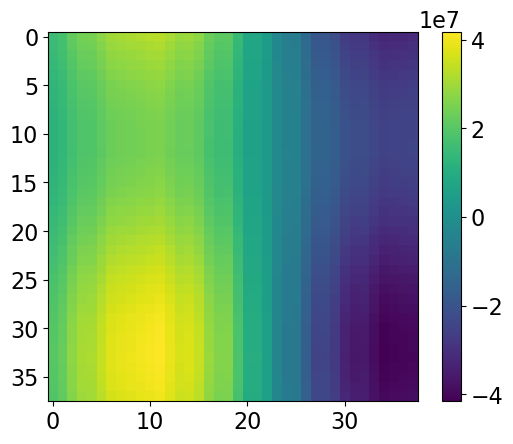

In [54]:
plt.imshow(mu_GRAD_Y_true[1:-1,1:-1])
plt.colorbar()

(200.0, 3000.0)

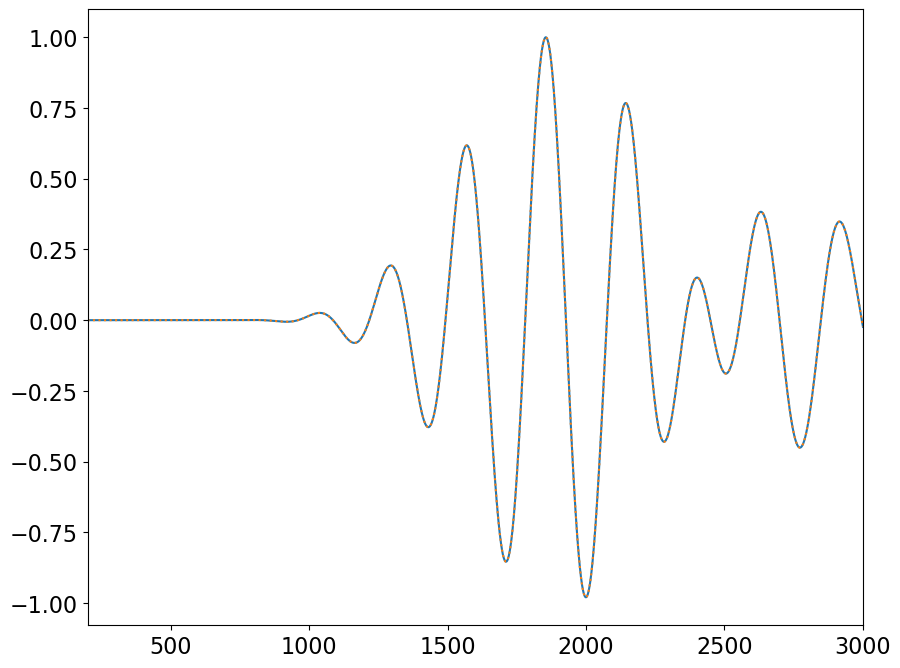

In [55]:
term1 = dttv3[:,:,0,:,0]
term2 = (2/-dz) * (vp_sub[:,:,0, np.newaxis]**2) * VEL_Z_gradZ_FDnotFS
term3 = (vp_sub[:,:,0, np.newaxis]**2 - (2 * vs_sub[:,:,0, np.newaxis]**2)) * (VEL_Z_gradXX[:,:,0,:,0] + VEL_Z_gradYY[:,:,0,:,0])
term_inhom = mu_GRAD_Y_true[:,:,np.newaxis] * INHOM1[:,:,0,:,0] + mu_GRAD_X_true[:,:,np.newaxis] * INHOM2[:,:,0,:,0]
LHS = term1 - term2 + term3
LHS_inhom = term1 - term2 + term3 - term_inhom

xx=5
yy=5
plt.figure(figsize=(10,8))
plt.plot(LHS[xx,yy,:]/np.max(LHS[xx,yy,:]))
#plt.plot(LHS_inhom[xx,yy,:]/np.max(LHS_inhom[xx,yy,:]), color='crimson')

#plt.plot(RHS[xx,yy,:]/np.max(RHS[xx,yy,:]))
plt.plot(RHS_acc[xx,yy,:]/np.max(RHS_acc[xx,yy,:]),linestyle=':')
#plt.plot(RHS_without[xx,yy,:]/np.max(RHS_without[xx,yy,:]))
plt.xlim([200,3000])

(200.0, 3000.0)

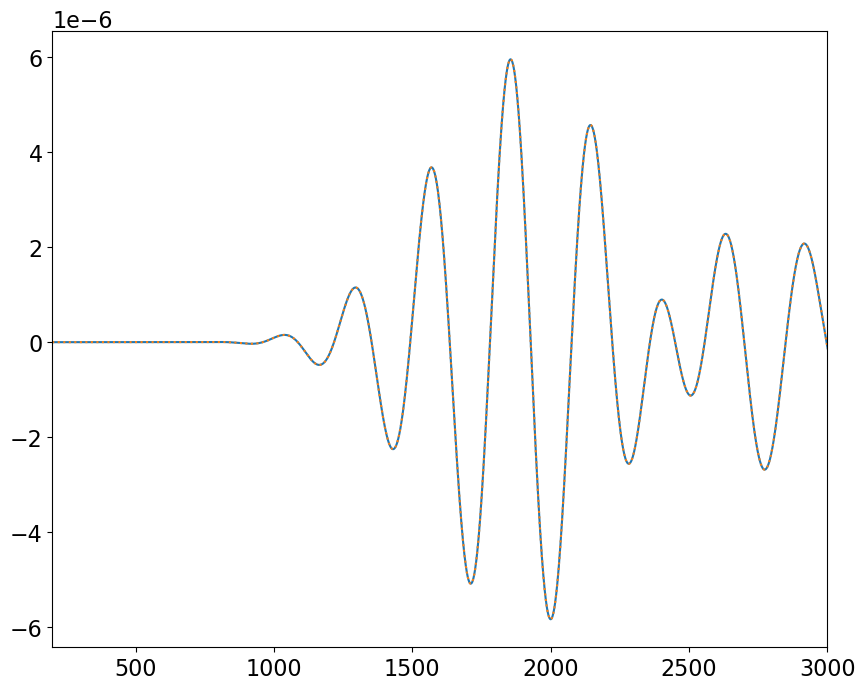

In [56]:
plt.figure(figsize=(10,8))
plt.plot(LHS[xx,yy,:])
#plt.plot(LHS_inhom[xx,yy,:])
#plt.plot(RHS[xx,yy,:])
#plt.plot(RHS_without[xx,yy,:])
plt.plot(RHS_acc[xx,yy,:],linestyle=':')
#plt.plot(RHS_acc_without[xx,yy,:])

plt.xlim([200,3000])

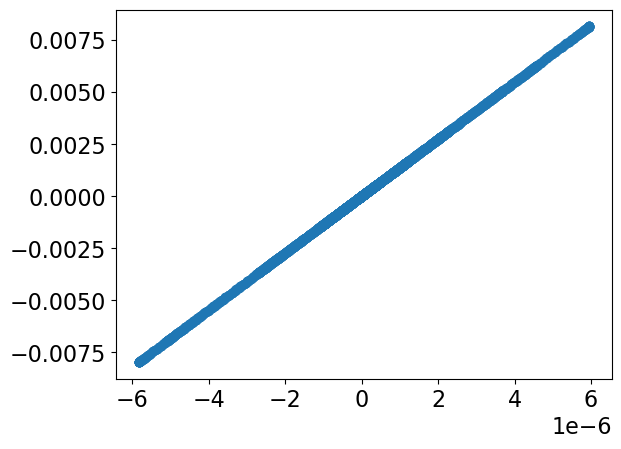

In [57]:
plt.scatter(LHS[xx,yy,:],RHS_acc_without[xx,yy,:])

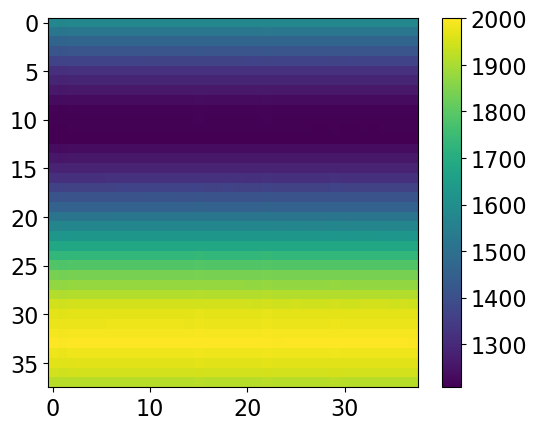

In [58]:
from FCT_LinearRegression import *

rho_, m, r_sq = LinReg_rho_surf(LHS[1:-1,1:-1], RHS_acc_without[1:-1,1:-1], nt_sub, ll, (nrx-2)**2, nrx, nry,order)
plt.imshow(rho_)
plt.colorbar()

In [59]:
rho_.shape

(38, 38, 1)

In [60]:
print(np.min(rho_))
print(np.max(rho_))

1207.7340259122218
2001.455448015902


In [61]:
print(np.min(rho_grad.values[1:-1,1:-1,0]))
print(np.max(rho_grad.values[1:-1,1:-1,0]))

1209.2057226434677
1998.0222997814337


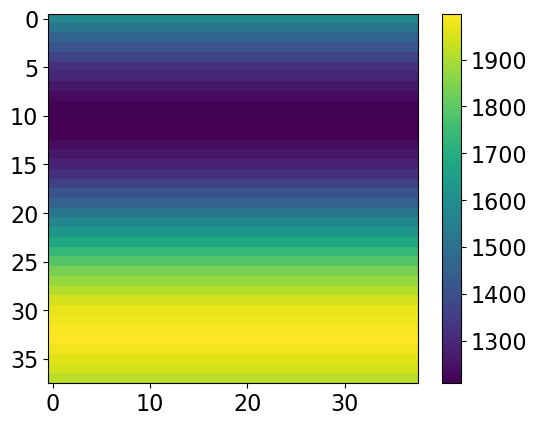

In [62]:
plt.imshow(rho_grad.values[1:-1,1:-1,0])
plt.colorbar()

In [63]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns

#Colorbar Tests

colors = ['ivory',"wheat",'burlywood','tab:brown']
cmap1 = LinearSegmentedColormap.from_list("mycmap", colors)

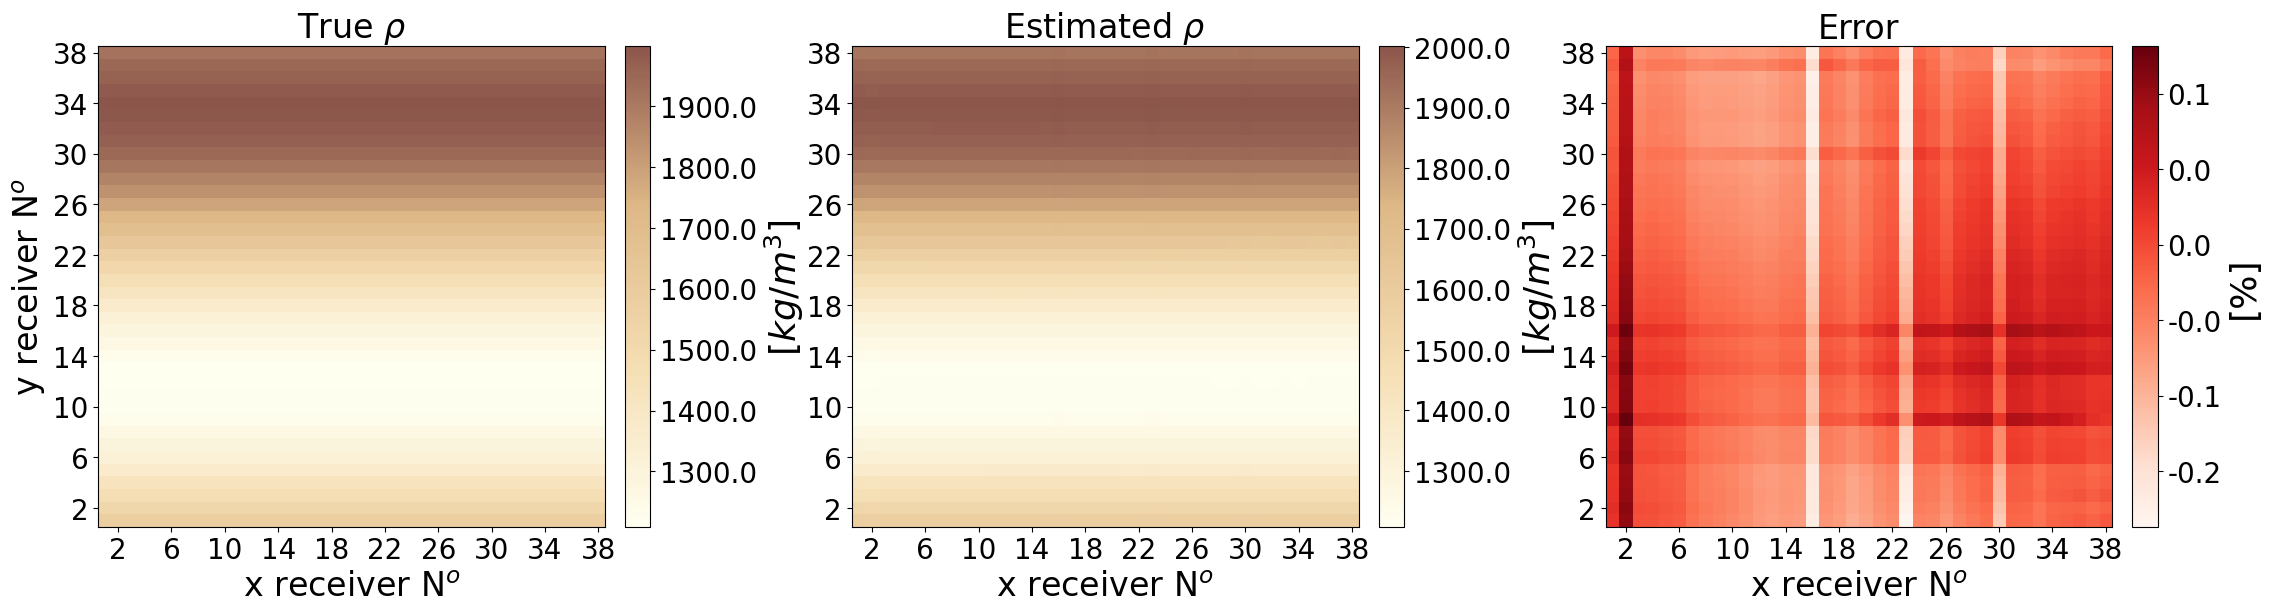

In [64]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(24,8),ncols=3,gridspec_kw={'width_ratios': [1,1,1]})
fig.tight_layout(pad=10.0)

############im1=ax1.imshow(abs(gradient_rho_TRUE[0,1:-1,1:-1]) ,vmin=np.min(abs(gradient_rho_TRUE[0,1:-1,1:-1])), vmax=np.max(abs(gradient_rho_TRUE[0,1:-1,1:-1])), aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])
im1=ax1.imshow(rho_grad.values[1:-1,1:-1,0] ,vmin=np.min(rho_grad.values[1:-1,1:-1,0]), vmax=np.max(rho_grad.values[1:-1,1:-1,0]),cmap=cmap1, aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])
#im1=ax1.imshow((rho_GRAD_true[1:-1,1:-1]) ,vmin=np.min((rho_GRAD_true[1:-1,1:-1])), vmax=np.max((rho_GRAD_true[1:-1,1:-1])), aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])

divider = make_axes_locatable(ax1)
ax11 = divider.append_axes('right', size='5%', pad=0.2)
cbar = plt.colorbar(im1, format='%.1f',cax=ax11)
cbar.set_label(label=r'$[kg/m^{3}]$',size=26)
ax1.set_xlabel(r'x receiver N$^{o}$',fontsize=24)
ax1.set_ylabel(r'y receiver N$^{o}$',fontsize=24)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)
ax1.set_title(r'True $\rho$',fontsize=24)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)
        
        
#im2=ax2.imshow(abs(store_grad_X[error_minX[0][0],1:-1,1:-1]) ,vmin=np.min(abs(rho_GRAD_X_true[1:-1,1:-1])), vmax=np.max(abs(rho_GRAD_X_true[1:-1,1:-1])),  aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])
im2=ax2.imshow(rho_,vmin=np.min(rho_), vmax=np.max(rho_),  aspect='auto',cmap=cmap1, interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])
#im2=ax2.imshow((store_grad[min_MIS[0][0],1:-1,1:-1]),origin='lower' ,vmin=np.min((rho_GRAD_true[1:-1,1:-1])), vmax=np.max((rho_GRAD_true[1:-1,1:-1])),  aspect='auto', interpolation='none', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])

divider = make_axes_locatable(ax2)
ax22 = divider.append_axes('right', size='5%', pad=0.2)
cbar = plt.colorbar(im2, format='%.1f',cax=ax22)
cbar.set_label(label=r'$[kg/m^{3}]$',size=26)
ax2.set_xlabel(r'x receiver N$^{o}$',fontsize=24)
#ax2.set_ylabel(r'y receiver N$^{o}$',fontsize=20)
ax2.xaxis.set_tick_params(labelsize=20)
ax2.yaxis.set_tick_params(labelsize=20)
ax2.set_title(r'Estimated $\rho$',fontsize=24)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)

#im2=ax2.imshow(np.log(J_ACC[min_MIS_MEAN[0][0],1:-1,1:-1]),vmin=np.min(np.log(J_ACC[min_MIS_MEAN[0][0],1:-1,1:-1])), vmax=np.max(np.log(J_ACC[min_MIS_MEAN[0][0],1:-1,1:-1])), cmap='bwr',aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])
# im3=ax3.imshow(errorX[error_minX[0][0],:,:] ,vmin=-np.max(errorX[error_minX[0][0],:,:]), vmax=np.max(errorX[error_minX[0][0],:,:]), cmap='bwr',aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])
#im3=ax3.imshow((diff[error_min[0][0],:,:]) ,vmin=np.min((diff[error_min[0][0],:,:])), vmax=-np.min((diff[error_min[0][0],:,:])), cmap='bwr',aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])
#im3=ax3.imshow(abs(error[min_MIS[0][0],:,:]) ,vmin=np.min(abs(error[min_MIS[0][0],:,:])), vmax=np.max(abs(error[min_MIS[0][0],:,:])), cmap='Reds',aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])
#im3=ax3.imshow(abs(errorX_ABS[min_MIS[0][0],:,:]) ,vmin=np.min(abs(errorX_ABS[min_MIS[0][0],:,:])), vmax=np.max(abs(errorX_ABS[min_MIS[0][0],:,:])), cmap=Reds,aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])
diff=100*(rho_grad.values[1:-1,1:-1,0]-rho_[:,:,0])/rho_grad.values[1:-1,1:-1,0]
im3=ax3.imshow(diff ,vmin=np.min(diff), vmax=np.max(diff), cmap='Reds',aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])

#im3=ax3.imshow(np.log(abs(errorX_ABS[min_MIS[0][0],:,:])) ,vmin=np.min(np.log(abs(errorX_ABS[min_MIS[0][0],:,:]))), vmax=np.max(np.log(abs(errorX_ABS[min_MIS[0][0],:,:]))), cmap='Reds',aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])

#im3=ax3.imshow((errorX[min_MIS[0][0],:,:]) ,vmin=np.min((errorX[error_min[0][0],:,:])), vmax=np.max((errorX[error_min[0][0],:,:])), cmap='Reds',aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])
#im3=ax3.imshow((rho_GRAD_true[1:-1,1:-1]-store_grad[min_MIS[0][0],1:-1,1:-1]), cmap='Reds',aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])#vmin=np.min((error[error_min[0][0],:,:])), vmax=np.max((error[error_min[0][0],:,:])), cmap='Reds',aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])
#im3=ax3.imshow(np.log(J_ACC[min_MIS[0][0],1:-1,1:-1]),origin='lower' ,vmin=np.min(np.log(J_ACC[min_MIS[0][0],1:-1,1:-1])), vmax=np.max(np.log(J_ACC[min_MIS[0][0],1:-1,1:-1])),  cmap='Reds',aspect='auto', interpolation='none', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])

#im3=ax3.imshow((error_rel[error_min[0][0],:,:]) ,vmin=np.min((error_rel[error_min[0][0],:,:])), vmax=np.max((error_rel[error_min[0][0],:,:])), cmap='bwr',aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])

#im3=ax3.imshow(np.log(abs(error[error_min[0][0],:,:])) ,vmin=np.min(np.log(abs(error[error_min[0][0],:,:]))), vmax=np.max(np.log(abs(error[error_min[0][0],:,:]))), cmap='Reds',aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])

divider = make_axes_locatable(ax3)
ax33 = divider.append_axes('right', size='5%', pad=0.2)
cbar = plt.colorbar(im3, format='%.1f',cax=ax33)
cbar.set_label(label='[%]',size=26)
#cbar.set_label(label=r'$[\frac{kg}{m^{3}}]$',size=26)
ax3.set_title('Error',fontsize=24)
#ax3.set_title('|Absolute Error|',fontsize=24)

ax3.set_xlabel(r'x receiver N$^{o}$',fontsize=24)
#plt.ylabel(r'y receiver N$^{o}$',fontsize=20)
ax3.xaxis.set_tick_params(labelsize=20)
ax3.yaxis.set_tick_params(labelsize=20)
start, end = ax1.get_xlim()
ax3.xaxis.set_ticks(np.arange(start+1.5, end+0.5, 4))
ax1.xaxis.set_ticks(np.arange(start+1.5, end+0.5, 4))
ax3.yaxis.set_ticks(np.arange(start+1.5, end+0.5, 4))
ax1.yaxis.set_ticks(np.arange(start+1.5, end+0.5, 4))

start, end = ax2.get_xlim()
ax2.xaxis.set_ticks(np.arange(start+1.5, end, 4))
ax2.yaxis.set_ticks(np.arange(start+1.5, end+0.5, 4))
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)
        
# ax1.set_xticks([1,3,5,7,9,11,13,15,17])
# ax1.set_xticklabels(['2','4','6','8','10','12','14','16','18'])
# ax1.set_yticks([1,3,5,7,9,11,13,15,17])
# ax1.set_yticklabels(['2','4','6','8','10','12','14','16','18'])

# ax2.set_xticks([1,3,5,7,9,11,13,15,17])
# ax2.set_xticklabels(['2','4','6','8','10','12','14','16','18'])
# ax2.set_yticks([1,3,5,7,9,11,13,15,17])
# ax2.set_yticklabels(['2','4','6','8','10','12','14','16','18'])

# ax3.set_xticks([1,3,5,7,9,11,13,15,17])
# ax3.set_xticklabels(['2','4','6','8','10','12','14','16','18'])
# ax3.set_yticks([1,3,5,7,9,11,13,15,17])
# ax3.set_yticklabels(['2','4','6','8','10','12','14','16','18'])

plt.show() 

In [65]:
# MISFIT
len_test = 250 #80# 120

stx = 10
sty = 10
rho_test = np.linspace(rho_grad.values[stx,sty,0]-(0.8*rho_grad.values[stx,sty,0]),rho_grad.values[stx,sty,0]+(0.8*rho_grad.values[stx,sty,0]),len_test)
rho_test = np.append(rho_test, rho_grad.values[stx,sty,0])
rho_test = np.sort(rho_test)

vp_test = np.linspace(vp_sub[stx,sty,0]-(0.25*vp_sub[stx,sty,0]),vp_sub[stx,sty,0]+(0.25*vp_sub[stx,sty,0]),len_test+50)
vp_test = np.append(vp_test, vp_sub[stx,sty,0])
vp_test = np.sort(vp_test)
vs_test = np.linspace(vs_sub[stx,sty,0]-(0.2*vs_sub[stx,sty,0]),vs_sub[stx,sty,0]+(0.2*vs_sub[stx,sty,0]),len_test+50)
vs_test = np.append(vs_test, vs_sub[stx,sty,0])
vs_test = np.sort(vs_test)
#vs_test = vp_test/ np.sqrt(3)
ratio_test = (4*(vs_test**2)) / (vp_test**2)

xv_ratio, yv_rho = np.meshgrid(ratio_test, rho_test, indexing='ij')
xv_vp, yv_rho = np.meshgrid(vp_test, rho_test, indexing='ij')
xv_vs = xv_vp/ np.sqrt(3)

Text(0, 0.5, 'ratio')

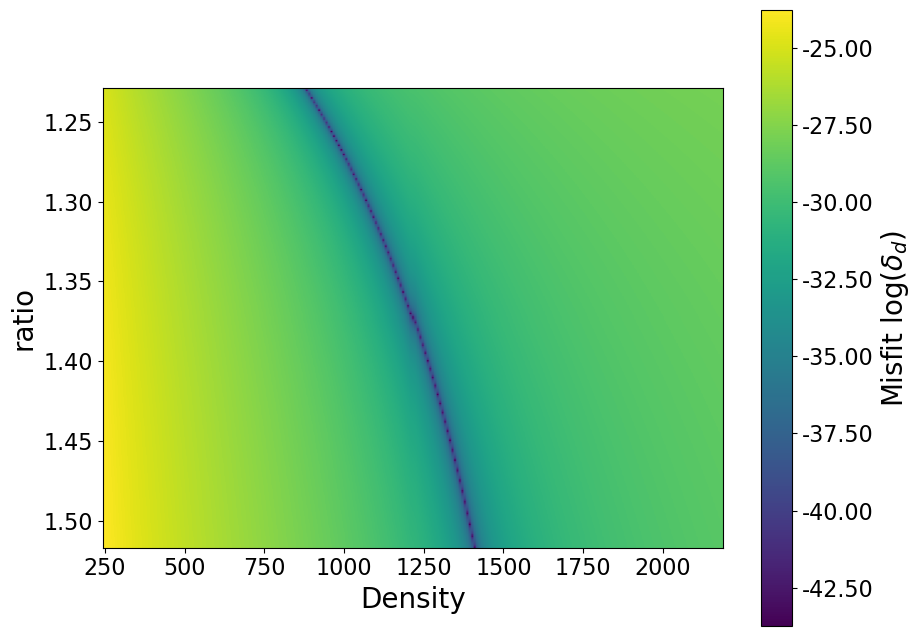

In [66]:
RHS_acc_test = (1/-dz) * Pa[np.newaxis,np.newaxis,stx,sty,:] * (2- (xv_ratio[:,:,np.newaxis])) * (1/yv_rho[:,:,np.newaxis]) 

term1 = dttv3[stx,sty,0,:,0]
term2 = (2/-dz) * (vp_sub[:,:,0, np.newaxis]**2) * VEL_Z_gradZ_FDnotFS
term3 = (vp_sub[:,:,0, np.newaxis]**2 - (2 * vs_sub[:,:,0, np.newaxis]**2)) * (VEL_Z_gradXX[:,:,0,:,0] + VEL_Z_gradYY[:,:,0,:,0])
#term2 = (2/dz) * (xv_vp[:,:,np.newaxis]**2) * VEL_Z_gradZ_FDnotFS[np.newaxis,np.newaxis,stx,sty,:]
#term3 = (xv_vp[:,:,np.newaxis]**2 - (2 * xv_vs[:,:,np.newaxis]**2)) * (VEL_Z_gradXX[np.newaxis,np.newaxis,stx,sty,0,:,0] + VEL_Z_gradYY[np.newaxis,np.newaxis,stx,sty,0,:,0])
# RHS_acc_test = RHS_acc_test + term2 - term3
LHS_test = term1 - term2 + term3
misfit_test = np.log(((RHS_acc_test-LHS_test[stx,sty])**2).sum(2) / (nt_sub-2))

plt.figure(figsize=(10,8))
im=plt.imshow(misfit_test,extent=[rho_test[0],rho_test[-1],ratio_test[0],ratio_test[-1]],cmap='viridis', aspect=5000)#, vmin=-7.1, vmax=-0.2)#4

cbar = plt.colorbar(im, format='%.2f')
cbar.set_label(label=r'Misfit log($\delta_{d}$)',size=20)
plt.xlabel(r'Density', fontsize=20)
plt.ylabel(r'ratio', fontsize=20)

In [67]:
LHS_test[stx,sty]==LHS[stx,sty]

array([ True,  True,  True, ...,  True,  True,  True])

In [68]:
RHS_acc_test[-1,-1]==RHS_acc[stx,sty]

array([ True,  True,  True, ..., False, False, False])

In [69]:
print(rho_[stx,sty][0])
print(vp_sub[stx,sty,0])
print(rho_grad.values[stx,sty,0])

1213.6570654314496
1863.912927261796
1215.23299239278


In [70]:
ind_min = np.argwhere(misfit_test==np.min(misfit_test))
print(ind_min)
print(ratio_test[ind_min[0][0]])
print( (4*(vs_test[ind_min[0][0]]**2)) / (vp_test[ind_min[0][0]]**2))
print(rho_test[ind_min[0][1]])

[[133 121]]
1.348509549851677
1.348509549851677
1187.9024511984044


Text(0, 0.5, 'Signal amplitude')

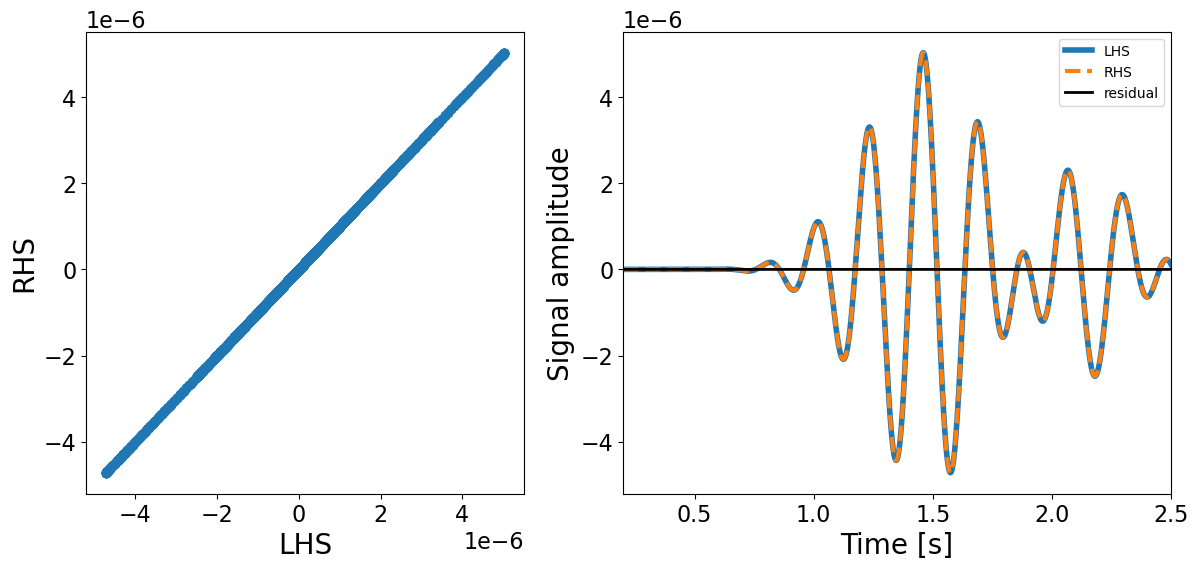

In [71]:
t=np.linspace(0,nt_sub*dt_sub,nt_sub)
fig,(ax1,ax2)=plt.subplots(figsize=(14,6),ncols=2, gridspec_kw={'width_ratios': [0.8,1]})
ax1.scatter(LHS_test[stx,sty],RHS_acc_test[ind_min[0][0],ind_min[0][1]])
ax1.set_xlabel('LHS',fontsize=20)
ax1.set_ylabel('RHS',fontsize=20)

ax2.plot(t,LHS_test[stx,sty], label='LHS',linewidth=4)
ax2.plot(t,RHS_acc_test[ind_min[0][0],ind_min[0][1]],label='RHS', linestyle='--',linewidth=3)
ax2.plot(t,RHS_acc_test[ind_min[0][0],ind_min[0][1]]-LHS_test[stx,sty],label='residual',linewidth=2, color='black')
#plt.plot(RHS_acc_test[-1,-1])
plt.legend()
plt.xlim([0.2,2.5])
ax2.set_xlabel('Time [s]',fontsize=20)
ax2.set_ylabel('Signal amplitude',fontsize=20)

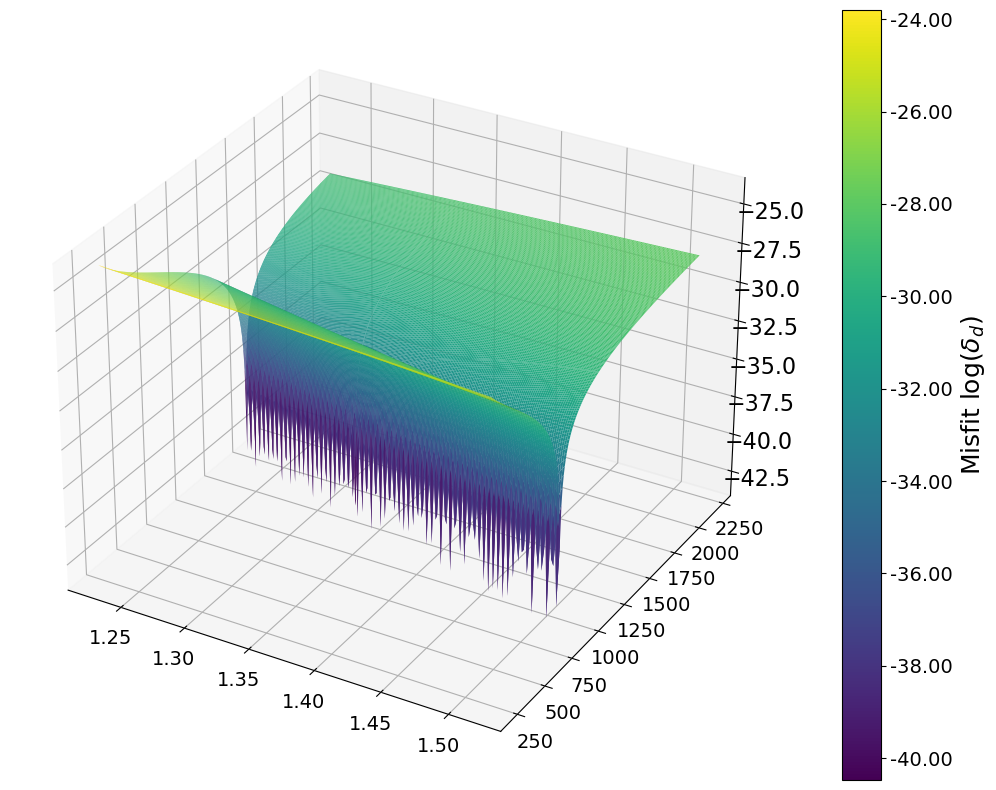

In [72]:
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111,projection='3d')
im=ax.plot_surface((xv_ratio),(yv_rho),misfit_test,  cmap='viridis',rcount=misfit_test.shape[0], ccount=misfit_test.shape[1], zorder=10)
cbar = plt.colorbar(im, format='%.2f')
cbar.set_label(label=r'Misfit log($\delta_{d}$)',size=18)

ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
for t in cbar.ax.get_yticklabels():
         t.set_fontsize(14)
plt.show()

In [73]:
# MISFIT
len_test = 100 #80# 120

rho_test = np.linspace(rho_grad.values[stx,sty,0]-(0.8*rho_grad.values[stx,sty,0]),rho_grad.values[stx,sty,0]+(0.8*rho_grad.values[stx,sty,0]),len_test)
rho_test = np.append(rho_test, rho_grad.values[stx,sty,0])
rho_test = np.sort(rho_test)

vp_test = np.linspace(vp_sub[stx,sty,0]-(0.4*vp_sub[stx,sty,0]),vp_sub[stx,sty,0]+(0.4*vp_sub[stx,sty,0]),len_test+50)
vp_test = np.append(vp_test, vp_sub[stx,sty,0])
vp_test = np.sort(vp_test)
#vs_test = np.linspace(vs_sub[stx,sty,0]-(0.5*vs_sub[stx,sty,0]),vs_sub[stx,sty,0]+(0.5*vs_sub[stx,sty,0]),len_test+50)
#vs_test = np.append(vs_test, vs_sub[stx,sty,0])
#vs_test = np.sort(vs_test)
vs_test = vp_test/ 1.735367396007023# np.sqrt(3)

xv_vp, yv_rho = np.meshgrid(vp_test, rho_test, indexing='ij')
xv_vs = xv_vp/ np.sqrt(3)

Text(-0.4, 0.1, 'True $ \\rho$ : 1215.2 $\\frac{kg}{m^{3}}$ \nEstimated $  \\rho$ : 1215.2 $\\frac{kg}{m^{3}}$')

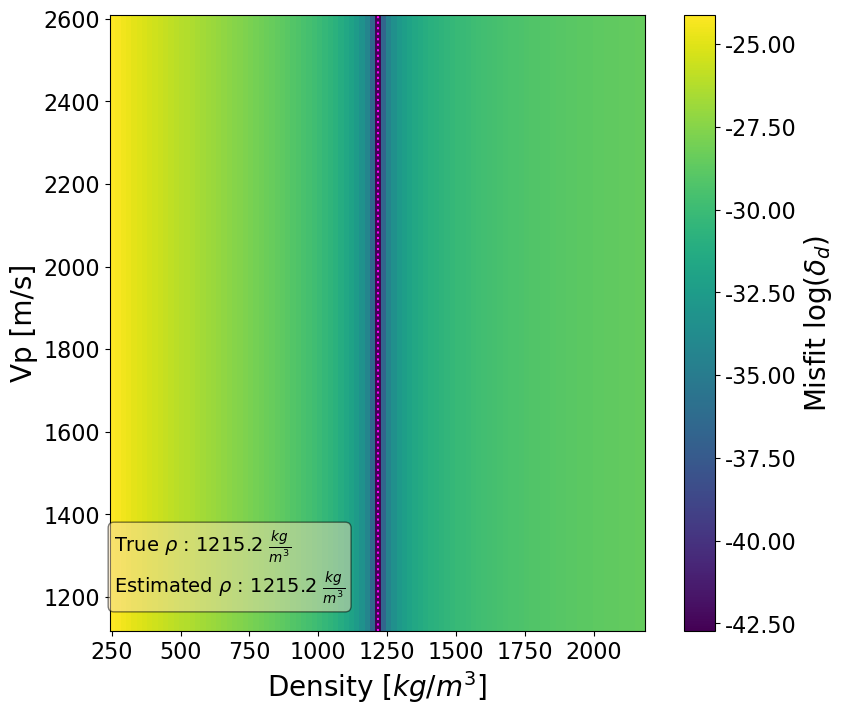

In [74]:
RHS_acc_test = (1/-dz) * Pa[np.newaxis,np.newaxis,stx,sty,:] * (2- ((4*xv_vs[:,:,np.newaxis]**2)/xv_vp[:,:,np.newaxis]**2)) * (1/yv_rho[:,:,np.newaxis]) 

term1 = dttv3[:,:,0,:,0]
term2 = (2/-dz) * (vp_sub[:,:,0, np.newaxis]**2) * VEL_Z_gradZ_FDnotFS
term3 = (vp_sub[:,:,0, np.newaxis]**2 - (2 * vs_sub[:,:,0, np.newaxis]**2)) * (VEL_Z_gradXX[:,:,0,:,0] + VEL_Z_gradYY[:,:,0,:,0])
#term2 = (2/dz) * (xv_vp[:,:,np.newaxis]**2) * VEL_Z_gradZ_FDnotFS[np.newaxis,np.newaxis,stx,sty,:]
#term3 = (xv_vp[:,:,np.newaxis]**2 - (2 * xv_vs[:,:,np.newaxis]**2)) * (VEL_Z_gradXX[np.newaxis,np.newaxis,stx,sty,0,:,0] + VEL_Z_gradYY[np.newaxis,np.newaxis,stx,sty,0,:,0])
# RHS_acc_test = RHS_acc_test + term2 - term3
LHS_test = term1 - term2 + term3
misfit_test = np.log(((RHS_acc_test-LHS_test[stx,sty])**2).sum(2) / (nt_sub-2))

ind_min2 = np.argwhere(misfit_test==np.min(misfit_test))
ind_min2[0]

plt.figure(figsize=(10,8))
im=plt.imshow(misfit_test,extent=[rho_test[0],rho_test[-1],vp_test[0],vp_test[-1]],cmap='viridis', aspect=1.5)#, vmin=-7.1, vmax=-0.2)#4
plt.plot(np.ones((vp_test.shape))*rho_grad.values[stx,sty,0],vp_test, color='magenta', linestyle=':')
cbar = plt.colorbar(im, format='%.2f')
cbar.set_label(label=r'Misfit log($\delta_{d}$)',size=20)
plt.xlabel(r'Density [$kg/m^{3}$]', fontsize=20)
plt.ylabel(r'Vp [m/s]', fontsize=20)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(-0.4, 0.1, r'True $ \rho$ : ' + str(np.round(rho_grad.values[stx,sty,0],1)) + r' $\frac{kg}{m^{3}}$' ' \n' r'Estimated $  \rho$ : '+ str(np.round(rho_test[ind_min2[0][1]],1)) + r' $\frac{kg}{m^{3}}$', transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

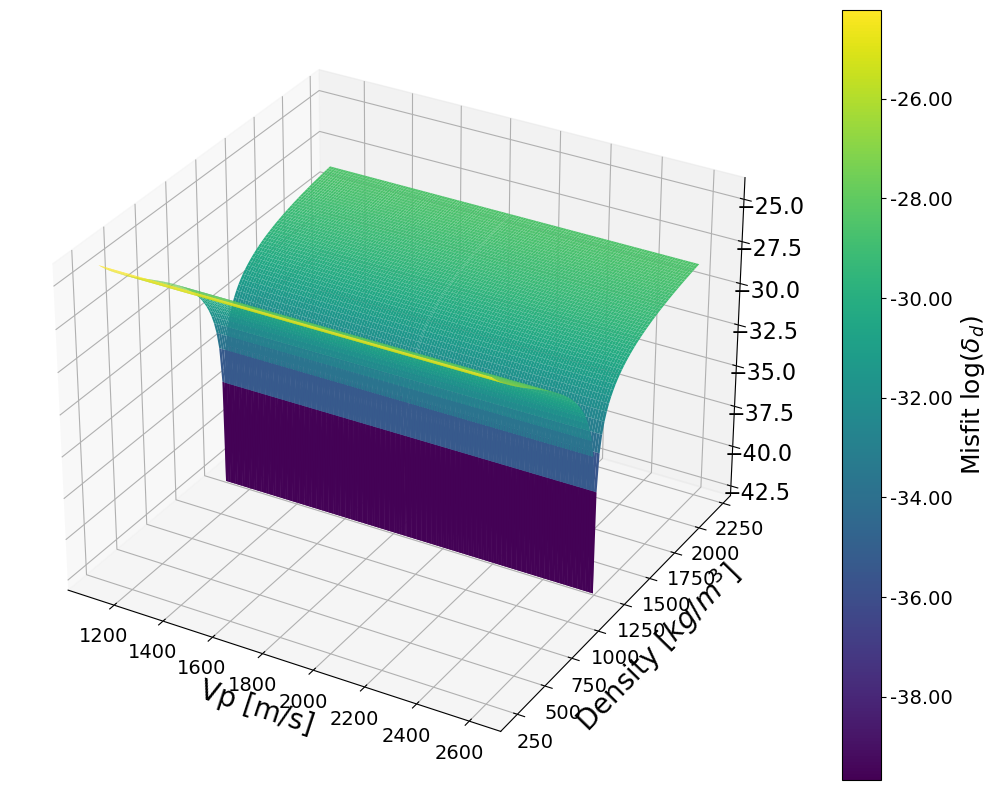

In [75]:
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111,projection='3d')
im=ax.plot_surface((xv_vp),(yv_rho),misfit_test,  cmap='viridis',rcount=misfit_test.shape[0], ccount=misfit_test.shape[1], zorder=10)
cbar = plt.colorbar(im, format='%.2f')
cbar.set_label(label=r'Misfit log($\delta_{d}$)',size=18)

ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
for t in cbar.ax.get_yticklabels():
         t.set_fontsize(14)
plt.ylabel(r'Density [$kg/m^{3}$]', fontsize=20)
plt.xlabel(r'Vp [m/s]', fontsize=20)
plt.show()

In [76]:
rho_[stx-1,sty-1]

array([1215.58754713])

In [77]:
#print(ind_min)
print( (vp_test[ind_min2[0][0]]) / vs_test[ind_min2[0][0]])
print( (4*vs_test[ind_min2[0][0]]**2) / vp_test[ind_min2[0][0]]**2)
print(rho_test[ind_min2[0][1]])

1.735367396007023
1.3282417403829587
1215.23299239278


In [78]:
print( (vp_sub[stx,sty,0]) /vs_sub[stx,sty,0])
print( (4*vs_sub[stx,sty,0]**2) /vp_sub[stx,sty,0]**2)
print(rho_grad.values[stx,sty,0])

1.7320508075688774
1.3333333333333335
1215.23299239278


(200.0, 1000.0)

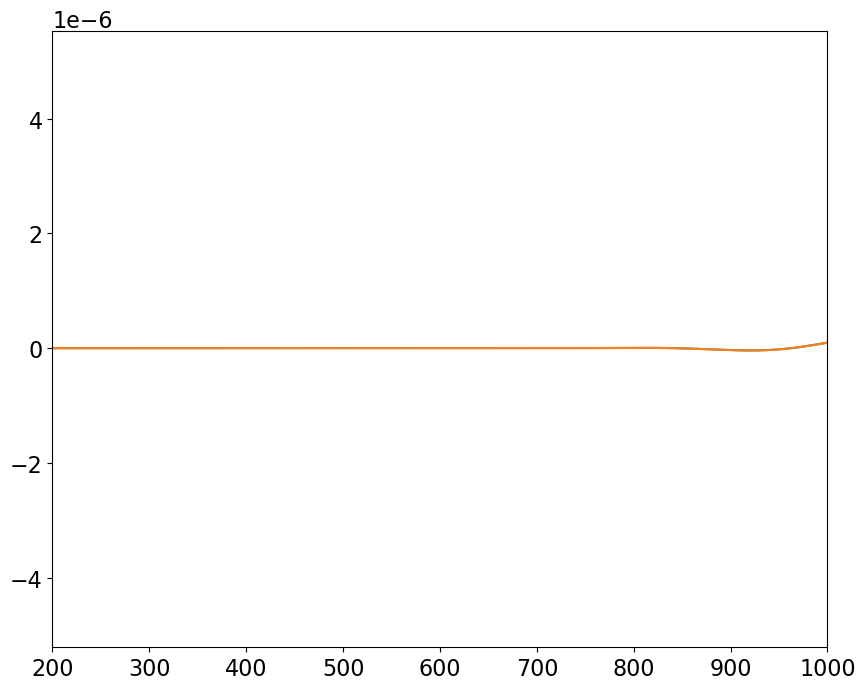

In [79]:
plt.figure(figsize=(10,8))
plt.plot(LHS_test[stx,sty])
plt.plot(RHS_acc_test[ind_min2[0][0],ind_min2[0][1]])
plt.xlim([200,1000])

(200.0, 1000.0)

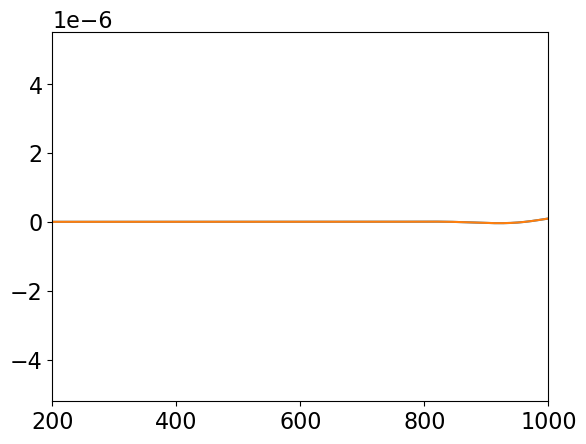

In [80]:
## plt.figure(figsize=(10,8))
plt.plot(LHS_test[stx,sty])
plt.plot(RHS_acc_test[-1,ind_min2[0][1]])
plt.xlim([200,1000])

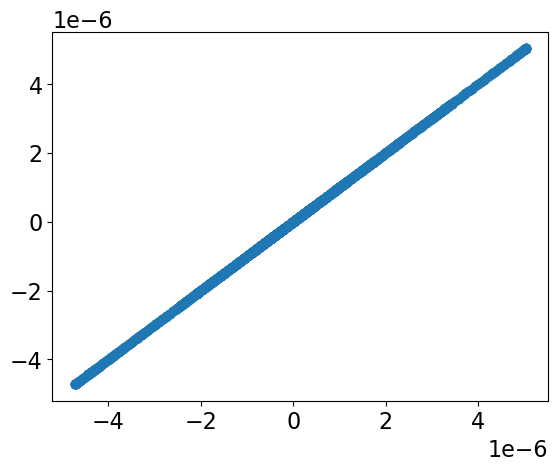

In [81]:
plt.scatter(LHS_test[stx,sty],RHS_acc_test[ind_min2[0][0],ind_min2[0][1]])

In [82]:
print(misfit_test.shape)
print(vp_test.shape)
print(rho_test.shape)

(151, 101)
(151,)
(101,)


- #### at the Free Surface (not corrected)


In [83]:
# rotROT1_FDnotFS, rotROT2_FDnotFS, rotROT3_FDnotFS, gradDIV1_FDnotFS, gradDIV2_FDnotFS, gradDIV3_FDnotFS,rhs = \
# WE_3D_ELASTIC_FDnotFS(VEL_X_gradXX[:,:,0,:,nf], VEL_Y_gradXX[:,:,0,:,nf], VEL_Z_gradXX[:,:,0,:,nf], VEL_X_gradYY[:,:,0,:,nf], VEL_Y_gradYY[:,:,0,:,nf], VEL_Z_gradYY[:,:,0,:,nf], VEL_X_gradZZ_fwdFD,\
# VEL_Y_gradZZ_fwdFD, VEL_Z_gradZZ_fwdFD, VEL_X_gradXY[:,:,0,:,nf], VEL_Y_gradXY[:,:,0,:,nf], VEL_Z_gradXY[:,:,0,:,nf], VEL_X_gradYX[:,:,0,:,nf], VEL_Y_gradYX[:,:,0,:,nf],\
# VEL_Z_gradYX[:,:,0,:,nf], VEL_X_gradYZ_FDnotFS, VEL_Y_gradYZ_FDnotFS, VEL_Z_gradYZ_FDnotFS, -VEL_X_gradXZ_FDnotFS, VEL_Y_gradXZ_FDnotFS, VEL_Z_gradXZ_FDnotFS, vp_sub[:,:,0], vs_sub[:,:,0],\
# dttv1[:,:,0,:,nf], dttv2[:,:,0,:,nf], dttv3[:,:,0,:,nf], posX,posY, posZ, nf, f_filt_cent, filtered)

In [84]:
#plt.plot(rhs_eq3[posX,posY,0,500:2500,nf])
#plt.plot(-rhs_eq3FS[posX,posY,500:2500])

## Normal Solutions, get vp & vs
- ### 3D Elastic Wave Equation

#### (a) for internal nodes

In [85]:
dttv3_internal    = dttv3[1:-1,1:-1,1:-1]
N_internal        = dttv3_internal[:,:,:,0].flatten().shape[0]

dttv2_internal    = dttv2[1:-1,1:-1,1:-1]
dttv1_internal    = dttv1[1:-1,1:-1,1:-1]
gradDIV3_internal = gradDIV3[1:-1,1:-1,1:-1]
rotROT3_internal  = rotROT3[1:-1,1:-1,1:-1]
gradDIV2_internal = gradDIV2[1:-1,1:-1,1:-1]
rotROT2_internal  = rotROT2[1:-1,1:-1,1:-1]
gradDIV1_internal = gradDIV1[1:-1,1:-1,1:-1]
rotROT1_internal  = rotROT1[1:-1,1:-1,1:-1]

vp_sub_internal = vp_sub[1:-1,1:-1,1:-1]
vs_sub_internal = vs_sub[1:-1,1:-1,1:-1]

In [86]:
dttv3_int    = np.reshape(dttv3_internal[:,:,:,a:b,:], (N_internal,nt_range, len(nn)))
dttv2_int    = np.reshape(dttv2_internal[:,:,:,a:b,:], (N_internal,nt_range, len(nn)))
dttv1_int    = np.reshape(dttv1_internal[:,:,:,a:b,:], (N_internal,nt_range, len(nn)))
gradDIV3_int = np.reshape(gradDIV3_internal, (N_internal,nt_range, len(nn)))
rotROT3_int  = np.reshape(rotROT3_internal, (N_internal,nt_range, len(nn)))
gradDIV2_int = np.reshape(gradDIV2_internal, (N_internal,nt_range, len(nn)))
rotROT2_int = np.reshape(rotROT2_internal, (N_internal,nt_range, len(nn)))
gradDIV1_int = np.reshape(gradDIV1_internal, (N_internal,nt_range, len(nn)))
rotROT1_int  = np.reshape(rotROT1_internal, (N_internal,nt_range, len(nn)))
    

## Normal Solution from vertical particle velocity - 3D case
body_est = np.zeros((N_internal,3,len(nn)))
for fi in range(len(nn)):
    for i in range(N_internal):
        #for ttt in range(1000,nt_sub):
                    #X = np.array([[gradDIV1_int[i,:],-rotROT1_int[i,:]],[gradDIV2_int[i,:],-rotROT2_int[i,:]],\
                    #             [gradDIV3_int[i,:],-rotROT3_int[i,:]]])
                    Xl = []
                    Xl = np.append(gradDIV1_int[i,:,fi], gradDIV2_int[i,:,fi])
                    Xl = np.append(Xl, gradDIV3_int[i,:,fi])


                    Xr = []
                    Xr = np.append(-rotROT1_int[i,:,fi], -rotROT2_int[i,:,fi])
                    Xr = np.append(Xr, -rotROT3_int[i,:,fi])

                    X = np.array([np.ones((3*nt_range)),Xl, Xr]).T
                    #X= X.flatten()
                    #X = np.reshape(X, (3,nt_range,2))
                    #X = np.reshape(X,(3*nt_range,2)) #+ 1e-30
                    #y_rhs = np.array([dttv1_int[i,:],dttv2_int[i,:],dttv3_int[i,:]])
                    #y_rhs = y_rhs.flatten()
                    #y_rhs = np.reshape(y_rhs,(3*nt_range))
                    y_rh = []
                    y_rh=np.append(dttv1_int[i,:,fi],dttv2_int[i,:,fi])
                    y_rhs=np.append(y_rh,dttv3_int[i,:,fi])


                    inv = np.linalg.inv(np.dot(X.T,X))
                    XX = np.dot(inv, X.T)
                    SOL = np.dot(XX, y_rhs)
                    body_est[i,:,fi] = np.sqrt(abs(SOL))
if order ==2:
    vs_est_3eq = np.reshape(body_est[:,2], (nrx-2,nry-2,nrz-2, len(nn)))
    vp_est_3eq = np.reshape(body_est[:,1], (nrx-2,nry-2,nrz-2, len(nn)))
    sc_term = np.reshape(body_est[:,0], (nrx-2,nry-2,nrz-2, len(nn)))
if order ==4:
    vs_est_3eq = np.reshape(body_est[:,2], (nrx-4,nry-4,nrz-4, len(nn)))
    vp_est_3eq = np.reshape(body_est[:,1], (nrx-4,nry-4,nrz-4, len(nn)))
    sc_term = np.reshape(body_est[:,0], (nrx-4,nry-4,nrz-4, len(nn)))

for i in range(0,nrz-2):
        print('Estimated vp velocity:'+str(vp_est_3eq[posX,posY,i]) +' at '+ str(i*dz +dz)+'m')
        print('Estimated vs velocity:'+str(vs_est_3eq[posX,posY,i]) +' at '+ str(i*dz +dz)+'m')

Estimated vp velocity:[588.91884217] at 1.0m
Estimated vs velocity:[1056.51155092] at 1.0m


In [87]:
# Chose wavefield component

#select time_range
a = 0
b = nt_sub
nt_range = b-a

comp ='X'
vp_est_3D_X, vs_est_3D_X = NORM_SOL_3D_ELASTIC(dttv1_internal[:,:,:,a:b], dttv2_internal[:,:,:,a:b], dttv3_internal[:,:,:,a:b], rotROT1_internal[:,:,:,a:b], rotROT2_internal[:,:,:,a:b],\
                                     rotROT3_internal[:,:,:,a:b], gradDIV1_internal[:,:,:,a:b],gradDIV2_internal[:,:,:,a:b], gradDIV3_internal[:,:,:,a:b], nt_range, nrx,\
                                     nry, nrz, comp, order)
comp ='Y'
vp_est_3D_Y, vs_est_3D_Y = NORM_SOL_3D_ELASTIC(dttv1_internal[:,:,:,a:b], dttv2_internal[:,:,:,a:b], dttv3_internal[:,:,:,a:b], rotROT1_internal[:,:,:,a:b], rotROT2_internal[:,:,:,a:b],\
                                     rotROT3_internal[:,:,:,a:b], gradDIV1_internal[:,:,:,a:b],gradDIV2_internal[:,:,:,a:b], gradDIV3_internal[:,:,:,a:b], nt_range, nrx,\
                                     nry, nrz, comp, order)
comp ='Z'
vp_est_3D_Z, vs_est_3D_Z = NORM_SOL_3D_ELASTIC(dttv1_internal[:,:,:,a:b], dttv2_internal[:,:,:,a:b], dttv3_internal[:,:,:,a:b], rotROT1_internal[:,:,:,a:b], rotROT2_internal[:,:,:,a:b],\
                                     rotROT3_internal[:,:,:,a:b], gradDIV1_internal[:,:,:,a:b],gradDIV2_internal[:,:,:,a:b], gradDIV3_internal[:,:,:,a:b], nt_range, nrx,\
                                     nry, nrz, comp, order)

for i in range(0,nrz-2):
        print('Estimated vp velocity:'+str(vp_est_3D_Z[posX,posY,i]) +' at '+ str(i*dz +dz)+'m')
        print('Estimated vs velocity:'+str(vs_est_3D_Z[posX,posY,i]) +' at '+ str(i*dz +dz)+'m')

Estimated vp velocity:1676.0976371029435 at 1.0m
Estimated vs velocity:967.8657887224447 at 1.0m


#### (c) at the Free Surface - corrected

In [88]:
A3_internal  = A3[1:-1,1:-1,:]
B3_internal  = B3[1:-1,1:-1,:]
A2_internal  = A2[1:-1,1:-1,:]
B2_internal  = B2[1:-1,1:-1,:]
A1_internal  = A1[1:-1,1:-1,:]
B1_internal  = B1[1:-1,1:-1,:]

In [89]:
# Chose wavefield component

#select time_range
a = 0
b = nt_sub
nt_range = b-a

comp ='X'
#,X,y_rhs,inv,XX,SOL,body_est
vs_est_3D_X_at_FS, ratio_X_at_FS = NORM_SOL_3D_ELASTIC_at_FS(dttv1_internal[:,:,0,a:b], dttv2_internal[:,:,0,a:b], \
                                     dttv3_internal[:,:,0,a:b], A1_internal[:,:,a:b], A2_internal[:,:,a:b],\
                                     A3_internal[:,:,a:b], B1_internal[:,:,a:b], B2_internal[:,:,a:b], B3_internal[:,:,a:b], nt_range, nrx,\
                                     nry, nrz, comp)
comp ='Y'
vs_est_3D_Y_at_FS, ratio_Y_at_FS = NORM_SOL_3D_ELASTIC_at_FS(dttv1_internal[:,:,0,a:b], dttv2_internal[:,:,0,a:b],\
                                     dttv3_internal[:,:,0,a:b], A1_internal[:,:,a:b], A2_internal[:,:,a:b],\
                                     A3_internal[:,:,a:b], B1_internal[:,:,a:b],B2_internal[:,:,a:b], B3_internal[:,:,a:b], nt_range, nrx,\
                                     nry, nrz, comp)
comp ='Z'
vp_est_3D_Z_at_FS, vs_est_3D_Z_at_FS = NORM_SOL_3D_ELASTIC_at_FS(dttv1_internal[:,:,0,a:b], dttv2_internal[:,:,0,a:b], \
                                     dttv3_internal[:,:,0,a:b], A1_internal[:,:,a:b], A2_internal[:,:,a:b],\
                                     A3_internal[:,:,a:b], B1_internal[:,:,a:b], B2_internal[:,:,a:b], B3_internal[:,:,a:b], nt_range, nrx,\
                                     nry, nrz, comp)

for i in range(0,nrx-2):
    for j in range(0,nry-2):
        print('Estimated vp velocity:'+str(vp_est_3D_Z_at_FS[i,j]) +' at ['+ str(i*dx +dx)+', '+ str(j*dy +dy)+'] m')
        print('Estimated vs velocity:'+str(vs_est_3D_Z_at_FS[i,j]) +' at ['+ str(i*dx +dx)+', '+ str(j*dy +dy)+'] m')

Estimated vp velocity:1648.149971007374 at [2.0, 2.0] m
Estimated vs velocity:951.5992937154857 at [2.0, 2.0] m
Estimated vp velocity:1667.7233376466818 at [2.0, 4.0] m
Estimated vs velocity:962.7038526171248 at [2.0, 4.0] m
Estimated vp velocity:1677.1745266524088 at [2.0, 6.0] m
Estimated vs velocity:968.382221839083 at [2.0, 6.0] m
Estimated vp velocity:1695.3582501245805 at [2.0, 8.0] m
Estimated vs velocity:978.8539869861692 at [2.0, 8.0] m
Estimated vp velocity:1715.4549757352754 at [2.0, 10.0] m
Estimated vs velocity:990.4457423518136 at [2.0, 10.0] m
Estimated vp velocity:1741.186166851989 at [2.0, 12.0] m
Estimated vs velocity:1005.3052825021929 at [2.0, 12.0] m
Estimated vp velocity:1762.7662546988506 at [2.0, 14.0] m
Estimated vs velocity:1017.7830902440365 at [2.0, 14.0] m
Estimated vp velocity:1787.3640835115318 at [2.0, 16.0] m
Estimated vs velocity:1031.9879523635075 at [2.0, 16.0] m
Estimated vp velocity:1814.658484441962 at [2.0, 18.0] m
Estimated vs velocity:1047.7468

#### (b) at the Free Surface - not corrected

In [90]:
# dttv3_FDnotFS_internal    = dttv3[1:-1,1:-1,:]
# N_internal_FDnotFS        = dttv3_internal[:,:,0].flatten().shape[0]

# dttv2_FDnotFS_internal    = dttv2[1:-1,1:-1,:]
# dttv1_FDnotFS_internal    = dttv1[1:-1,1:-1,:]
# gradDIV3_FDnotFS_internal = gradDIV3_FDnotFS[1:-1,1:-1]
# rotROT3_FDnotFS_internal  = rotROT3_FDnotFS[1:-1,1:-1]
# gradDIV2_FDnotFS_internal = gradDIV2_FDnotFS[1:-1,1:-1]
# rotROT2_FDnotFS_internal  = rotROT2_FDnotFS[1:-1,1:-1]
# gradDIV1_FDnotFS_internal = gradDIV1_FDnotFS[1:-1,1:-1]
# rotROT1_FDnotFS_internal  = rotROT1_FDnotFS[1:-1,1:-1]

In [91]:
# # Chose wavefield component

# #select time_range
# a = 0
# b = nt_sub
# nt_range = b-a

# comp ='X'
# vp_est_3D_X_FDnotFS, vs_est_3D_X_FDnotFS = NORM_SOL_3D_ELASTIC_notCORR(dttv1_FDnotFS_internal[:,:,0,a:b], dttv2_FDnotFS_internal[:,:,0,a:b], dttv3_FDnotFS_internal[:,:,0,a:b], rotROT1_FDnotFS_internal[:,:,a:b], rotROT2_FDnotFS_internal[:,:,a:b],\
#                                      rotROT3_FDnotFS_internal[:,:,a:b], gradDIV1_FDnotFS_internal[:,:,a:b],gradDIV2_FDnotFS_internal[:,:,a:b], gradDIV3_FDnotFS_internal[:,:,a:b], nt_range, nrx,\
#                                      nry, nrz, comp, order)
# comp ='Y'
# vp_est_3D_Y_FDnotFS, vs_est_3D_Y_FDnotFS = NORM_SOL_3D_ELASTIC_notCORR(dttv1_FDnotFS_internal[:,:,0,a:b], dttv2_FDnotFS_internal[:,:,0,a:b], dttv3_FDnotFS_internal[:,:,0,a:b], rotROT1_FDnotFS_internal[:,:,a:b], rotROT2_FDnotFS_internal[:,:,a:b],\
#                                      rotROT3_FDnotFS_internal[:,:,a:b], gradDIV1_FDnotFS_internal[:,:,a:b],gradDIV2_FDnotFS_internal[:,:,a:b], gradDIV3_FDnotFS_internal[:,:,a:b], nt_range, nrx,\
#                                      nry, nrz, comp, order)
# comp ='Z'
# vp_est_3D_Z_FDnotFS, vs_est_3D_Z_FDnotFS = NORM_SOL_3D_ELASTIC_notCORR(dttv1_FDnotFS_internal[:,:,0,a:b], dttv2_FDnotFS_internal[:,:,0,a:b], dttv3_FDnotFS_internal[:,:,0,a:b], rotROT1_FDnotFS_internal[:,:,a:b], rotROT2_FDnotFS_internal[:,:,a:b],\
#                                      rotROT3_FDnotFS_internal[:,:,a:b], gradDIV1_FDnotFS_internal[:,:,a:b],gradDIV2_FDnotFS_internal[:,:,a:b], gradDIV3_FDnotFS_internal[:,:,a:b], nt_range, nrx,\
#                                      nry, nrz, comp, order)

# print('Estimated vp velocity:'+str(vp_est_3D_Z_FDnotFS[posX,posY]) +' at 1/2 beneath the surface ')
# print('Estimated vs velocity:'+str(vs_est_3D_Z_FDnotFS[posX,posY]) +' at 1/2 beneath the surface ')

## Graphical Solution via Objective Function
- ### 3D Elastic Wave Equation

In [92]:
# Receiver position -1 cause we extracted only internal nodes
posX = posX-1
posY = posY-1
posZ = posZ-1

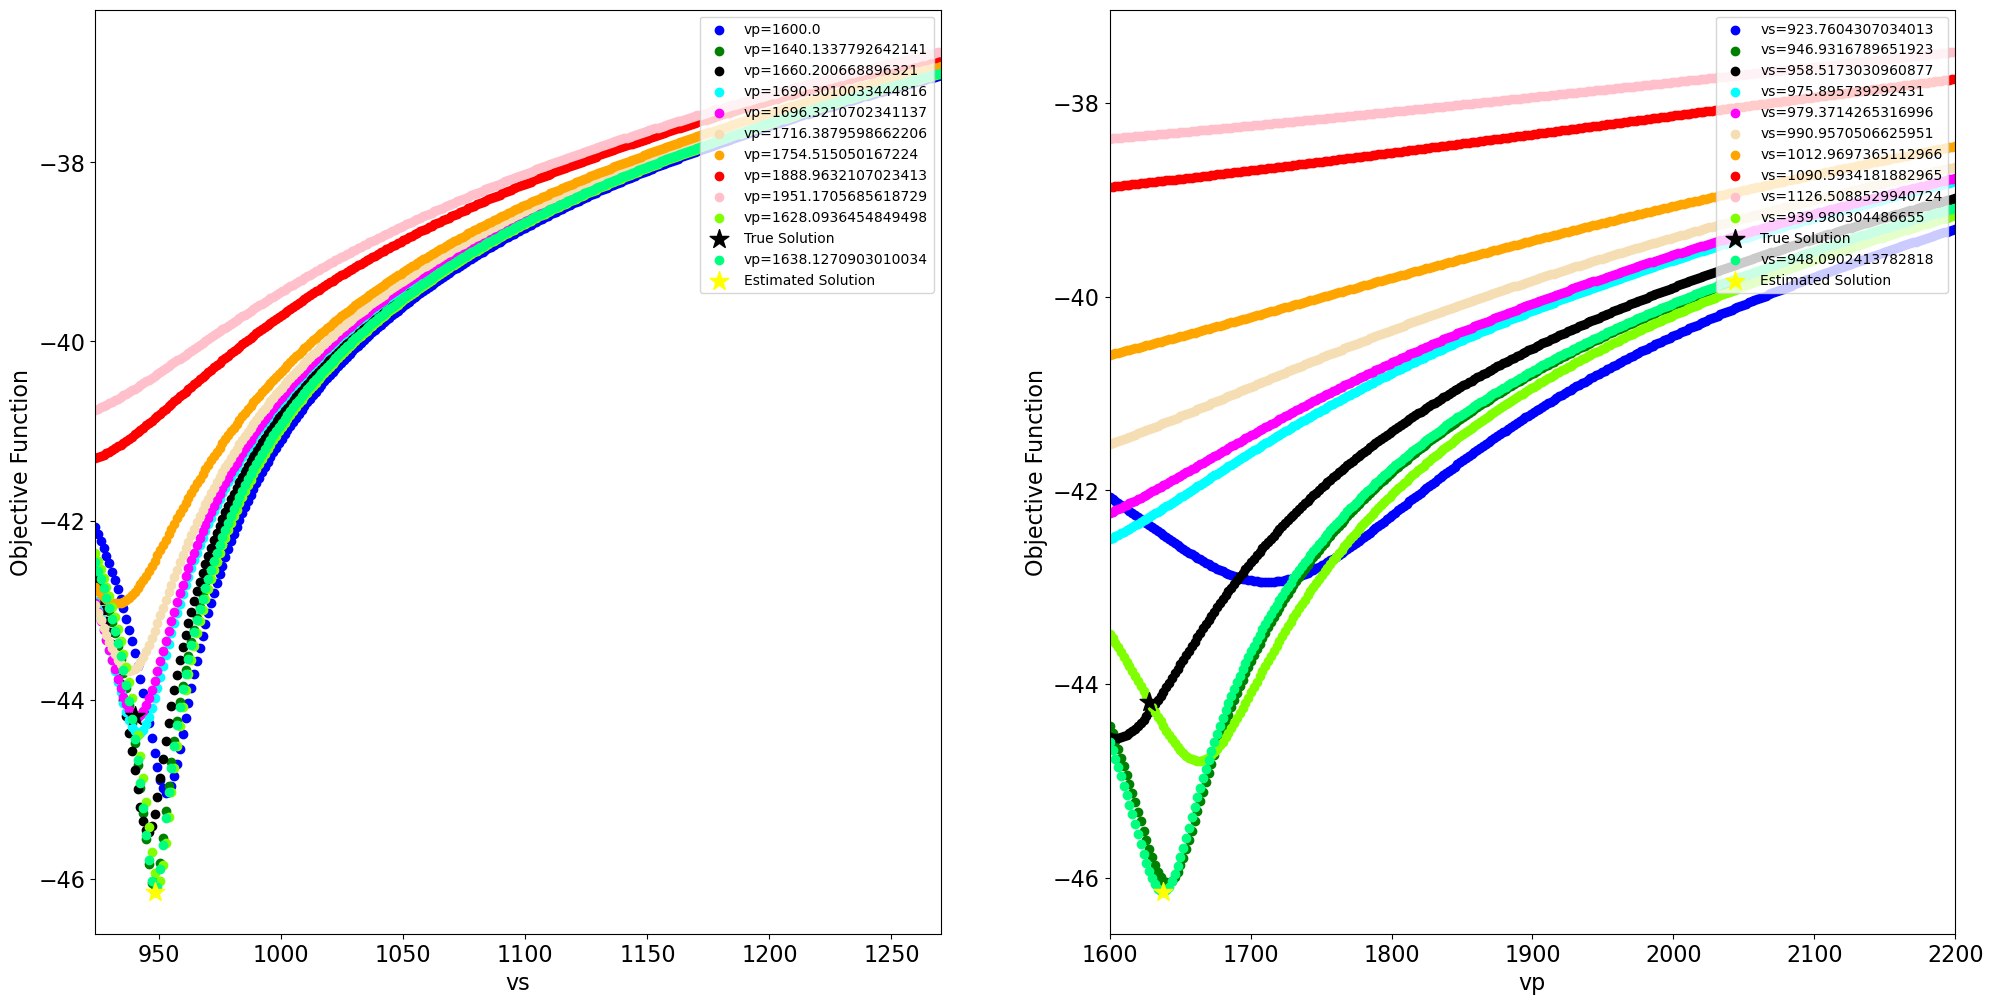

In [93]:
leng = 300
theta1 = np.linspace(1600,2200,leng) #800,1600
theta2 = theta1/np.sqrt(3)
posZ=0
comp = 'Z'
mini, yy = OBJ_FCT(theta1, theta2, comp, leng, nt_range, gradDIV1_internal[posX,posY,posZ,a:b,nf], gradDIV2_internal[posX,posY,posZ,a:b,nf], \
            gradDIV3_internal[posX,posY,posZ,a:b,nf],rotROT1_internal[posX,posY,posZ,a:b,nf], rotROT2_internal[posX,posY,posZ,a:b,nf],\
            rotROT3_internal[posX,posY,posZ,a:b,nf], dttv1_internal[posX,posY,posZ,a:b,nf], dttv2_internal[posX,posY,posZ,a:b,nf], \
               dttv3_internal[posX,posY,posZ,a:b,nf], vp_sub_internal[posX,posY,posZ], vs_sub_internal[posX,posY,posZ],_res, filtered, f_filt_cent,posX,posY,posZ)

In [94]:
#px = PARA['rec_grid_pos'][0]+dx+(dx*(posX))
#py = PARA['rec_grid_pos'][1]+dy+(dy*(posY))
#pz = 0+dz+(dz*(posZ))

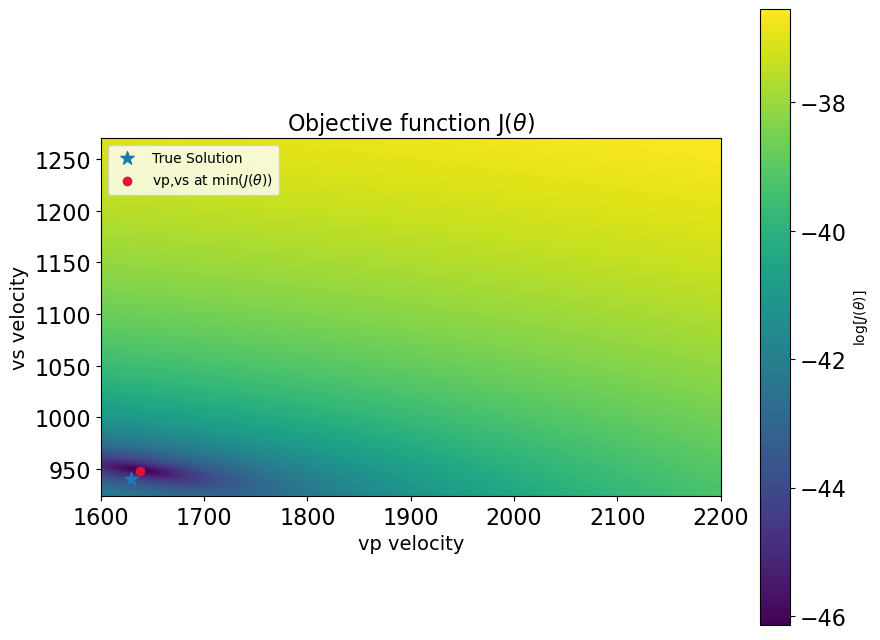

In [95]:
FCT_2D_OBJ(yy, theta1, theta2, mini, vp_sub_internal[posX,posY,posZ], vs_sub_internal[posX,posY,posZ], _res, f_filt_cent[nf],\
           filtered, posX, posY, posZ)

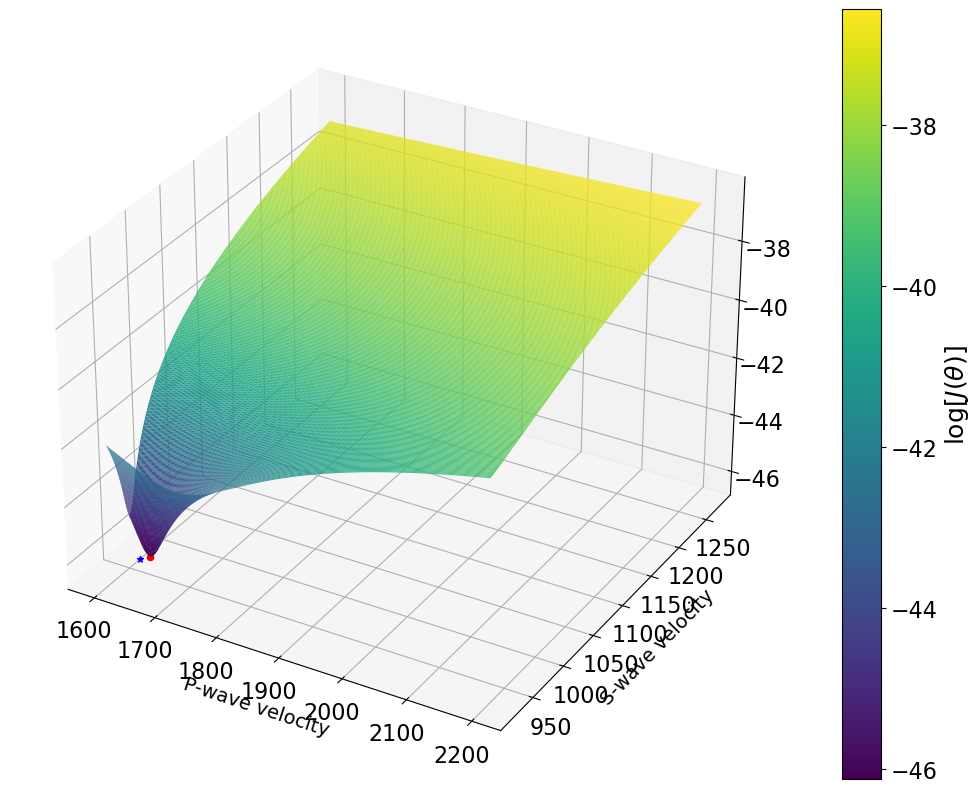

In [96]:
tet1,tet2 = np.meshgrid(theta1,theta2)
FCT_3D_OBJ(tet1, tet2, yy, theta1, theta2, mini, _res, posX, posY, posZ, f_filt_cent[nf], filtered,vp_sub_internal[posX,posY,posZ], vs_sub_internal[posX,posY, posZ])

In [97]:
#print('True velocity:', theta1[true1[-1]+1][0],theta2[true2[-1]+1][0])

print('True velocity               :', vp_sub_internal[posX,posY,posZ], vs_sub_internal[posX,posY, posZ])
print('Objective function solution :', theta1[mini[0][0]],theta2[mini[0][1]])
print('Normal Solution             :', vp_est_3D_Z[posX,posY,posZ], vs_est_3D_Z[posX,posY,posZ])


True velocity               : 1628.9145976720274 940.4542814528558
Objective function solution : 1638.1270903010034 948.0902413782818
Normal Solution             : 1635.9685579984075 948.5964456138765


- #### at Free Surface

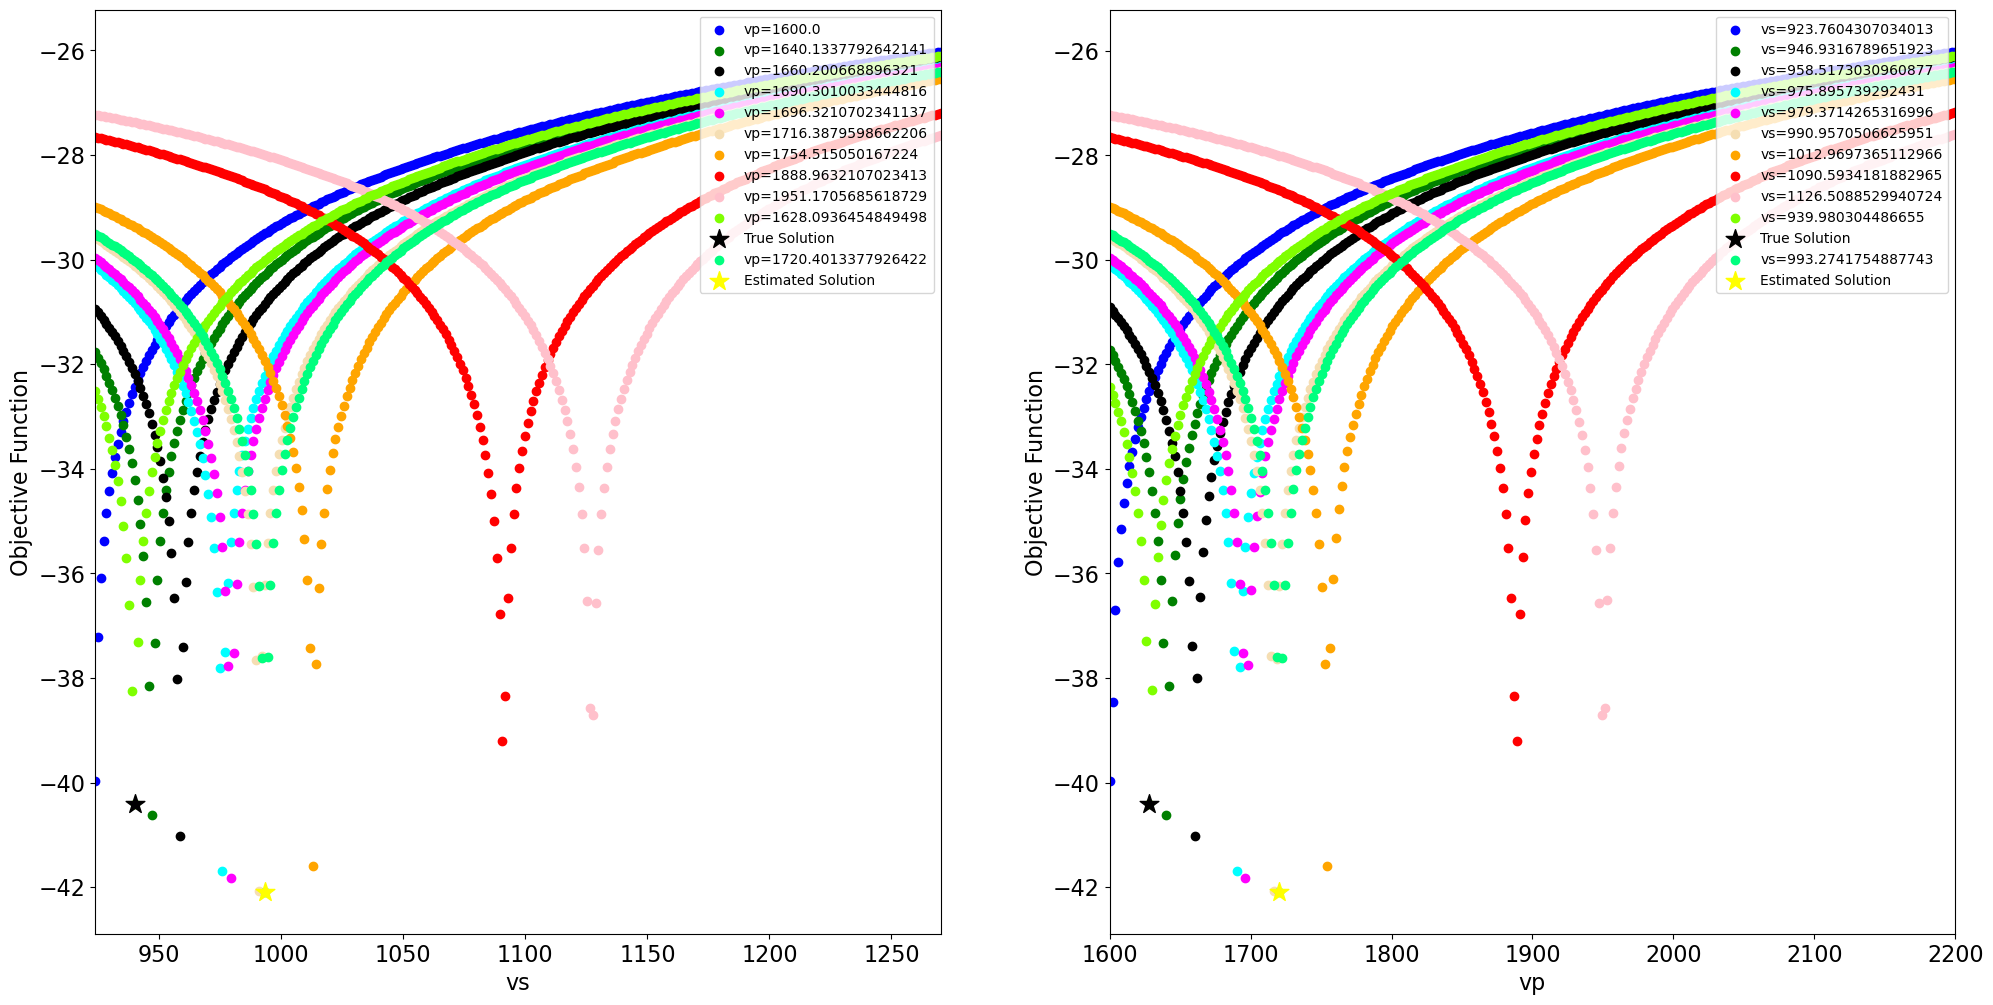

In [98]:
leng = 300
theta1 = np.linspace(1600,2200,leng)
theta2 = theta1/np.sqrt(3)
comp = 'Z'
mini_FS, yy_FS = OBJ_FCT(theta1, theta2, comp, leng, nt_range, A1_internal[posX,posY,a:b], A2_internal[posX,posY,a:b],\
                         A3_internal[posX,posY,a:b],B1_internal[posX,posY,a:b], B2_internal[posX,posY,a:b],\
                         B3_internal[posX,posY,a:b], dttv1_internal[posX,posY,0,a:b,nf], dttv2_internal[posX,posY,0,a:b,nf], \
               dttv3_internal[posX,posY,0,a:b,nf], vp_sub_internal[posX,posY,0], vs_sub_internal[posX,posY,0],_res, filtered, f_filt_cent,posX,posY,posZ)

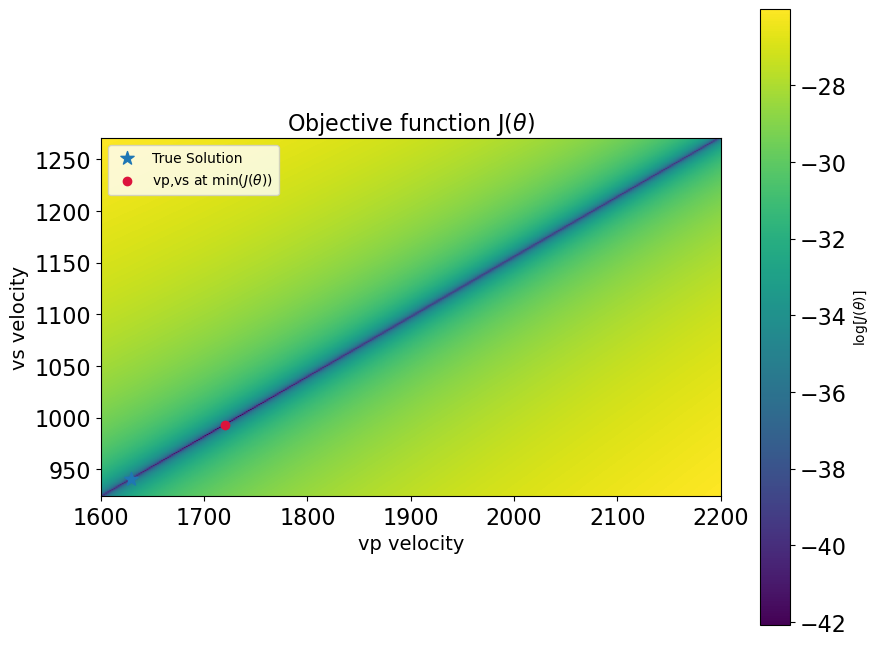

In [99]:
FCT_2D_OBJ(yy_FS, theta1, theta2, mini_FS, vp_sub_internal[posX,posY,0], vs_sub_internal[posX,posY,0], _res, f_filt_cent[nf],\
           filtered, posX, posY, 0)

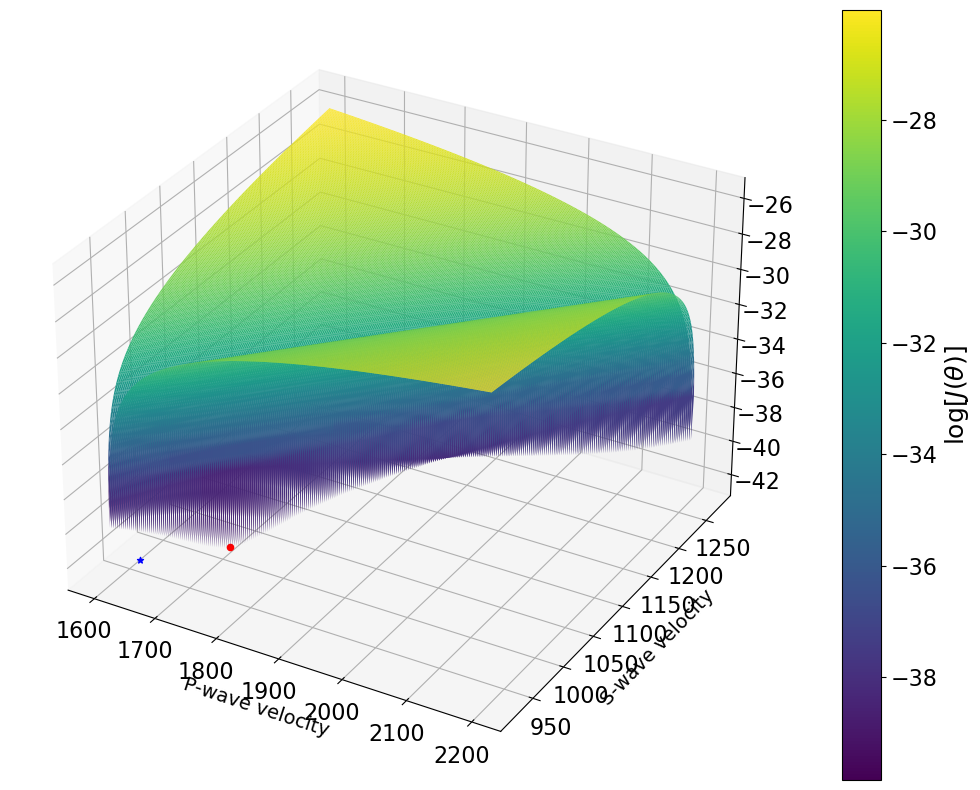

In [100]:
tet1,tet2 = np.meshgrid(theta1,theta2)
FCT_3D_OBJ(tet1, tet2, yy_FS, theta1, theta2, mini_FS, _res, posX, posY, posZ, f_filt_cent[nf], filtered,vp_sub[posX+1,posY+1,0], vs_sub[posX+1,posY+1,0])

In [101]:
print('True velocity               :', vp_sub[posX+1,posY+1,0], vs_sub[posX+1,posY+1,0])
print('Objective function solution :', theta1[mini_FS[0][0]],theta2[mini_FS[0][1]])
print('Normal Solution             :', vp_est_3D_Z_at_FS[posX,posY], vs_est_3D_Z_at_FS[posX,posY])

True velocity               : 1628.9145976720276 940.4542814528561
Objective function solution : 1720.4013377926422 993.2741754887743
Normal Solution             : 1686.402362840931 973.5428365267078


In [102]:
print(4*(vs_sub[posX+1,posY+1,0])**2 / (vp_sub[posX+1,posY+1,0])**2)
print(4*(vs_est_3D_Z_at_FS[posX,posY])**2 / (vp_est_3D_Z_at_FS[posX,posY])**2)

1.3333333333333335
1.3330539261125314


In [103]:
print(vp_sub[posX+1,posY+1,0] / vs_sub[posX+1,posY+1,0])
print(vp_est_3D_Z_at_FS[posX,posY]/ vs_est_3D_Z_at_FS[posX,posY])
print(np.sqrt(3))

1.7320508075688774
1.7322323164099074
1.7320508075688772


In [104]:
100*((vp_sub[posX+1,posY+1,0]-vp_est_3D_Z_at_FS[posX,posY])/vp_sub[posX+1,posY+1,0])
100*((vs_sub[posX+1,posY+1,0]-vs_est_3D_Z_at_FS[posX,posY])/vs_sub[posX+1,posY+1,0])

-3.5183587045544633

In [105]:
vp_est_3D_Z_at_FS.shape

(38, 38)

- #### at Free Surface (not corrected)


In [106]:
# leng = 500
# theta1 = np.linspace(600,1600,leng)
# theta2 = theta1/np.sqrt(3)
# comp = 'Z'
# mini_FDnotFS, yy_FDnotFS = OBJ_FCT(theta1, theta2, comp, leng, nt_range,gradDIV1_FDnotFS_internal[posX,posY,a:b],gradDIV2_FDnotFS_internal[posX,posY,a:b], gradDIV3_FDnotFS_internal[posX,posY,a:b], rotROT1_FDnotFS_internal[posX,posY,a:b], rotROT2_FDnotFS_internal[posX,posY,a:b],\
#                                      rotROT3_FDnotFS_internal[posX,posY,a:b], dttv1_FDnotFS_internal[posX,posY,0,a:b,nf], dttv2_FDnotFS_internal[posX,posY,0,a:b,nf], \
#                dttv3_FDnotFS_internal[posX,posY,0,a:b,nf], vp_sub_internal[posX,posY,0], vs_sub_internal[posX,posY,0],_res, filtered, f_filt_cent,posX,posY,posZ)

In [107]:
# FCT_2D_OBJ(yy_FDnotFS, theta1, theta2, mini_FDnotFS, vp_sub_internal[posX,posY,0], vs_sub_internal[posX,posY,0], _res, f_filt_cent[nf],\
#            filtered, posX, posY, 0)

In [108]:
# tet1,tet2 = np.meshgrid(theta1,theta2)
# FCT_3D_OBJ(tet1, tet2, yy_FDnotFS, theta1, theta2, mini_FDnotFS, _res, posX, posY, posZ, f_filt_cent[nf], filtered,vp_sub[posX+1,posY+1,0], vs_sub[posX+1,posY+1,0])

In [109]:
# print('True velocity               :', vp_sub[posX+1,posY+1,0], vs_sub[posX+1,posY+1,0])
# print('Objective function solution :', theta1[mini_FDnotFS[0][0]],theta2[mini_FDnotFS[0][1]])
# print('Normal Solution             :', vp_est_3D_Z_FDnotFS[posX,posY], vs_est_3D_Z_FDnotFS[posX,posY])

## Results - vp & vs horizontal slice
- ### 3D Elastic Wave Equation

In [110]:
## Standard internal FD result
posZ=0 # 1m below surface
title = 'Estimated body wave velocities - from 3D Elastic WE - Z component'
text1 = 'Vp at depth = %d m'%(posZ*dz +dz)
text2 = 'Vs at depth = %d m'%(posZ*dz +dz)
vs_est = vs_est_3eq[:,:,posZ]
vp_est = vp_est_3eq[:,:,posZ]
nr_internal = nr-2
I = int(order/2)
colormap = 'YlGnBu'#'viridis'
label_name = '[m/s]'

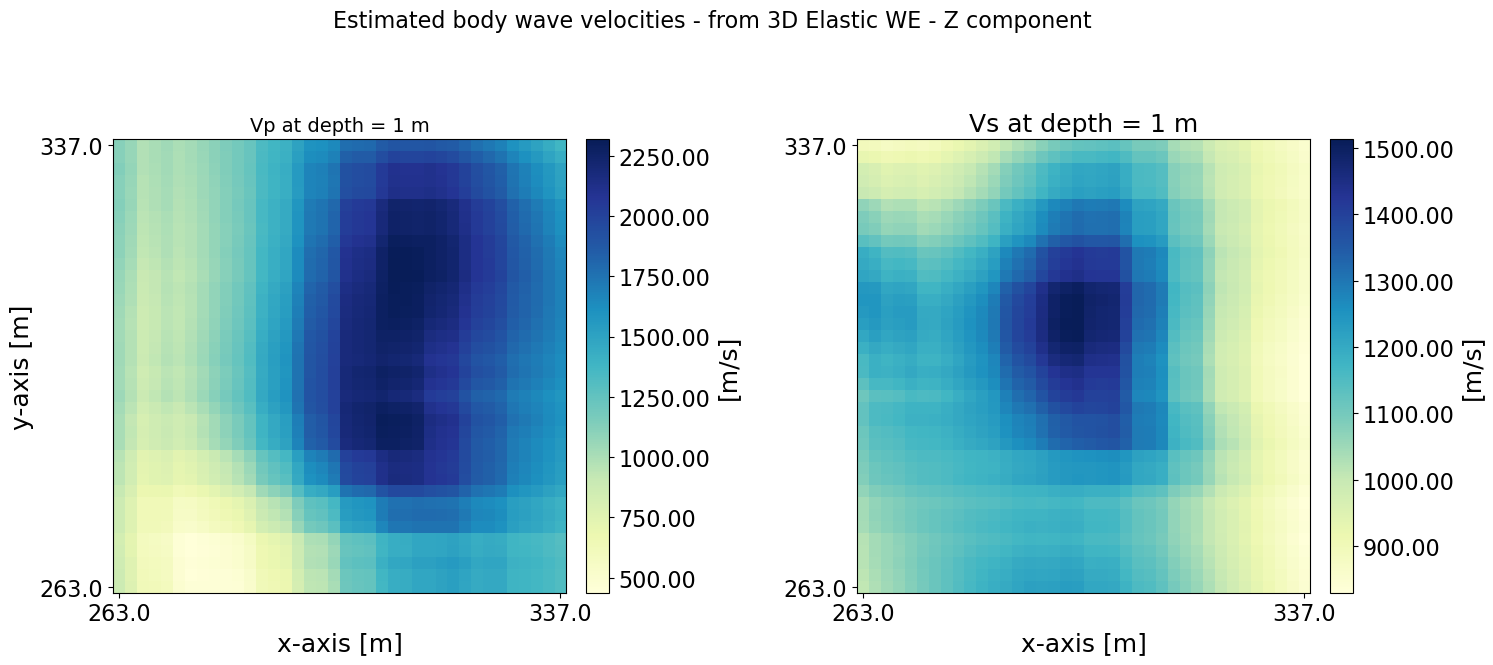

In [111]:
image_field(_res, vp_est, vs_est, title, nr_internal, rx0+dx, rx1-dx, ry0+dy, ry1-dy, text1, text2,I, label_name, colormap)

In [112]:
## At free surface - corrected
title = 'Velocity Field - Z component'
text1 = 'Vp at Free Surface'
text2 = 'Vs at Free Surface'
vs_est = vs_sub[1:-1,1:-1,0]#
vp_est = vp_sub[1:-1,1:-1,0]#
nr_internal = nr-2
label_name='[m/s]'
colormap='YlGnBu'#'viridis'

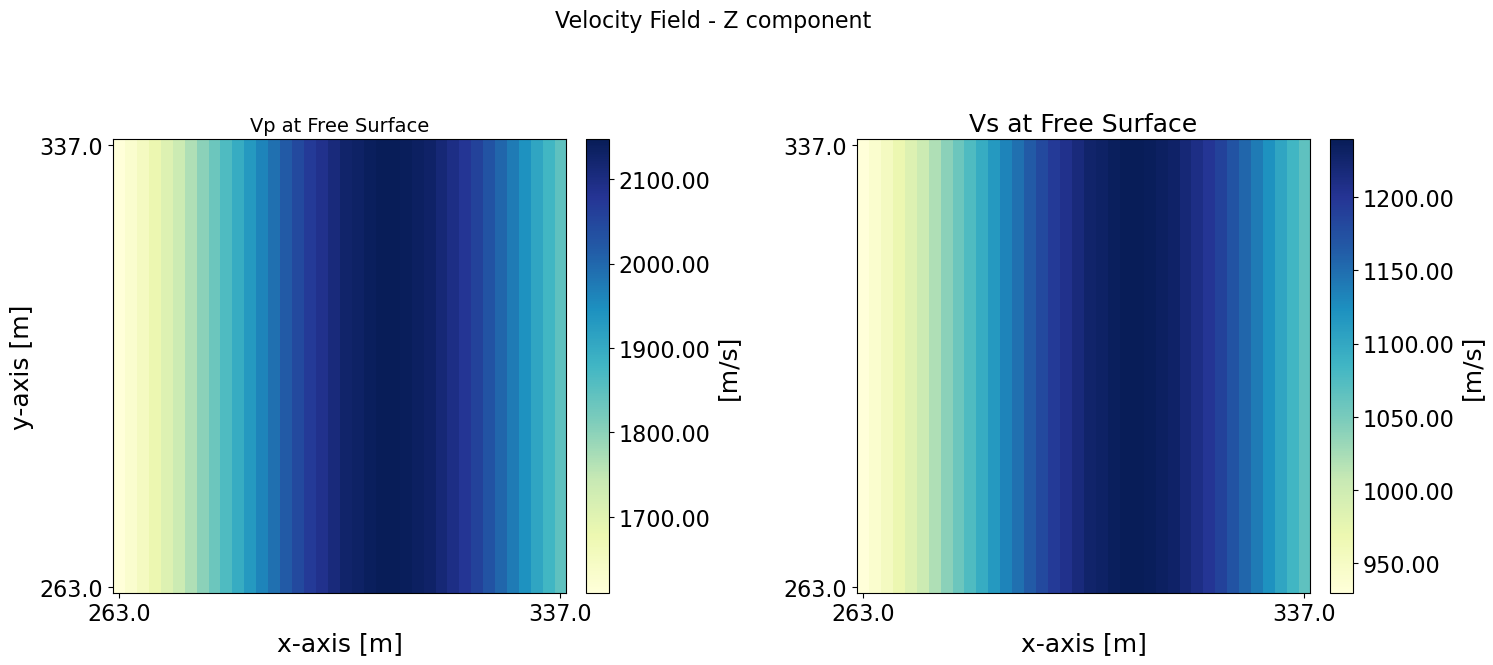

In [113]:
image_field(_res, vp_est, vs_est, title, nr_internal, rx0+dx, rx1-dx, ry0+dy, ry1-dy, text1, text2,I, label_name, colormap)

In [114]:
## At free surface - corrected
title = 'Velocity Field - Z component'
text1 = 'Vp at Free Surface'
text2 = 'Vs at Free Surface'
vs_est = vs_est_3D_Z_at_FS#vs_sub[1:-1,1:-1,0]#
vp_est = vp_est_3D_Z_at_FS#vp_sub[1:-1,1:-1,0]#
nr_internal = nr-2
label_name='[m/s]'
colormap='YlGnBu'#'viridis'

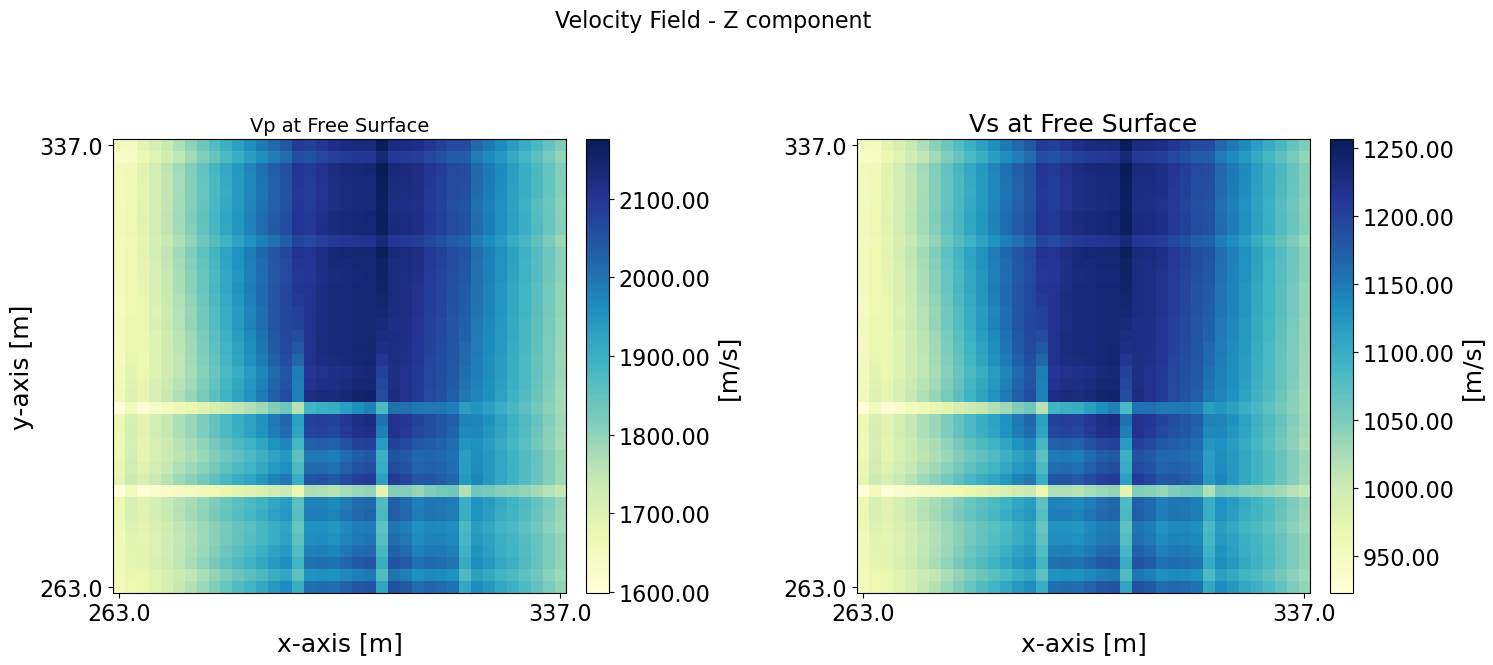

In [115]:
image_field(_res, vp_est, vs_est, title, nr_internal, rx0+dx, rx1-dx, ry0+dy, ry1-dy, text1, text2,I, label_name, colormap)

In [116]:
vp_sub[1:-1,1:-1,00]

array([[1610.17494964, 1628.91459767, 1651.31528146, ..., 1909.86295384,
        1877.70702999, 1845.18939399],
       [1610.17494964, 1628.91459767, 1651.31528146, ..., 1909.86295384,
        1877.70702999, 1845.18939399],
       [1610.17494964, 1628.91459767, 1651.31528146, ..., 1909.86295384,
        1877.70702999, 1845.18939399],
       ...,
       [1610.17494964, 1628.91459767, 1651.31528146, ..., 1909.86295384,
        1877.70702999, 1845.18939399],
       [1610.17494964, 1628.91459767, 1651.31528146, ..., 1909.86295384,
        1877.70702999, 1845.18939399],
       [1610.17494964, 1628.91459767, 1651.31528146, ..., 1909.86295384,
        1877.70702999, 1845.18939399]])

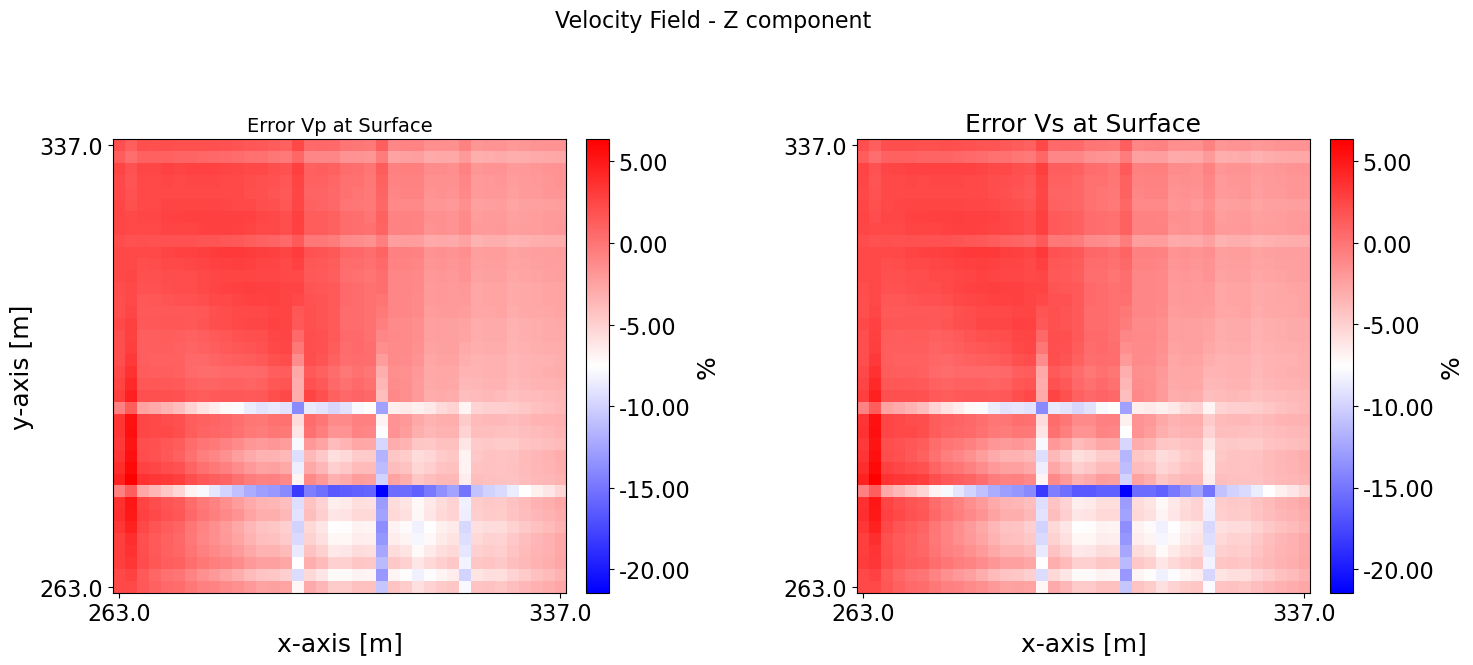

In [117]:
text1 = r'Error Vp at Surface'# = %d m'%(posZ*dz +dz)
text2 = r'Error Vs at Surface'## = %d m'%(posZ*dz +dz)
label_name = '%'
colormap='bwr'
image_field(_res, 100*(vp_est-vp_sub[1:-1,1:-1,0])/vp_sub[1:-1,1:-1,0], 100*(vs_est-vs_sub[1:-1,1:-1,0])/vs_sub[1:-1,1:-1,0], title, nr_internal, rx0+dx, rx1-dx, ry0+dy, ry1-dy, text1, text2,I, label_name,colormap)

In [118]:
title = 'Velocity Field - X component'
text1 = r'$V_{P}$ at Free Surface' #r'$\frac{Vs^{2}}{Vp}$ at Free Surface'
text2 = r'$V_{S}$ at Free Surface'
vs_est    = vs_est_3D_Y_at_FS
ratio_est = ratio_Y_at_FS
vp_est    = vs_est**2/ratio_est
nr_internal = nr-2

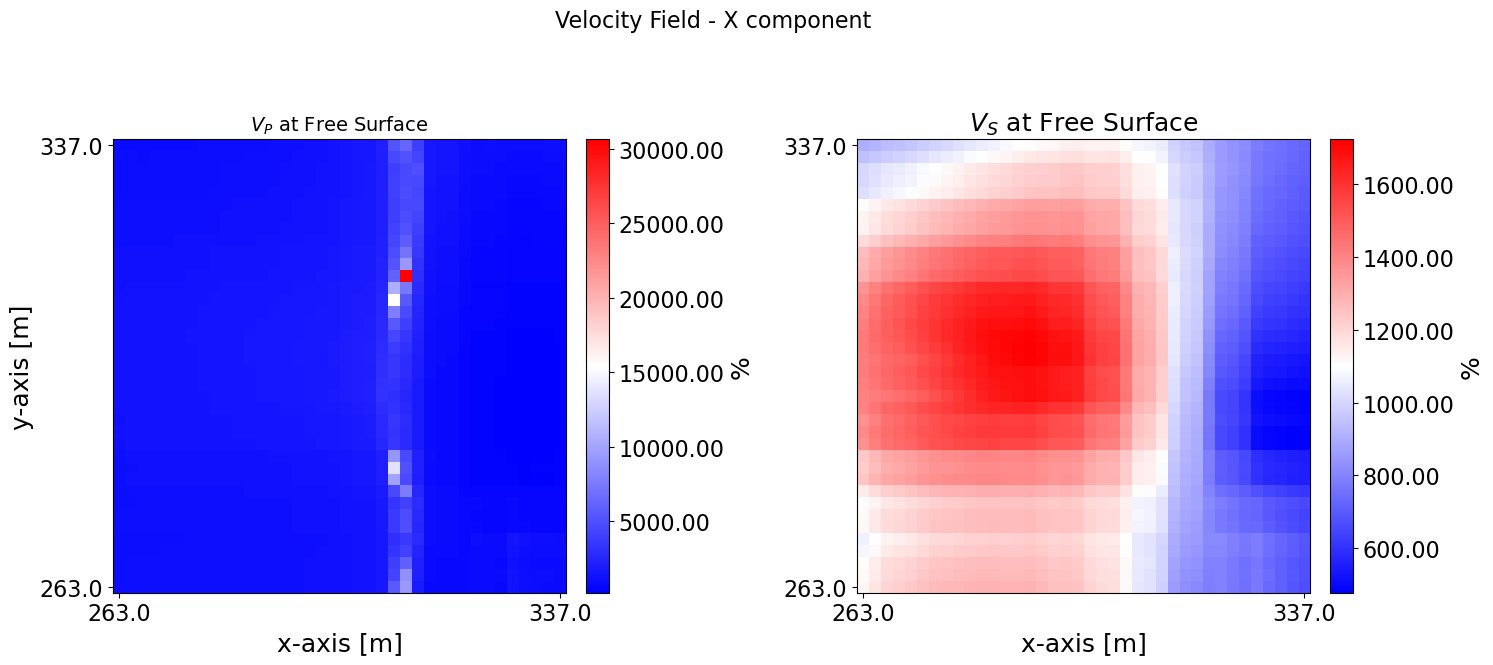

In [119]:
image_field(_res, vp_est, vs_est, title, nr_internal, rx0+dx, rx1-dx, ry0+dy, ry1-dy, text1, text2, I, label_name, colormap)

In [120]:
# ## At free surface e.g. 1/2m below - not corrected
# title = 'Velocity Field - Z component'
# text1 = 'Vp at Free Surface'
# text2 = 'Vs at Free Surface'
# vs_est = vs_est_3D_Z_FDnotFS
# vp_est = vp_est_3D_Z_FDnotFS
# nr_internal = nr-2

In [121]:
# image_field(_res, vp_est, vs_est, title, nr_internal, rx0+dx, rx1-dx, ry0+dy, ry1-dy, text1, text2, I, label_name, colormap)

In [122]:
# ## At free surface e.g. 1/2m below - not corrected
# title = 'Particle Velocity Recording'
# text1 = 'XY Recording'
# text2 = 'Z Recording'
# vp_est = VEL_X[1:-1,1:-1,0].sum(2) + VEL_Y[1:-1,1:-1,0].sum(2)
# vs_est = VEL_Z[1:-1,1:-1,0].sum(2)
# nr_internal = nr-2

In [123]:
#image_field(_res, vp_est, vs_est, title, nr_internal, rx0+dx, rx1-dx, ry0+dy, ry1-dy, text1, text2, I, label_name, colormap)

# Density


In [124]:
xx=20
yy=20

(200.0, 3000.0)

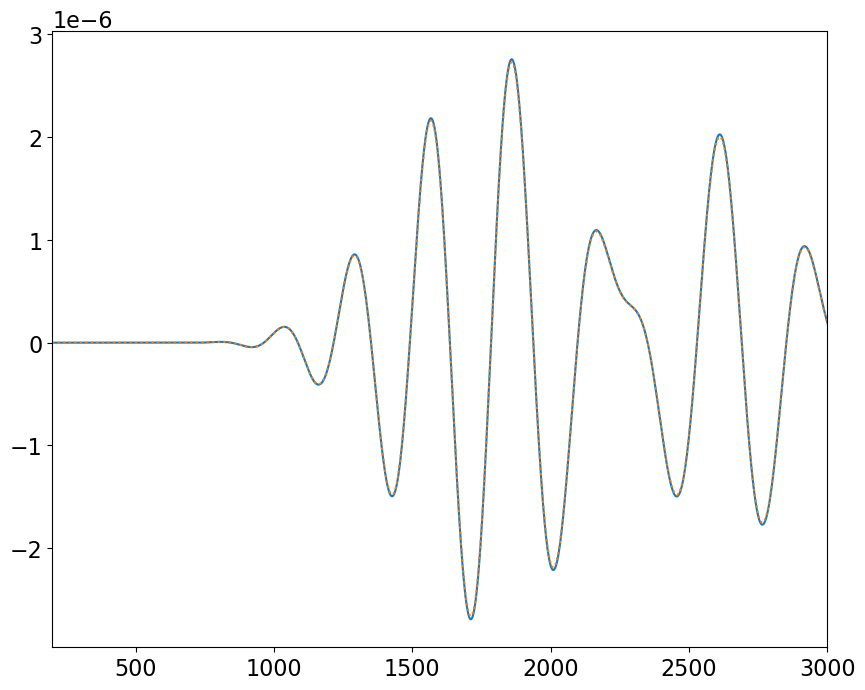

In [125]:
RHS_acc = (1/-dz) * Pa[1:-1,1:-1] * (2- ((4*vs_est_3D_Z_at_FS[:,:,np.newaxis]**2)/(vp_est_3D_Z_at_FS[:,:,np.newaxis]**2))) * (1/rho_gradd[1:-1,1:-1,0,np.newaxis]) 
RHS_acc_without = (1/-dz) * Pa[1:-1,1:-1] * (2- ((4*vs_est_3D_Z_at_FS[:,:,np.newaxis]**2)/vp_est_3D_Z_at_FS[:,:,np.newaxis]**2)) #* (1/rho_gradd[:,:,0,np.newaxis]) 


term1 = dttv3[1:-1,1:-1,0,:,0]
term2 = (2/-dz) * (vp_est_3D_Z_at_FS[:,:,np.newaxis]**2) * VEL_Z_gradZ_FDnotFS[1:-1,1:-1,:]
term3 = (vp_est_3D_Z_at_FS[:,:,np.newaxis]**2 - (2 * vs_est_3D_Z_at_FS[:,:,np.newaxis]**2)) * (VEL_Z_gradXX[1:-1,1:-1,0,:,0] + VEL_Z_gradYY[1:-1,1:-1,0,:,0])
LHS = term1 - term2 + term3

plt.figure(figsize=(10,8))
plt.plot(LHS[xx,yy,:])
#plt.plot(LHS_inhom[xx,yy,:]/np.max(LHS_inhom[xx,yy,:]), color='crimson')

#plt.plot(RHS[xx,yy,:]/np.max(RHS[xx,yy,:]))
plt.plot(RHS_acc[xx,yy,:],linestyle=':')
#plt.plot(RHS_without[xx,yy,:]/np.max(RHS_without[xx,yy,:]))
plt.xlim([200,3000])

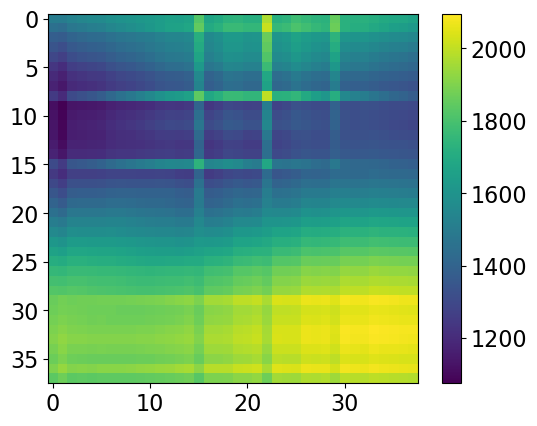

In [126]:
rho_, m, r_sq = LinReg_rho_surf(LHS,RHS_acc_without, nt_sub, ll, (nrx-2)**2, nrx, nry,order)
#rho_=1/rho_
plt.imshow(rho_)
plt.colorbar()

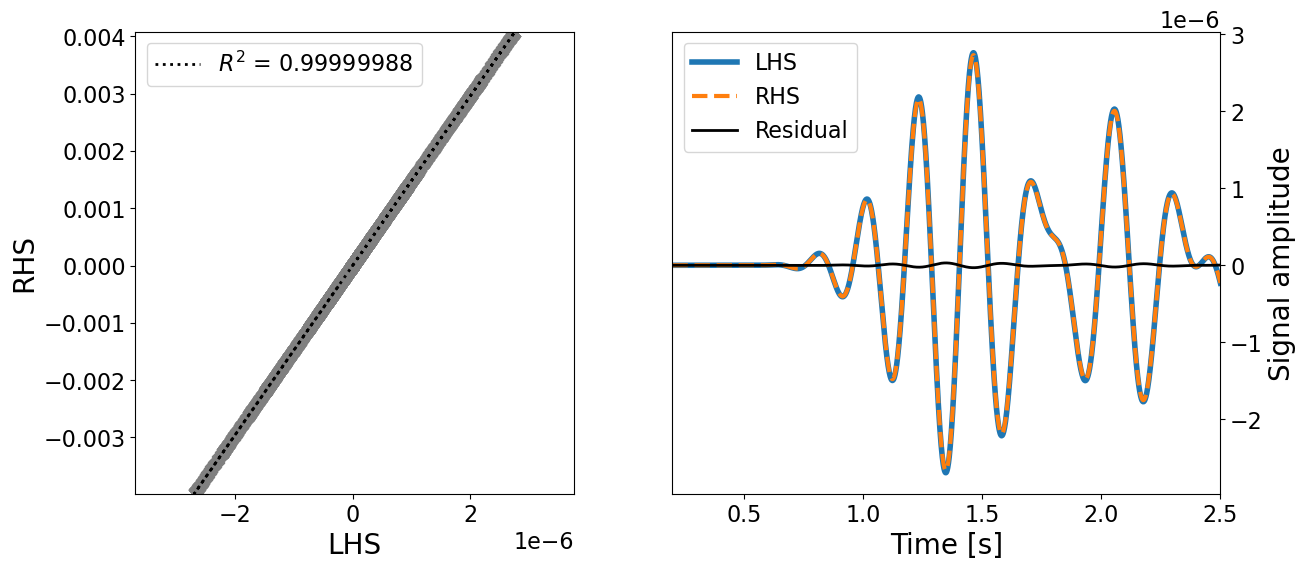

In [127]:
import matplotlib.ticker as ticker

t=np.linspace(0,nt_sub*dt_sub,nt_sub)
fig,(ax1,ax2)=plt.subplots(figsize=(14,6),ncols=2, gridspec_kw={'width_ratios': [0.8,1]})
#ax1.scatter(LHS[xx,yy],RHS_acc_without[xx,yy])
ax1.plot(LHS[xx,yy].reshape(-1, 1), m[xx,yy] * RHS_acc[xx,yy,:].reshape(-1, 1), c='black', linestyle=':',linewidth=2,label=f'$R^{2}$ = {np.round(r_sq[xx,yy][0],8)}')
ax1.scatter(LHS[xx,yy].reshape(-1, 1), m[xx,yy] * RHS_acc[xx,yy,:].reshape(-1, 1),s=50,linewidth=2,marker='x',color='grey')

ax1.set_xlabel('LHS',fontsize=20)
ax1.set_ylabel('RHS',fontsize=20)

ax2.plot(t,LHS[xx,yy,:], label='LHS',linewidth=4)
ax2.plot(t,RHS_acc[xx,yy],label='RHS', linestyle='--',linewidth=3)
ax2.plot(t,RHS_acc[xx,yy]-LHS[xx,yy,:],label='Residual',linewidth=2, color='black')

#plt.plot(RHS_acc_test[-1,-1])
#plt.legend()
plt.xlim([0.2,2.5])
ax2.set_xlabel('Time [s]',fontsize=20)
ax2.set_ylabel('Signal amplitude',fontsize=20)
#ax2.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.0e'))
#ax2.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.0e'))
#ax1.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.0e'))
#ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.0e'))
ax1.set_ylim([np.min(m[xx,yy] *RHS_acc[xx,yy,1:-1])-0.1e-08, np.max(m[xx,yy] *RHS_acc[xx,yy,1:-1])+0.1e-08])
ax1.set_xlim([np.min(LHS[xx,yy,1:-1])-0.1e-05, np.max(LHS[xx,yy,1:-1])+0.1e-05])
ax1.legend(fontsize=16)
ax2.legend(fontsize=16)
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()

In [128]:
rho_.shape

(38, 38, 1)

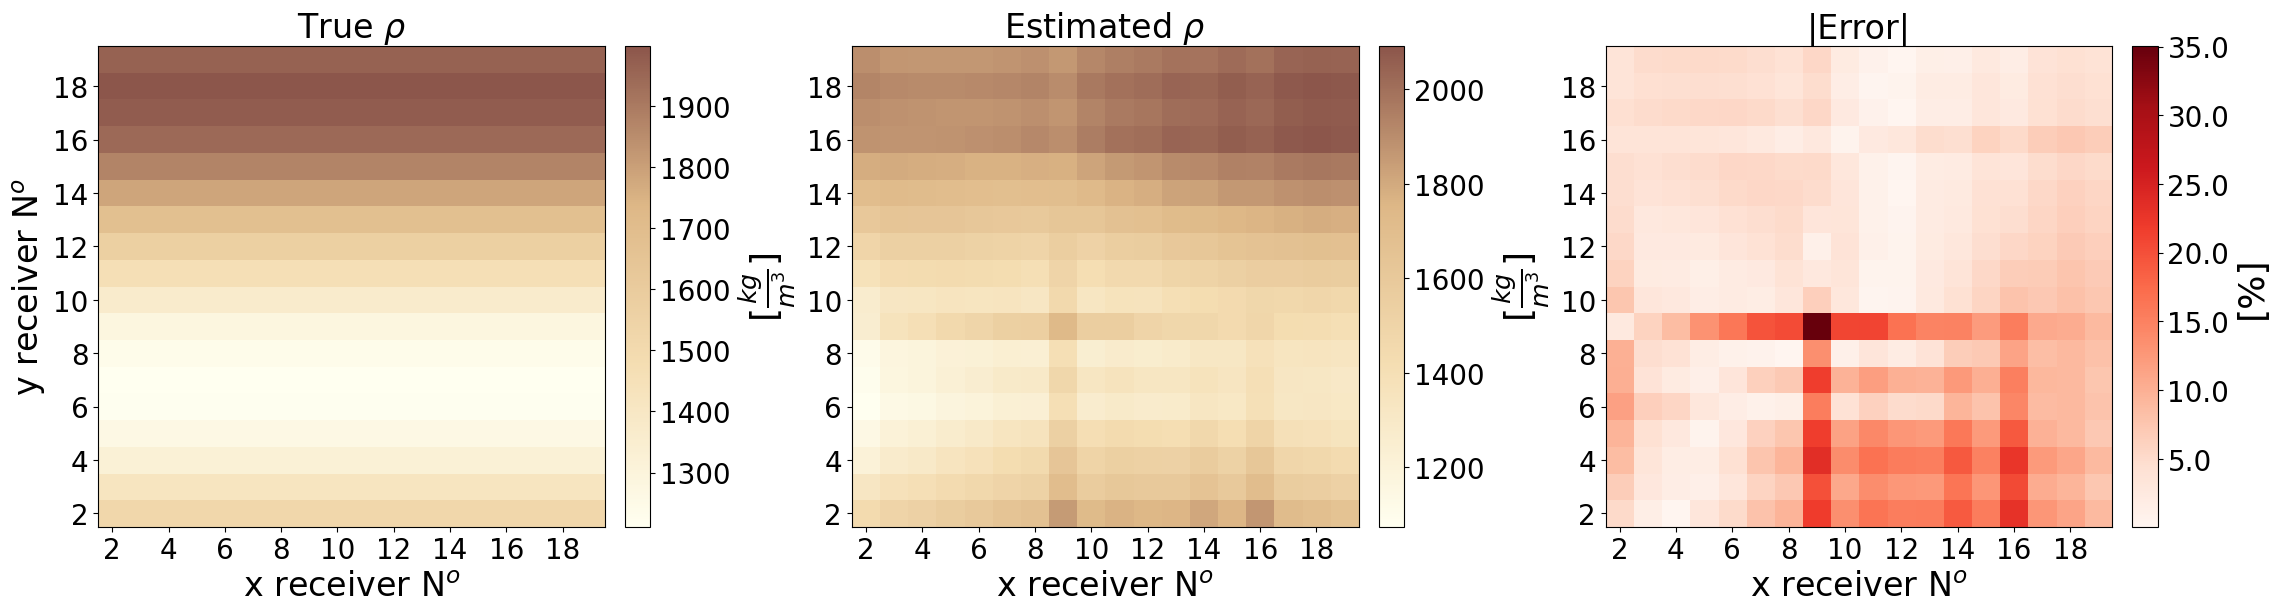

In [129]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(24,8),ncols=3,gridspec_kw={'width_ratios': [1,1,1]})
fig.tight_layout(pad=10.0)
rho_true= rho_grad.values[2:-2,2:-2,0]
rho_gradd= rho_grad.values[1:-1,1:-1,0]
rho_N = rho_[1:-1,1:-1]
rr=rho_true[::2,::2]

subb=2
############im1=ax1.imshow(abs(gradient_rho_TRUE[0,1:-1,1:-1]) ,vmin=np.min(abs(gradient_rho_TRUE[0,1:-1,1:-1])), vmax=np.max(abs(gradient_rho_TRUE[0,1:-1,1:-1])), aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])
im1=ax1.imshow(rr ,vmin=np.min(rho_true[::2,::2]), vmax=np.max(rho_true[::2,::2]),cmap=cmap1, aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr/subb-2+0.5,0.5,nr/subb-2+0.5])
#im1=ax1.imshow((rho_GRAD_true[1:-1,1:-1]) ,vmin=np.min((rho_GRAD_true[1:-1,1:-1])), vmax=np.max((rho_GRAD_true[1:-1,1:-1])), aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])

divider = make_axes_locatable(ax1)
ax11 = divider.append_axes('right', size='5%', pad=0.2)
cbar = plt.colorbar(im1, format='%.0f',cax=ax11)
cbar.set_label(label=r'$[\frac{kg}{m^{3}}]$',size=26)
ax1.set_xlabel(r'x receiver N$^{o}$',fontsize=24)
ax1.set_ylabel(r'y receiver N$^{o}$',fontsize=24)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)
ax1.set_title(r'True $\rho$',fontsize=24)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)
        
        
#im2=ax2.imshow(abs(store_grad_X[error_minX[0][0],1:-1,1:-1]) ,vmin=np.min(abs(rho_GRAD_X_true[1:-1,1:-1])), vmax=np.max(abs(rho_GRAD_X_true[1:-1,1:-1])),  aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])
im2=ax2.imshow(rho_N[::2,::2,0],  aspect='auto',cmap=cmap1, interpolation='none',origin='lower', extent=[0.5,nr/subb-2+0.5,0.5,nr/subb-2+0.5])#,vmin=np.min(rho_true[::2,::2]), vmax=np.max(rho_true[::2,::2]))
#im2=ax2.imshow((store_grad[min_MIS[0][0],1:-1,1:-1]),origin='lower' ,vmin=np.min((rho_GRAD_true[1:-1,1:-1])), vmax=np.max((rho_GRAD_true[1:-1,1:-1])),  aspect='auto', interpolation='none', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])

divider = make_axes_locatable(ax2)
ax22 = divider.append_axes('right', size='5%', pad=0.2)
cbar = plt.colorbar(im2, format='%.0f',cax=ax22)
cbar.set_label(label=r'$[\frac{kg}{m^{3}}]$',size=26)
ax2.set_xlabel(r'x receiver N$^{o}$',fontsize=24)
#ax2.set_ylabel(r'y receiver N$^{o}$',fontsize=20)
ax2.xaxis.set_tick_params(labelsize=20)
ax2.yaxis.set_tick_params(labelsize=20)
ax2.set_title(r'Estimated $\rho$',fontsize=24)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)

#im2=ax2.imshow(np.log(J_ACC[min_MIS_MEAN[0][0],1:-1,1:-1]),vmin=np.min(np.log(J_ACC[min_MIS_MEAN[0][0],1:-1,1:-1])), vmax=np.max(np.log(J_ACC[min_MIS_MEAN[0][0],1:-1,1:-1])), cmap='bwr',aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])
# im3=ax3.imshow(errorX[error_minX[0][0],:,:] ,vmin=-np.max(errorX[error_minX[0][0],:,:]), vmax=np.max(errorX[error_minX[0][0],:,:]), cmap='bwr',aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])
#im3=ax3.imshow((diff[error_min[0][0],:,:]) ,vmin=np.min((diff[error_min[0][0],:,:])), vmax=-np.min((diff[error_min[0][0],:,:])), cmap='bwr',aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])
#im3=ax3.imshow(abs(error[min_MIS[0][0],:,:]) ,vmin=np.min(abs(error[min_MIS[0][0],:,:])), vmax=np.max(abs(error[min_MIS[0][0],:,:])), cmap='Reds',aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])
#im3=ax3.imshow(abs(errorX_ABS[min_MIS[0][0],:,:]) ,vmin=np.min(abs(errorX_ABS[min_MIS[0][0],:,:])), vmax=np.max(abs(errorX_ABS[min_MIS[0][0],:,:])), cmap=Reds,aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])
diff=100*(abs((rho_true[::2,::2]-rho_N[::2,::2,0])/(rho_true[::2,::2])))
im3=ax3.imshow(diff ,vmin=np.min(diff), vmax=np.max(diff), cmap='Reds',aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr/subb-2+0.5,0.5,nr/subb-2+0.5])

#im3=ax3.imshow(np.log(abs(errorX_ABS[min_MIS[0][0],:,:])) ,vmin=np.min(np.log(abs(errorX_ABS[min_MIS[0][0],:,:]))), vmax=np.max(np.log(abs(errorX_ABS[min_MIS[0][0],:,:]))), cmap='Reds',aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])

#im3=ax3.imshow((errorX[min_MIS[0][0],:,:]) ,vmin=np.min((errorX[error_min[0][0],:,:])), vmax=np.max((errorX[error_min[0][0],:,:])), cmap='Reds',aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])
#im3=ax3.imshow((rho_GRAD_true[1:-1,1:-1]-store_grad[min_MIS[0][0],1:-1,1:-1]), cmap='Reds',aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])#vmin=np.min((error[error_min[0][0],:,:])), vmax=np.max((error[error_min[0][0],:,:])), cmap='Reds',aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])
#im3=ax3.imshow(np.log(J_ACC[min_MIS[0][0],1:-1,1:-1]),origin='lower' ,vmin=np.min(np.log(J_ACC[min_MIS[0][0],1:-1,1:-1])), vmax=np.max(np.log(J_ACC[min_MIS[0][0],1:-1,1:-1])),  cmap='Reds',aspect='auto', interpolation='none', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])

#im3=ax3.imshow((error_rel[error_min[0][0],:,:]) ,vmin=np.min((error_rel[error_min[0][0],:,:])), vmax=np.max((error_rel[error_min[0][0],:,:])), cmap='bwr',aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])

#im3=ax3.imshow(np.log(abs(error[error_min[0][0],:,:])) ,vmin=np.min(np.log(abs(error[error_min[0][0],:,:]))), vmax=np.max(np.log(abs(error[error_min[0][0],:,:]))), cmap='Reds',aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])

divider = make_axes_locatable(ax3)
ax33 = divider.append_axes('right', size='5%', pad=0.2)
cbar = plt.colorbar(im3, format='%.1f',cax=ax33)
cbar.set_label(label='[%]',size=26)
#cbar.set_label(label=r'$[\frac{kg}{m^{3}}]$',size=26)
ax3.set_title('|Error|',fontsize=24)
#ax3.set_title('|Absolute Error|',fontsize=24)

ax3.set_xlabel(r'x receiver N$^{o}$',fontsize=24)
#plt.ylabel(r'y receiver N$^{o}$',fontsize=20)
ax3.xaxis.set_tick_params(labelsize=20)
ax3.yaxis.set_tick_params(labelsize=20)
start, end = ax1.get_xlim()
ax3.xaxis.set_ticks(np.arange(start+1.5, end+0.5, 4))
ax1.xaxis.set_ticks(np.arange(start+1.5, end+0.5, 4))
ax3.yaxis.set_ticks(np.arange(start+1.5, end+0.5, 4))
ax1.yaxis.set_ticks(np.arange(start+1.5, end+0.5, 4))

start, end = ax2.get_xlim()
ax2.xaxis.set_ticks(np.arange(start+1.5, end, 4))
ax2.yaxis.set_ticks(np.arange(start+1.5, end+0.5, 4))
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)
        
ax1.set_xticks([1,3,5,7,9,11,13,15,17])
ax1.set_xticklabels(['2','4','6','8','10','12','14','16','18'])
ax1.set_yticks([1,3,5,7,9,11,13,15,17])
ax1.set_yticklabels(['2','4','6','8','10','12','14','16','18'])

ax2.set_xticks([1,3,5,7,9,11,13,15,17])
ax2.set_xticklabels(['2','4','6','8','10','12','14','16','18'])
ax2.set_yticks([1,3,5,7,9,11,13,15,17])
ax2.set_yticklabels(['2','4','6','8','10','12','14','16','18'])

ax3.set_xticks([1,3,5,7,9,11,13,15,17])
ax3.set_xticklabels(['2','4','6','8','10','12','14','16','18'])
ax3.set_yticks([1,3,5,7,9,11,13,15,17])
ax3.set_yticklabels(['2','4','6','8','10','12','14','16','18'])

# ax1.set_xticks([1,4,9,14,19,24,29,34,38])
# ax1.set_xticklabels(['2','5','10','15','20','25','30','35','39'])
# ax1.set_yticks([1,4,9,14,19,24,29,34,38])
# ax1.set_yticklabels(['2','5','10','15','20','25','30','35','39'])

# ax2.set_xticks([1,4,9,14,19,24,29,34,38])
# ax2.set_xticklabels(['2','5','10','15','20','25','30','35','39'])
# ax2.set_yticks([1,4,9,14,19,24,29,34,38])
# ax2.set_yticklabels(['2','5','10','15','20','25','30','35','39'])

# ax3.set_xticks([1,4,9,14,19,24,29,34,38])
# ax3.set_xticklabels(['2','5','10','15','20','25','30','35','39'])
# ax3.set_yticks([1,4,9,14,19,24,29,34,38])
# ax3.set_yticklabels(['2','5','10','15','20','25','30','35','39'])

plt.show() 
 

In [130]:
print(rho_[stx,sty][0])
print(np.mean(rho_[:,:][0]))

print(rho_grad[stx,sty,0].data)
print(np.mean(rho_grad[:,:,0].data))

1244.9431309820955
1678.3457729411844
1215.23299239278
1583.7604708097278


In [131]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
np.mean(diff)

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(24,8),ncols=3,gridspec_kw={'width_ratios': [1,1,1]})
fig.tight_layout(pad=10.0)
vp_true= vp_sub[2:-2,2:-2,0]
vp_true = vp_true[::2,::2]
vp_est = vp_est_3D_Z_at_FS[1:-1,1:-1]
vp_est = vp_est[::2,::2]


subb=2
############im1=ax1.imshow(abs(gradient_rho_TRUE[0,1:-1,1:-1]) ,vmin=np.min(abs(gradient_rho_TRUE[0,1:-1,1:-1])), vmax=np.max(abs(gradient_rho_TRUE[0,1:-1,1:-1])), aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])
im1=ax1.imshow(vp_true ,vmin=np.min(vp_true), vmax=np.max(vp_true),cmap='YlGnBu', aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr/subb-2+0.5,0.5,nr/subb-2+0.5])
#im1=ax1.imshow((rho_GRAD_true[1:-1,1:-1]) ,vmin=np.min((rho_GRAD_true[1:-1,1:-1])), vmax=np.max((rho_GRAD_true[1:-1,1:-1])), aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])

divider = make_axes_locatable(ax1)
ax11 = divider.append_axes('right', size='5%', pad=0.2)
cbar = plt.colorbar(im1, format='%.0f',cax=ax11)
cbar.set_label(label=r'$[\frac{m}{s}]$',size=26)
ax1.set_xlabel(r'x receiver N$^{o}$',fontsize=24)
ax1.set_ylabel(r'y receiver N$^{o}$',fontsize=24)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)
ax1.set_title(r'True $v_{p}$',fontsize=24)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)
        
        
im2=ax2.imshow(vp_est ,vmin=np.min(vp_true), vmax=np.max(vp_true),  aspect='auto',cmap='YlGnBu', interpolation='none',origin='lower', extent=[0.5,nr/subb-2+0.5,0.5,nr/subb-2+0.5])

divider = make_axes_locatable(ax2)
ax22 = divider.append_axes('right', size='5%', pad=0.2)
cbar = plt.colorbar(im2, format='%.0f',cax=ax22)
cbar.set_label(label=r'$[\frac{m}{s}]$',size=26)
ax2.set_xlabel(r'x receiver N$^{o}$',fontsize=24)
#ax2.set_ylabel(r'y receiver N$^{o}$',fontsize=20)
ax2.xaxis.set_tick_params(labelsize=20)
ax2.yaxis.set_tick_params(labelsize=20)
ax2.set_title(r'Estimated $v_{p}$',fontsize=24)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)

diff=100*(abs((vp_true-vp_est)/(vp_true)))
im3=ax3.imshow(diff ,vmin=np.min(diff), vmax=np.max(diff), cmap='Reds',aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr/subb-2+0.5,0.5,nr/subb-2+0.5])

divider = make_axes_locatable(ax3)
ax33 = divider.append_axes('right', size='5%', pad=0.2)
cbar = plt.colorbar(im3, format='%.1f',cax=ax33)
cbar.set_label(label='[%]',size=26)
#cbar.set_label(label=r'$[\frac{kg}{m^{3}}]$',size=26)
ax3.set_title('|Error|',fontsize=24)
#ax3.set_title('|Absolute Error|',fontsize=24)

ax3.set_xlabel(r'x receiver N$^{o}$',fontsize=24)
#plt.ylabel(r'y receiver N$^{o}$',fontsize=20)
ax3.xaxis.set_tick_params(labelsize=20)
ax3.yaxis.set_tick_params(labelsize=20)
start, end = ax1.get_xlim()
ax3.xaxis.set_ticks(np.arange(start+1.5, end+0.5, 4))
ax1.xaxis.set_ticks(np.arange(start+1.5, end+0.5, 4))
ax3.yaxis.set_ticks(np.arange(start+1.5, end+0.5, 4))
ax1.yaxis.set_ticks(np.arange(start+1.5, end+0.5, 4))

start, end = ax2.get_xlim()
ax2.xaxis.set_ticks(np.arange(start+1.5, end, 4))
ax2.yaxis.set_ticks(np.arange(start+1.5, end+0.5, 4))
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)
        
ax1.set_xticks([1,3,5,7,9,11,13,15,17])
ax1.set_xticklabels(['2','4','6','8','10','12','14','16','18'])
ax1.set_yticks([1,3,5,7,9,11,13,15,17])
ax1.set_yticklabels(['2','4','6','8','10','12','14','16','18'])

ax2.set_xticks([1,3,5,7,9,11,13,15,17])
ax2.set_xticklabels(['2','4','6','8','10','12','14','16','18'])
ax2.set_yticks([1,3,5,7,9,11,13,15,17])
ax2.set_yticklabels(['2','4','6','8','10','12','14','16','18'])

ax3.set_xticks([1,3,5,7,9,11,13,15,17])
ax3.set_xticklabels(['2','4','6','8','10','12','14','16','18'])
ax3.set_yticks([1,3,5,7,9,11,13,15,17])
ax3.set_yticklabels(['2','4','6','8','10','12','14','16','18'])


In [ ]:
rho_grad.shape

In [ ]:
vs_true= vs_sub[2:-2,2:-2,0]
vs_true = vs_true[::2,::2]
vs_est = vs_est_3D_Z_at_FS[1:-1,1:-1]
vs_est = vs_est[::2,::2]

mu = vs_true**2 * rho_true[::2,::2]
lam = (vp_true**2 * rho_true[::2,::2]) - (2*mu)

mu_est = vs_est**2 * rho_N[::2,::2,0]
lam_est = (vp_est**2 * rho_N[::2,::2,0]) - (2*mu_est)
lam_est = (vp_est**2 - (2*vs_est**2)) * rho_N[::2,::2,0]

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(24,8),ncols=3,gridspec_kw={'width_ratios': [1,1,1]})
fig.tight_layout(pad=11.0,)


subb=2
############im1=ax1.imshow(abs(gradient_rho_TRUE[0,1:-1,1:-1]) ,vmin=np.min(abs(gradient_rho_TRUE[0,1:-1,1:-1])), vmax=np.max(abs(gradient_rho_TRUE[0,1:-1,1:-1])), aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])
im1=ax1.imshow(lam ,vmin=np.min(lam), vmax=np.max(lam),cmap='RdYlBu', aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr/subb-2+0.5,0.5,nr/subb-2+0.5])
#im1=ax1.imshow((rho_GRAD_true[1:-1,1:-1]) ,vmin=np.min((rho_GRAD_true[1:-1,1:-1])), vmax=np.max((rho_GRAD_true[1:-1,1:-1])), aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])

divider = make_axes_locatable(ax1)
ax11 = divider.append_axes('right',size='5%', pad=0.2)
cbar = plt.colorbar(im1, format='%.1e',cax=ax11)
cbar.set_label(label=r'$[-]$',size=26)
ax1.set_xlabel(r'x receiver N$^{o}$',fontsize=24)
ax1.set_ylabel(r'y receiver N$^{o}$',fontsize=24)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)
ax1.set_title(r'True $\lambda$',fontsize=24)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)
        
        
im2=ax2.imshow(lam_est ,vmin=np.min(lam), vmax=np.max(lam),  aspect='auto',cmap='RdYlBu', interpolation='none',origin='lower', extent=[0.5,nr/subb-2+0.5,0.5,nr/subb-2+0.5])

divider = make_axes_locatable(ax2)
ax22 = divider.append_axes('right', size='5%', pad=0.2)
cbar = plt.colorbar(im2, format='%.1e',cax=ax22)
cbar.set_label(label=r'$[-]$',size=26)
ax2.set_xlabel(r'x receiver N$^{o}$',fontsize=24)
#ax2.set_ylabel(r'y receiver N$^{o}$',fontsize=20)
ax2.xaxis.set_tick_params(labelsize=20)
ax2.yaxis.set_tick_params(labelsize=20)
ax2.set_title(r'Estimated $\lambda$',fontsize=24)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)

diff=100*(abs((lam-lam_est)/(lam)))
im3=ax3.imshow(diff ,vmin=np.min(diff), vmax=np.max(diff), cmap='Reds',aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr/subb-2+0.5,0.5,nr/subb-2+0.5])

divider = make_axes_locatable(ax3)
ax33 = divider.append_axes('right', size='5%', pad=0.2)
cbar = plt.colorbar(im3, format='%.1f',cax=ax33)
cbar.set_label(label='[%]',size=26)
#cbar.set_label(label=r'$[\frac{kg}{m^{3}}]$',size=26)
ax3.set_title('|Error|',fontsize=24)
#ax3.set_title('|Absolute Error|',fontsize=24)

ax3.set_xlabel(r'x receiver N$^{o}$',fontsize=24)
#plt.ylabel(r'y receiver N$^{o}$',fontsize=20)
ax3.xaxis.set_tick_params(labelsize=20)
ax3.yaxis.set_tick_params(labelsize=20)
start, end = ax1.get_xlim()
ax3.xaxis.set_ticks(np.arange(start+1.5, end+0.5, 4))
ax1.xaxis.set_ticks(np.arange(start+1.5, end+0.5, 4))
ax3.yaxis.set_ticks(np.arange(start+1.5, end+0.5, 4))
ax1.yaxis.set_ticks(np.arange(start+1.5, end+0.5, 4))

start, end = ax2.get_xlim()
ax2.xaxis.set_ticks(np.arange(start+1.5, end, 4))
ax2.yaxis.set_ticks(np.arange(start+1.5, end+0.5, 4))
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)
        
ax1.set_xticks([1,3,5,7,9,11,13,15,17])
ax1.set_xticklabels(['2','4','6','8','10','12','14','16','18'])
ax1.set_yticks([1,3,5,7,9,11,13,15,17])
ax1.set_yticklabels(['2','4','6','8','10','12','14','16','18'])

ax2.set_xticks([1,3,5,7,9,11,13,15,17])
ax2.set_xticklabels(['2','4','6','8','10','12','14','16','18'])
ax2.set_yticks([1,3,5,7,9,11,13,15,17])
ax2.set_yticklabels(['2','4','6','8','10','12','14','16','18'])

ax3.set_xticks([1,3,5,7,9,11,13,15,17])
ax3.set_xticklabels(['2','4','6','8','10','12','14','16','18'])
ax3.set_yticks([1,3,5,7,9,11,13,15,17])
ax3.set_yticklabels(['2','4','6','8','10','12','14','16','18'])
#fig.tight_layout()

In [ ]:
nr/subb -2

In [ ]:
fig,(ax1,ax2) = plt.subplots(figsize=(22,12),ncols=2, gridspec_kw={'width_ratios': [1.1,0.9]})
#ax1.scatter(np.arange(0,len(rho_grad[1:-1,1:-1,0].flatten()/18)),rho_grad[1:-1,1:-1,0].flatten()/18, label = 'True model', linewidth=2, color='tab:blue', marker='o',s=10)
#rrr = np.reshape(rr, (nr,nr))

subb =2
n4 =1
c4 ='brown'

ax1.plot(np.arange(2,nr/subb ),( (rho_N[::subb,::subb,0].sum(1))).T.flatten()/(nr/subb -2),  linewidth=3, color=c4, markersize=20, marker='o', markerfacecolor='none', markeredgewidth=3)


box = ax1.get_position()
ax1.set_position([box.x0, box.y0, box.width , box.height])

# Put a legend to the right of the current axis
#ax1.legend(fontsize=18, ncol=1,loc='upper left')# bbox_to_anchor=(-0.2, 1))
################


n11 = 1
c11 = 'brown'
ax2.plot(np.arange(2,nr/subb ),((rho_N[::subb,::subb,0].sum(0))).T.flatten()/(nr/subb -2),  markersize=20, marker='o', markerfacecolor='none', markeredgewidth=3,  color=c11)


ax1.set_xlim([2-0.2,nr/subb  -1+0.2])    
ax2.set_xlim([2-0.2,nr/subb  -1+0.2])  

ax1.plot(np.arange(2,nr/subb ),rho_true[::subb,::subb].sum(1).T.flatten()/(nr/subb -2), linewidth=4, color='blue', label = 'True model', linestyle='--')

ax2.plot(np.arange(2,nr/subb ),rho_true[::subb,::subb].sum(0).T.flatten()/(nr/subb -2), linewidth=4, color='blue', label = 'True model', linestyle='--')
ax1.set_xlabel(r'y receiver N$^{o}$',fontsize=26)
ax2.set_xlabel(r'x receiver N$^{o}$',fontsize=26)
ax1.set_ylabel(r'Density [$\frac{kg}{m^3}$]',fontsize=30)
ax1.xaxis.set_tick_params(labelsize=24)
ax1.yaxis.set_tick_params(labelsize=24)
ax2.xaxis.set_tick_params(labelsize=24)
ax2.yaxis.set_tick_params(labelsize=24)

start, end = ax1.get_xlim()
ax1.xaxis.set_ticks(np.arange(start+0.2, end+0.2, 2))
start, end = ax2.get_xlim()
ax2.xaxis.set_ticks(np.arange(start+0.2, end+0.2, 2))
ax2.set_ylim([1420,1700])
ax1.set_ylim([1130,2050])

In [ ]:
# MISFIT
stx_int=stx-1
sty_int=sty-1


len_test = 200 #80# 120

rho_test = np.linspace(rho_grad.values[stx,sty,0]-(0.5*rho_grad.values[stx,sty,0]),rho_grad.values[stx,sty,0]+(0.5*rho_grad.values[stx,sty,0]),len_test)
rho_test = np.append(rho_test, rho_grad.values[stx,sty,0])
rho_test = np.sort(rho_test)

vp_test = np.linspace(vp_sub[stx,sty,0]-(0.5*vp_sub[stx,sty,0]),vp_sub[stx,sty,0]+(0.5*vp_sub[stx,sty,0]),len_test+50)
vp_test = np.append(vp_test, vp_sub[stx,sty,0])
vp_test = np.sort(vp_test)
# vs_test = np.linspace(vs_sub[stx,sty,0]-(0.4*vs_sub[stx,sty,0]),vs_sub[stx,sty,0]+(0.4*vs_sub[stx,sty,0]),len_test+50)
# vs_test = np.append(vs_test, vs_sub[stx,sty,0])
# vs_test = np.sort(vs_test)
vs_test = vp_test/ (vp_est/vs_est)[stx,sty]# np.sqrt(3)

xv_vp, yv_rho = np.meshgrid(vp_test, rho_test, indexing='ij')
xv_vs =xv_vp/ (vp_est/vs_est)[stx,sty]# np.sqrt(3)

In [ ]:
#yv_rho==yv_rho2

In [ ]:
rho_[stx-1,sty-1]

In [ ]:
RHS_acc_test = (1/-dz) * Pa[np.newaxis,np.newaxis,stx,sty,:] * (2- ((4*xv_vs[:,:,np.newaxis]**2)/xv_vp[:,:,np.newaxis]**2)) * (1/yv_rho[:,:,np.newaxis]) 

term1 = dttv3[1:-1,1:-1,0,:,0]
term2 = (2/-dz) * (vp_est_3D_Z_at_FS[:,:,np.newaxis]**2) * VEL_Z_gradZ_FDnotFS[1:-1,1:-1]
term3 = (vp_est_3D_Z_at_FS[:,:,np.newaxis]**2 - (2 * vs_est_3D_Z_at_FS[:,:,np.newaxis]**2)) * (VEL_Z_gradXX[1:-1,1:-1,0,:,0] + VEL_Z_gradYY[1:-1,1:-1,0,:,0])
#term2 = (2/dz) * (xv_vp[:,:,np.newaxis]**2) * VEL_Z_gradZ_FDnotFS[np.newaxis,np.newaxis,stx,sty,:]
#term3 = (xv_vp[:,:,np.newaxis]**2 - (2 * xv_vs[:,:,np.newaxis]**2)) * (VEL_Z_gradXX[np.newaxis,np.newaxis,stx,sty,0,:,0] + VEL_Z_gradYY[np.newaxis,np.newaxis,stx,sty,0,:,0])
# RHS_acc_test = RHS_acc_test + term2 - term3
LHS_test = term1 - term2 + term3
misfit_test = np.log(((RHS_acc_test-LHS_test[stx_int,sty_int])**2).sum(2) / (nt_sub-2))
ind_min2 = np.argwhere(misfit_test==np.min(misfit_test))
ind_min2[0][1]

plt.figure(figsize=(11,9))
im=plt.imshow(misfit_test,extent=[rho_test[0],rho_test[-1],vp_test[0],vp_test[-1]],cmap='hsv_r', aspect=0.6)#, vmin=-7.1, vmax=-0.2)#4
plt.plot(np.ones((vp_test.shape))*rho_grad.values[stx,sty,0],vp_test, color='w', linestyle='--', linewidth=3, label=r'True $\rho$         : '+ str(np.round(rho_grad.values[stx,sty,0],1)) + r' $\frac{kg}{m^{3}}$')
plt.plot(np.ones((vp_test.shape))*(rho_test[ind_min2[0][1]]),vp_test, color='yellow', linestyle='--', linewidth=2.5, label=r'Min misfit $\rho$ : '+ str(np.round(rho_test[ind_min2[0][1]],1))+ r' $\frac{kg}{m^{3}}$')
plt.plot(np.ones((vp_test.shape))*(rho_[stx-1,sty-1]),vp_test, color='black', linestyle=':', linewidth=2.5, label=r'Inverted $\rho$   : '+ str(np.round(rho_[stx-1,sty-1][0],1))+ r' $\frac{kg}{m^{3}}$')

# im=plt.imshow(misfit_test,extent=[rho_test[0],rho_test[-1],vs_test[-1]/vp_test[-1],vs_test[0]/vp_test[0]],cmap='hsv_r', aspect=6000)#, vmin=-7.1, vmax=-0.2)#4

# plt.plot(np.ones((vp_test.shape))*rho_grad.values[stx,sty,0],vs_test/vp_test, color='w', linestyle='--', linewidth=3, label=r'True $\rho$         : '+ str(np.round(rho_grad.values[stx,sty,0],1)) + r' $\frac{kg}{m^{3}}$')
# plt.plot(np.ones((vp_test.shape))*(rho_test[ind_min2[0][1]]),vs_test/vp_test, color='yellow', linestyle='--', linewidth=2.5, label=r'Min misfit $\rho$ : '+ str(np.round(rho_test[ind_min2[0][1]],1))+ r' $\frac{kg}{m^{3}}$')
# plt.plot(np.ones((vp_test.shape))*(rho_[stx-1,sty-1]),vs_test/vp_test, color='black', linestyle=':', linewidth=2.5, label=r'Inverted $\rho$   : '+ str(np.round(rho_[stx-1,sty-1][0],1))+ r' $\frac{kg}{m^{3}}$')

cbar = plt.colorbar(im, format='%.2f')
cbar.set_label(label=r'Misfit log($\delta_{d}$)',size=20)
plt.xlabel(r'Density [$\frac{kg}{m^{3}}$]', fontsize=20)
plt.ylabel(r'$v_{p}$ [$\frac{m}{s}$]', fontsize=20)
#props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
#plt.text(-0.4, 0.1, r'True $ \rho$ : ' + str(np.round(rho_grad.values[stx,sty,0],1)) + r' $\frac{kg}{m^{3}}$' ' \n' r'Estimated $  \rho$ : '+ str(np.round(rho_test[ind_min2[0][1]],1)) + r' $\frac{kg}{m^{3}}$', transform=ax.transAxes, fontsize=14,
#        verticalalignment='top', bbox=props)
legend = plt.legend(fontsize=14, loc='upper right', facecolor='white', framealpha=0.6)


In [ ]:
vs_true[stx,sty]/vp_true[stx,sty]

In [ ]:
vs_test[ind_min2[0][0]]/vp_test[ind_min2[0][0]]
#vp_true[stx,sty]

In [ ]:
(vp_est/vs_est)[stx,sty]

In [ ]:
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111,projection='3d')
im=ax.plot_surface((xv_vp),(yv_rho),misfit_test,  cmap='viridis',rcount=misfit_test.shape[0], ccount=misfit_test.shape[1], zorder=10)
cbar = plt.colorbar(im, format='%.2f')
cbar.set_label(label=r'Misfit log($\delta_{d}$)',size=18)

ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
for t in cbar.ax.get_yticklabels():
         t.set_fontsize(14)
plt.ylabel(r'Density [$kg/m^{3}$]', fontsize=20)
plt.xlabel(r'Vp [m/s]', fontsize=20)
plt.show()

In [ ]:
# MISFIT
stx_int=stx-1
sty_int=sty-1


len_test = 200 #80# 120

rho_test = np.linspace(rho_grad.values[stx,sty,0]-(0.5*rho_grad.values[stx,sty,0]),rho_grad.values[stx,sty,0]+(0.5*rho_grad.values[stx,sty,0]),len_test)
rho_test = np.append(rho_test, rho_grad.values[stx,sty,0])
rho_test = np.sort(rho_test)

vp_test = np.linspace(vp_sub[stx,sty,0]-(0.5*vp_sub[stx,sty,0]),vp_sub[stx,sty,0]+(0.5*vp_sub[stx,sty,0]),len_test+50)
vp_test = np.append(vp_test, vp_sub[stx,sty,0])
vp_test = np.sort(vp_test)
vs_test = np.linspace(vs_sub[stx,sty,0]-(0.7*vs_sub[stx,sty,0]),vs_sub[stx,sty,0]+(0.7*vs_sub[stx,sty,0]),len_test+50)
vs_test = np.append(vs_test, vs_sub[stx,sty,0])
vs_test = np.sort(vs_test)
#vs_test = vp_test/ 1.735367396007023# np.sqrt(3)

xv_vp, yv_rho = np.meshgrid(vp_test, rho_test, indexing='ij')
xv_vs, yv_rho2 = np.meshgrid(vs_test, rho_test, indexing='ij')#
#xv_vs =xv_vp/ np.sqrt(3)

ratio_test = (4*vs_test**2) / vp_test**2
xv_ratio, yv_rho = np.meshgrid(ratio_test, rho_test, indexing='ij')

In [ ]:
RHS_acc_test = (1/-dz) * Pa[np.newaxis,np.newaxis,stx,sty,:] * (2- (xv_ratio[:,:,np.newaxis]**2)) * (1/yv_rho[:,:,np.newaxis]) 

term1 = dttv3[1:-1,1:-1,0,:,0]
term2 = (2/-dz) * (vp_est_3D_Z_at_FS[:,:,np.newaxis]**2) * VEL_Z_gradZ_FDnotFS[1:-1,1:-1]
term3 = (vp_est_3D_Z_at_FS[:,:,np.newaxis]**2 - (2 * vs_est_3D_Z_at_FS[:,:,np.newaxis]**2)) * (VEL_Z_gradXX[1:-1,1:-1,0,:,0] + VEL_Z_gradYY[1:-1,1:-1,0,:,0])
#term2 = (2/dz) * (xv_vp[:,:,np.newaxis]**2) * VEL_Z_gradZ_FDnotFS[np.newaxis,np.newaxis,stx,sty,:]
#term3 = (xv_vp[:,:,np.newaxis]**2 - (2 * xv_vs[:,:,np.newaxis]**2)) * (VEL_Z_gradXX[np.newaxis,np.newaxis,stx,sty,0,:,0] + VEL_Z_gradYY[np.newaxis,np.newaxis,stx,sty,0,:,0])
# RHS_acc_test = RHS_acc_test + term2 - term3
LHS_test = term1 - term2 + term3
misfit_test = np.log(((RHS_acc_test-LHS_test[stx_int,sty_int])**2).sum(2) / (nt_sub-2))
ind_min2 = np.argwhere(misfit_test==np.min(misfit_test))
ind_min2[0][1]

plt.figure(figsize=(11,9))
# im=plt.imshow(misfit_test,extent=[rho_test[0],rho_test[-1],vp_test[0],vp_test[-1]],cmap='hsv_r', aspect=0.6)#, vmin=-7.1, vmax=-0.2)#4
# plt.plot(np.ones((vp_test.shape))*rho_grad.values[stx,sty,0],vp_test, color='w', linestyle='--', linewidth=3, label=r'True $\rho$         : '+ str(np.round(rho_grad.values[stx,sty,0],1)) + r' $\frac{kg}{m^{3}}$')
# plt.plot(np.ones((vp_test.shape))*(rho_test[ind_min2[0][1]]),vp_test, color='yellow', linestyle='--', linewidth=2.5, label=r'Min misfit $\rho$ : '+ str(np.round(rho_test[ind_min2[0][1]],1))+ r' $\frac{kg}{m^{3}}$')
# plt.plot(np.ones((vp_test.shape))*(rho_[stx-1,sty-1]),vp_test, color='black', linestyle=':', linewidth=2.5, label=r'Inverted $\rho$   : '+ str(np.round(rho_[stx-1,sty-1][0],1))+ r' $\frac{kg}{m^{3}}$')

im=plt.imshow(misfit_test,extent=[rho_test[0],rho_test[-1],ratio_test[-1],ratio_test[0]],cmap='hsv_r', aspect=1000)#, vmin=-7.1, vmax=-0.2)#4

plt.plot(np.ones((vp_test.shape))*rho_grad.values[stx,sty,0],ratio_test, color='w', linestyle='--', linewidth=3, label=r'True $\rho$         : '+ str(np.round(rho_grad.values[stx,sty,0],1)) + r' $\frac{kg}{m^{3}}$')
plt.plot(np.ones((vp_test.shape))*(rho_test[ind_min2[0][1]]),ratio_test, color='yellow', linestyle='--', linewidth=2.5, label=r'Min misfit $\rho$ : '+ str(np.round(rho_test[ind_min2[0][1]],1))+ r' $\frac{kg}{m^{3}}$')
plt.plot(np.ones((vp_test.shape))*(rho_[stx-1,sty-1]),ratio_test, color='black', linestyle=':', linewidth=2.5, label=r'Inverted $\rho$   : '+ str(np.round(rho_[stx-1,sty-1][0],1))+ r' $\frac{kg}{m^{3}}$')

cbar = plt.colorbar(im, format='%.2f')
cbar.set_label(label=r'Misfit log($\delta_{d}$)',size=20)
plt.xlabel(r'Density [$\frac{kg}{m^{3}}$]', fontsize=20)
plt.ylabel(r'$v_{p}$ [$\frac{m}{s}$]', fontsize=20)
#props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
#plt.text(-0.4, 0.1, r'True $ \rho$ : ' + str(np.round(rho_grad.values[stx,sty,0],1)) + r' $\frac{kg}{m^{3}}$' ' \n' r'Estimated $  \rho$ : '+ str(np.round(rho_test[ind_min2[0][1]],1)) + r' $\frac{kg}{m^{3}}$', transform=ax.transAxes, fontsize=14,
#        verticalalignment='top', bbox=props)
legend = plt.legend(fontsize=14, loc='upper right', facecolor='white', framealpha=0.6)


In [ ]:
ratio_test[ind_min2[0][0]]# = (4*vs_test**2) / vp_test**2

In [ ]:
ratio_true = (4*vs_true**2) / vp_true**2
ratio_true[stx,sty]

In [ ]:
xv_ratio[ind_min2[0][0],ind_min2[0][1]]
#xv_vs[ind_min2[0][0],ind_min2[0][1]]
#yv_rho[ind_min2[0][0],ind_min2[0][1]]

In [ ]:
print((ratio_test)[ind_min2[0][0]])
print(rho_test[ind_min2[0][1]])

In [ ]:
break

In [ ]:
print(dist_r)
print(dx)
print(dy)
print(dz)

## Results - vp & vs depth profile
- ### 3D Elastic Wave Equation

In [ ]:
vs_est = vs_est_3eq
vp_est = vp_est_3eq

In [ ]:
s_vec1 = np.ones(vp_est[posX,posY,:].shape[0]) * sz

plt.figure(figsize=(10,8))
plt.plot(np.linspace(np.min(vs_sub)-100,np.max(vp_sub)+100,vp_est[posX,posY,:].shape[0]), s_vec1, label= 'Source Depth at '+str(sz)+'m', linestyle=':', color='gold')
plt.scatter(vp_est[posX,posY,:],np.linspace(0,nrz-2, vp_est[posX,posY,::-1].shape[0]), label = 'Estimated vp Model', s=20, color='lightgreen')
plt.scatter(vs_est[posX,posY,:],np.linspace(0,nrz-2, vp_est[posX,posY,::-1].shape[0]), label = 'Estimated vs Model', s=20, color='orange')
plt.plot(vp_sub[posX,posY,:],np.linspace(0,nrz-2, len(vp_sub[posX,posY,:])), label = 'True vp Model',linestyle=':', linewidth='3')
plt.plot(vs_sub[posX,posY,:],np.linspace(0,nrz-2, len(vs_sub[posX,posY,:])), label = 'True vs Model', color='blue',linestyle=':', linewidth='3')
#plt.scatter(c_GRAD_CST[::-1,0],np.linspace(1,387, c_GRAD_CST.shape[0]), label = 'Estimated c Model from (3D acoustic)', s=20, color='lavender')
#plt.scatter(c_GRAD_CST[-2,::-1],np.linspace(1,387, len(f_filt_cent)), label = 'Estimated c Model from (3D acoustic)', s=20, color='pink')

plt.gca().invert_yaxis()

plt.xlabel('Body Wave Velocity [m/s]')
plt.ylabel('Depth [m]')
plt.legend()
plt.ylim([102,-2])
#plt.ylim([60,40])
#plt.xlim([np.min(vs_sub)-100,np.max(vp_sub)+100])